In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/PRUEBA A.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=124.2, y1=121.3
Page 1, Q1, A: Yellow pixels: 37
Page 1, Q1, A: Total non-white pixels: 246
Page 1, Q1, A: Yellow percentage: 15.0%


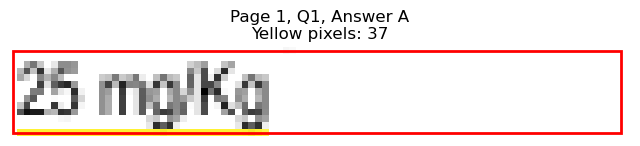

Page 1, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=124.2, y1=133.3
Page 1, Q1, B: Yellow pixels: 281
Page 1, Q1, B: Total non-white pixels: 493
Page 1, Q1, B: Yellow percentage: 57.0%


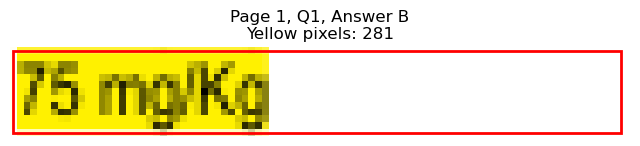

Page 1, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=129.0, y1=145.3
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 267
Page 1, Q1, C: Yellow percentage: 0.0%


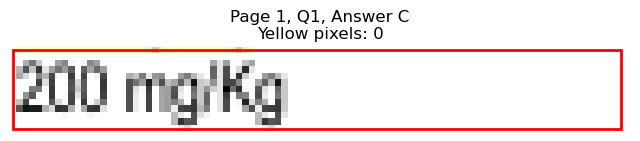

Page 1, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=375.9, y1=121.3
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 192
Page 1, Q1, D: Yellow percentage: 0.0%


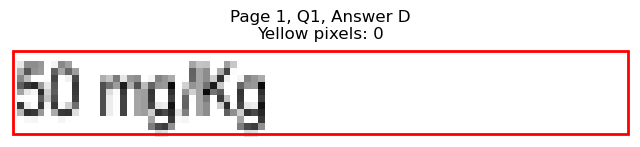

Page 1, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=380.7, y1=133.3
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 216
Page 1, Q1, E: Yellow percentage: 0.0%


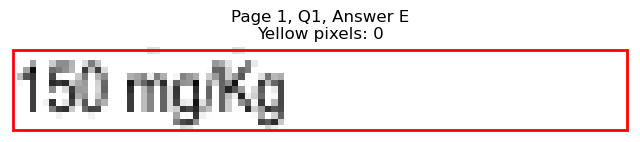


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=107.1, y1=181.5
Page 1, Q2, A: Yellow pixels: 197
Page 1, Q2, A: Total non-white pixels: 314
Page 1, Q2, A: Yellow percentage: 62.7%


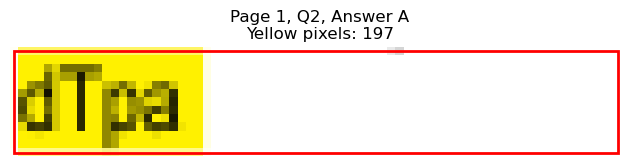

Page 1, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=118.5, y1=193.5
Page 1, Q2, B: Yellow pixels: 22
Page 1, Q2, B: Total non-white pixels: 196
Page 1, Q2, B: Yellow percentage: 11.2%


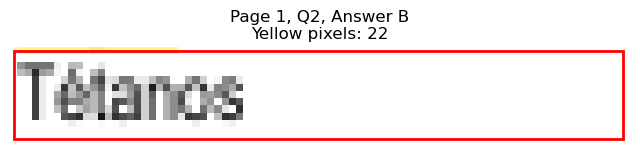

Page 1, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=131.9, y1=205.5
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 226
Page 1, Q2, C: Yellow percentage: 0.0%


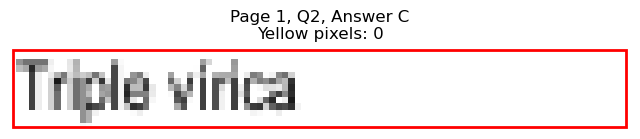

Page 1, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=370.2, y1=181.5
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 175
Page 1, Q2, D: Yellow percentage: 0.0%


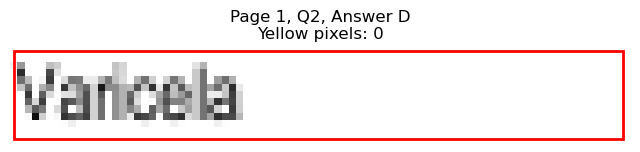

Page 1, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=380.7, y1=193.5
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 243
Page 1, Q2, E: Yellow percentage: 0.0%


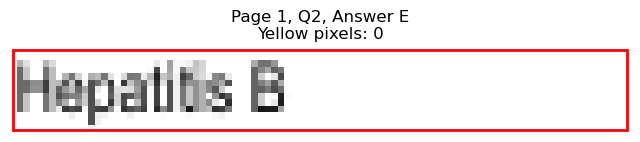


Page 1, Q2 - Selected Answer: A (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=99.4, y1=253.8
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 64
Page 1, Q3, A: Yellow percentage: 0.0%


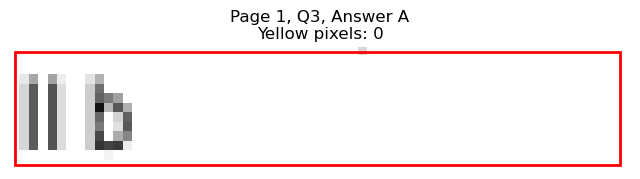

Page 1, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=101.8, y1=265.8
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 74
Page 1, Q3, B: Yellow percentage: 0.0%


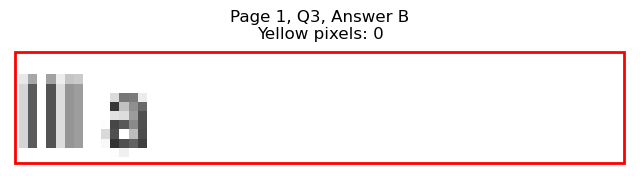

Page 1, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=101.8, y1=277.9
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 72
Page 1, Q3, C: Yellow percentage: 0.0%


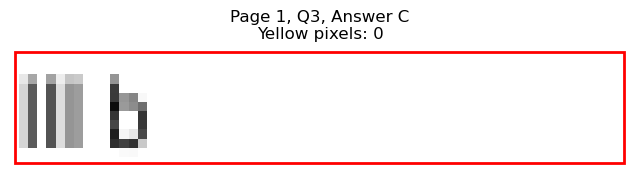

Page 1, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=348.7, y1=253.8
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 53
Page 1, Q3, D: Yellow percentage: 0.0%


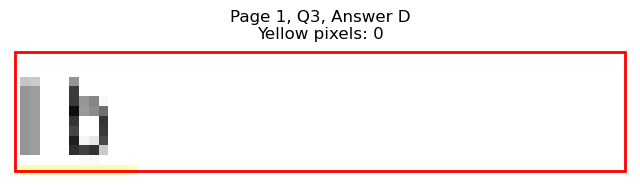

Page 1, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=351.1, y1=265.8
Page 1, Q3, E: Yellow pixels: 94
Page 1, Q3, E: Total non-white pixels: 169
Page 1, Q3, E: Yellow percentage: 55.6%


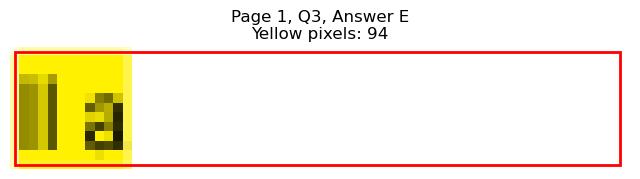


Page 1, Q3 - Selected Answer: E (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=207.2, y1=350.2
Page 1, Q4, A: Yellow pixels: 975
Page 1, Q4, A: Total non-white pixels: 1610
Page 1, Q4, A: Yellow percentage: 60.6%


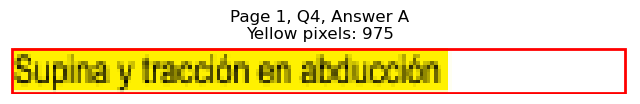

Page 1, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=203.2, y1=362.3
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 674
Page 1, Q4, B: Yellow percentage: 0.0%


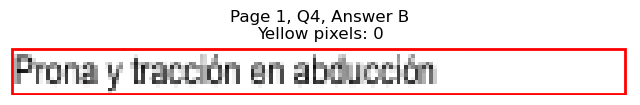

Page 1, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=198.5, y1=374.3
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 526
Page 1, Q4, C: Yellow percentage: 0.0%


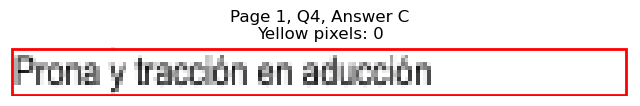

Page 1, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=453.9, y1=350.2
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 580
Page 1, Q4, D: Yellow percentage: 0.0%


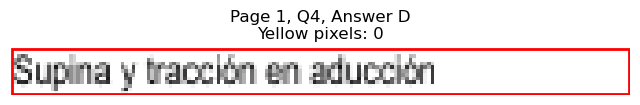

Page 1, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=491.7, y1=362.3
Page 1, Q4, E: Yellow pixels: 0
Page 1, Q4, E: Total non-white pixels: 783
Page 1, Q4, E: Yellow percentage: 0.0%


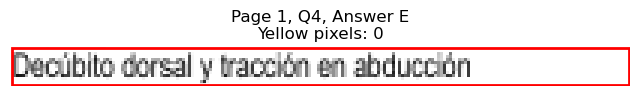


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=118.5, y1=410.4
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 174
Page 1, Q5, A: Yellow percentage: 0.0%


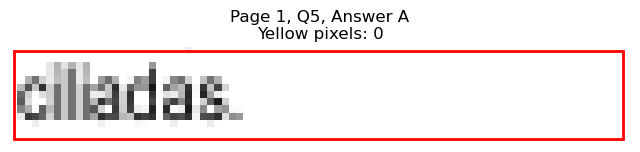

Page 1, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=159.6, y1=422.5
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 403
Page 1, Q5, B: Yellow percentage: 0.0%


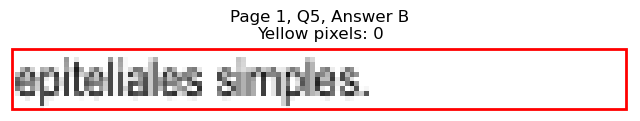

Page 1, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=153.4, y1=434.5
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 326
Page 1, Q5, C: Yellow percentage: 0.0%


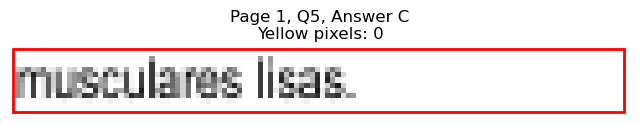

Page 1, Q5 - D: Detected box: x0=336.7, y0=398.3, x1=374.0, y1=410.4
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 165
Page 1, Q5, D: Yellow percentage: 0.0%


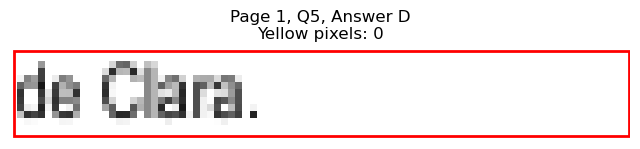

Page 1, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=387.0, y1=422.5
Page 1, Q5, E: Yellow pixels: 416
Page 1, Q5, E: Total non-white pixels: 637
Page 1, Q5, E: Yellow percentage: 65.3%


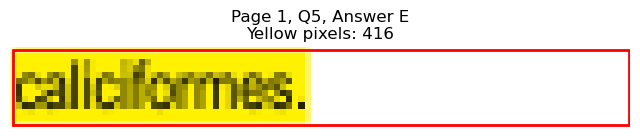


Page 1, Q5 - Selected Answer: E (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=85.0, y0=482.7, x1=104.5, y1=494.8
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 121
Page 1, Q6, A: Yellow percentage: 0.0%


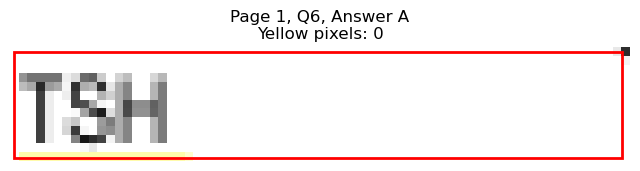

Page 1, Q6 - B: Detected box: x0=85.0, y0=494.7, x1=104.7, y1=506.8
Page 1, Q6, B: Yellow pixels: 153
Page 1, Q6, B: Total non-white pixels: 272
Page 1, Q6, B: Yellow percentage: 56.2%


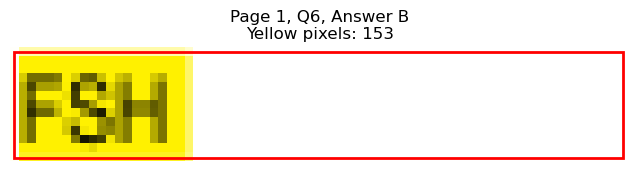

Page 1, Q6 - C: Detected box: x0=85.0, y0=506.8, x1=121.8, y1=518.9
Page 1, Q6, C: Yellow pixels: 20
Page 1, Q6, C: Total non-white pixels: 217
Page 1, Q6, C: Yellow percentage: 9.2%


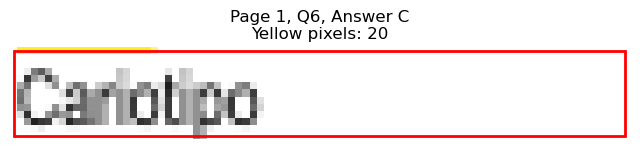

Page 1, Q6 - D: Detected box: x0=336.7, y0=482.7, x1=377.4, y1=494.8
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 200
Page 1, Q6, D: Yellow percentage: 0.0%


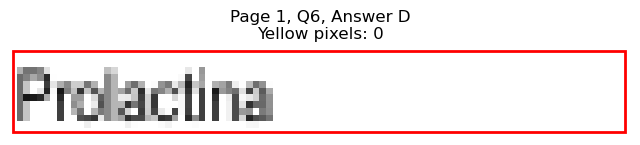

Page 1, Q6 - E: Detected box: x0=336.7, y0=494.7, x1=385.5, y1=506.8
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 235
Page 1, Q6, E: Yellow percentage: 0.0%


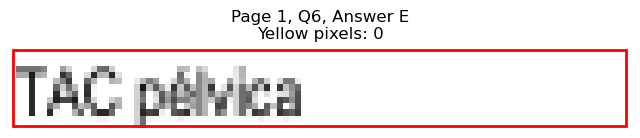


Page 1, Q6 - Selected Answer: B (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=85.0, y0=542.9, x1=152.9, y1=555.0
Page 1, Q7, A: Yellow pixels: 533
Page 1, Q7, A: Total non-white pixels: 874
Page 1, Q7, A: Yellow percentage: 61.0%


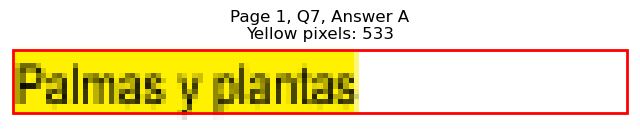

Page 1, Q7 - B: Detected box: x0=85.0, y0=554.9, x1=122.3, y1=567.0
Page 1, Q7, B: Yellow pixels: 61
Page 1, Q7, B: Total non-white pixels: 272
Page 1, Q7, B: Yellow percentage: 22.4%


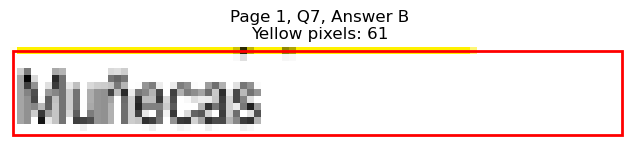

Page 1, Q7 - C: Detected box: x0=85.0, y0=567.1, x1=147.7, y1=579.2
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 331
Page 1, Q7, C: Yellow percentage: 0.0%


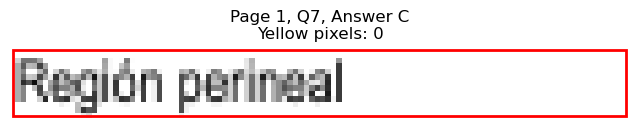

Page 1, Q7 - D: Detected box: x0=336.7, y0=542.9, x1=368.7, y1=555.0
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 167
Page 1, Q7, D: Yellow percentage: 0.0%


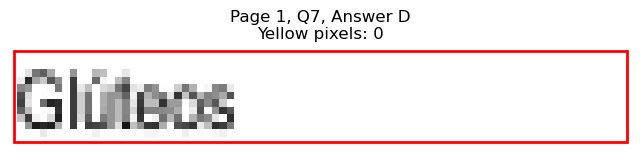

Page 1, Q7 - E: Detected box: x0=336.7, y0=554.9, x1=404.1, y1=567.0
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 366
Page 1, Q7, E: Yellow percentage: 0.0%


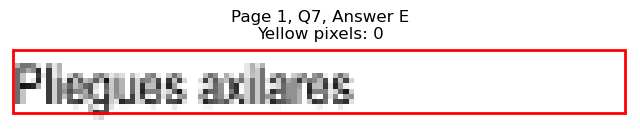


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=85.0, y0=639.3, x1=120.9, y1=651.4
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 204
Page 1, Q8, A: Yellow percentage: 0.0%


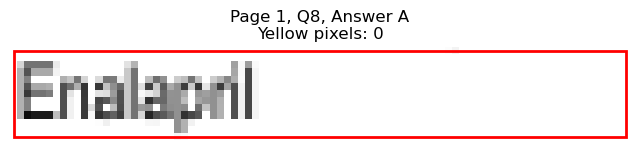

Page 1, Q8 - B: Detected box: x0=85.0, y0=651.4, x1=118.5, y1=663.5
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 169
Page 1, Q8, B: Yellow percentage: 0.0%


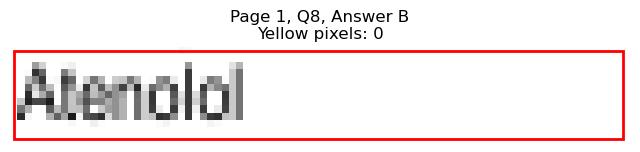

Page 1, Q8 - C: Detected box: x0=85.0, y0=663.4, x1=126.6, y1=675.5
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 223
Page 1, Q8, C: Yellow percentage: 0.0%


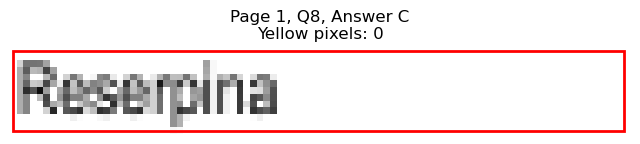

Page 1, Q8 - D: Detected box: x0=336.7, y0=639.3, x1=377.4, y1=651.4
Page 1, Q8, D: Yellow pixels: 305
Page 1, Q8, D: Total non-white pixels: 507
Page 1, Q8, D: Yellow percentage: 60.2%


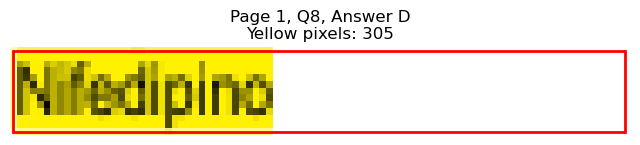

Page 1, Q8 - E: Detected box: x0=336.7, y0=651.4, x1=403.2, y1=663.5
Page 1, Q8, E: Yellow pixels: 38
Page 1, Q8, E: Total non-white pixels: 383
Page 1, Q8, E: Yellow percentage: 9.9%


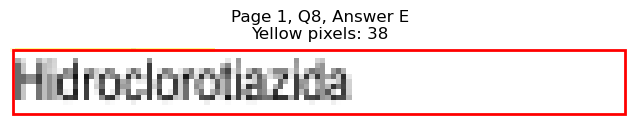


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=85.0, y0=747.8, x1=161.5, y1=759.9
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 427
Page 1, Q9, A: Yellow percentage: 0.0%


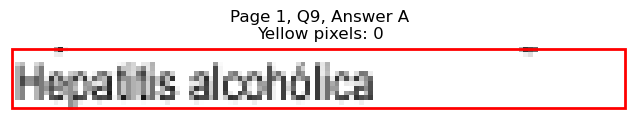

Page 1, Q9 - B: Detected box: x0=85.0, y0=759.8, x1=159.6, y1=771.9
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 396
Page 1, Q9, B: Yellow percentage: 0.0%


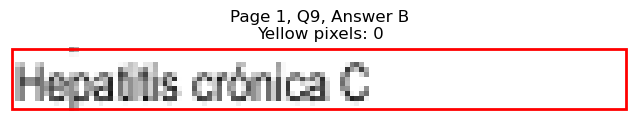

Page 1, Q9 - C: Detected box: x0=85.0, y0=771.9, x1=159.1, y1=784.0
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 402
Page 1, Q9, C: Yellow percentage: 0.0%


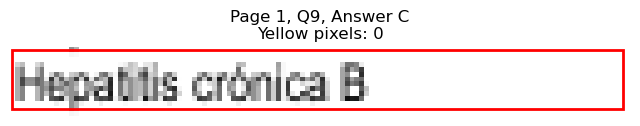

Page 1, Q9 - D: Detected box: x0=336.7, y0=747.8, x1=466.4, y1=759.9
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 750
Page 1, Q9, D: Yellow percentage: 0.0%


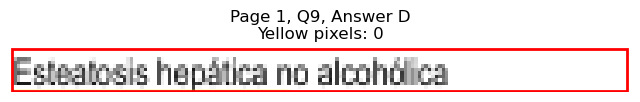

Page 1, Q9 - E: Detected box: x0=336.7, y0=759.8, x1=417.7, y1=771.9
Page 1, Q9, E: Yellow pixels: 622
Page 1, Q9, E: Total non-white pixels: 1066
Page 1, Q9, E: Yellow percentage: 58.3%


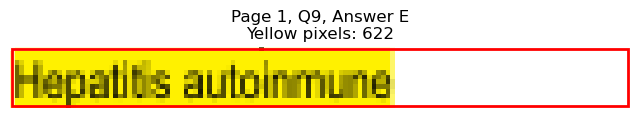


Page 1, Q9 - Selected Answer: E (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=144.9, y1=109.2
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 328
Page 2, Q1, A: Yellow percentage: 0.0%


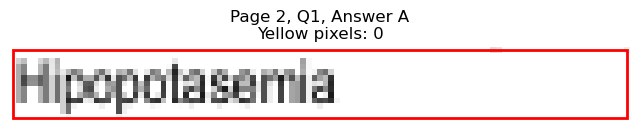

Page 2, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=139.1, y1=121.3
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 298
Page 2, Q1, B: Yellow percentage: 0.0%


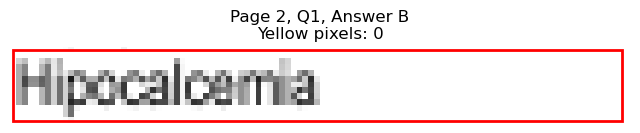

Page 2, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=154.3, y1=133.3
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 375
Page 2, Q1, C: Yellow percentage: 0.0%


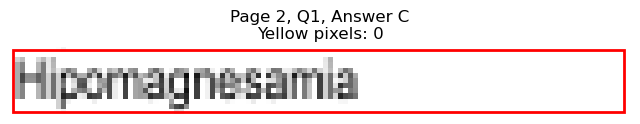

Page 2, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=390.3, y1=109.2
Page 2, Q1, D: Yellow pixels: 375
Page 2, Q1, D: Total non-white pixels: 676
Page 2, Q1, D: Yellow percentage: 55.5%


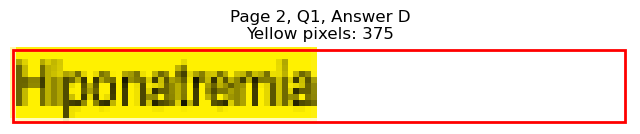

Page 2, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=397.0, y1=121.3
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 381
Page 2, Q1, E: Yellow percentage: 0.0%


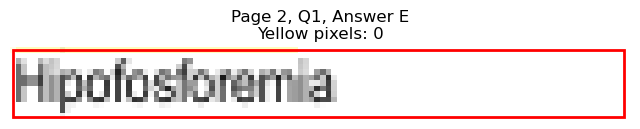


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=149.1, y1=193.5
Page 2, Q2, A: Yellow pixels: 518
Page 2, Q2, A: Total non-white pixels: 819
Page 2, Q2, A: Yellow percentage: 63.2%


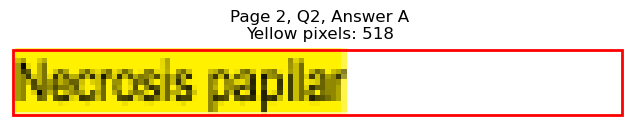

Page 2, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=210.4, y1=205.5
Page 2, Q2, B: Yellow pixels: 61
Page 2, Q2, B: Total non-white pixels: 671
Page 2, Q2, B: Yellow percentage: 9.1%


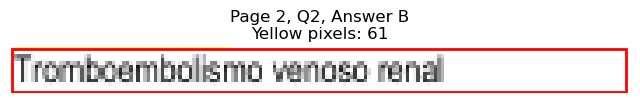

Page 2, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=135.3, y1=217.7
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 263
Page 2, Q2, C: Yellow percentage: 0.0%


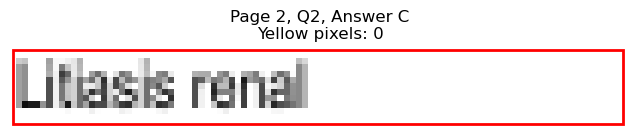

Page 2, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=390.8, y1=193.5
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 297
Page 2, Q2, D: Yellow percentage: 0.0%


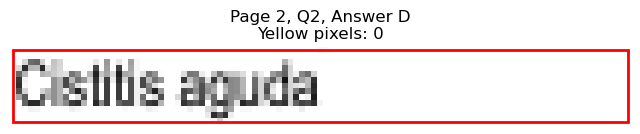

Page 2, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=414.7, y1=205.5
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 414
Page 2, Q2, E: Yellow percentage: 0.0%


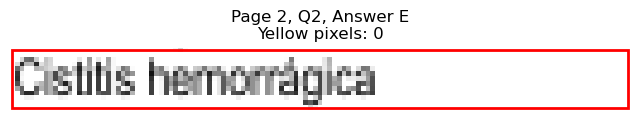


Page 2, Q2 - Selected Answer: A (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=85.0, y0=253.7, x1=192.3, y1=265.8
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 528
Page 2, Q3, A: Yellow percentage: 0.0%


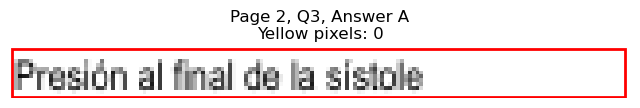

Page 2, Q3 - B: Detected box: x0=85.0, y0=265.8, x1=205.6, y1=277.9
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 555
Page 2, Q3, B: Yellow percentage: 0.0%


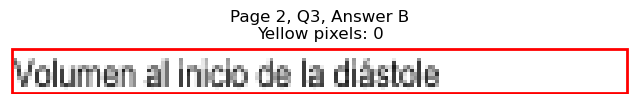

Page 2, Q3 - C: Detected box: x0=85.0, y0=277.8, x1=200.8, y1=289.9
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 569
Page 2, Q3, C: Yellow percentage: 0.0%


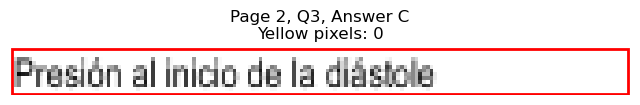

Page 2, Q3 - D: Detected box: x0=336.7, y0=253.7, x1=448.8, y1=265.8
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 554
Page 2, Q3, D: Yellow percentage: 0.0%


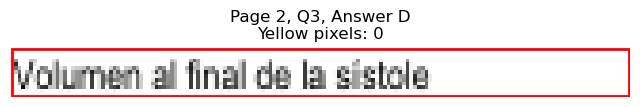

Page 2, Q3 - E: Detected box: x0=336.7, y0=265.8, x1=453.5, y1=277.9
Page 2, Q3, E: Yellow pixels: 897
Page 2, Q3, E: Total non-white pixels: 1507
Page 2, Q3, E: Yellow percentage: 59.5%


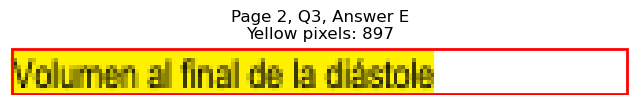


Page 2, Q3 - Selected Answer: E (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=85.0, y0=313.9, x1=146.3, y1=326.0
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 331
Page 2, Q4, A: Yellow percentage: 0.0%


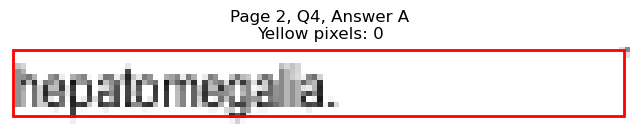

Page 2, Q4 - B: Detected box: x0=85.0, y0=326.1, x1=119.9, y1=338.2
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 167
Page 2, Q4, B: Yellow percentage: 0.0%


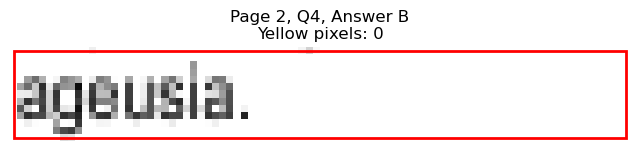

Page 2, Q4 - C: Detected box: x0=85.0, y0=338.1, x1=168.7, y1=350.2
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 439
Page 2, Q4, C: Yellow percentage: 0.0%


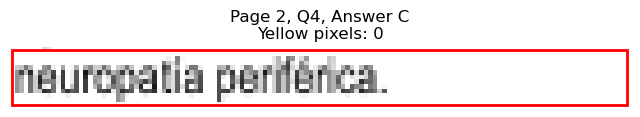

Page 2, Q4 - D: Detected box: x0=336.7, y0=313.9, x1=456.8, y1=326.0
Page 2, Q4, D: Yellow pixels: 891
Page 2, Q4, D: Total non-white pixels: 1666
Page 2, Q4, D: Yellow percentage: 53.5%


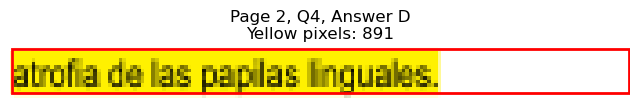

Page 2, Q4 - E: Detected box: x0=336.7, y0=326.1, x1=397.5, y1=338.2
Page 2, Q4, E: Yellow pixels: 0
Page 2, Q4, E: Total non-white pixels: 423
Page 2, Q4, E: Yellow percentage: 0.0%


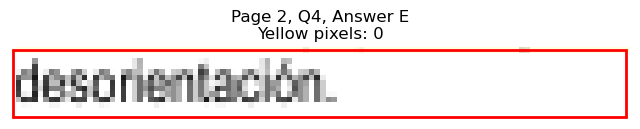


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=85.0, y0=410.4, x1=260.7, y1=422.5
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 928
Page 2, Q5, A: Yellow percentage: 0.0%


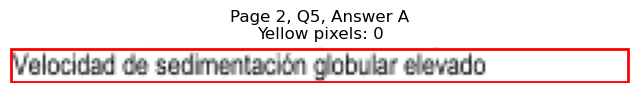

Page 2, Q5 - B: Detected box: x0=85.0, y0=422.4, x1=176.4, y1=434.5
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 471
Page 2, Q5, B: Yellow percentage: 0.0%


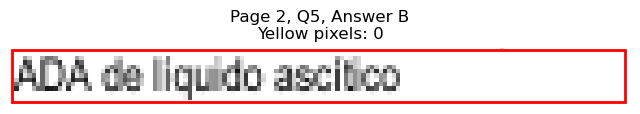

Page 2, Q5 - C: Detected box: x0=85.0, y0=434.4, x1=175.0, y1=446.5
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 483
Page 2, Q5, C: Yellow percentage: 0.0%


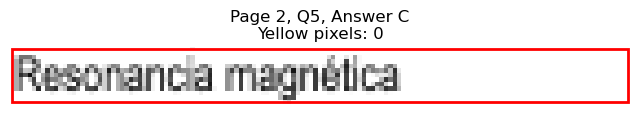

Page 2, Q5 - D: Detected box: x0=336.7, y0=410.4, x1=452.5, y1=422.5
Page 2, Q5, D: Yellow pixels: 68
Page 2, Q5, D: Total non-white pixels: 632
Page 2, Q5, D: Yellow percentage: 10.8%


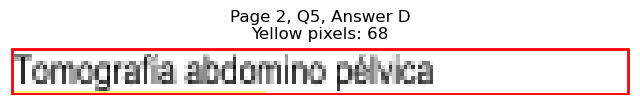

Page 2, Q5 - E: Detected box: x0=336.7, y0=422.4, x1=407.5, y1=434.5
Page 2, Q5, E: Yellow pixels: 565
Page 2, Q5, E: Total non-white pixels: 911
Page 2, Q5, E: Yellow percentage: 62.0%


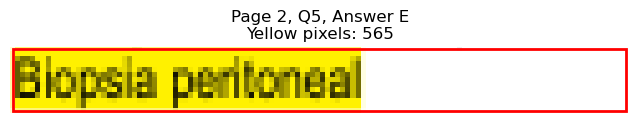


Page 2, Q5 - Selected Answer: E (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=85.0, y0=494.7, x1=203.7, y1=506.8
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 627
Page 2, Q6, A: Yellow percentage: 0.0%


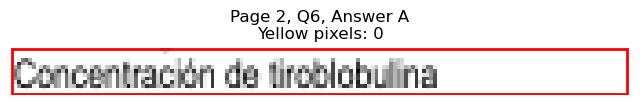

Page 2, Q6 - B: Detected box: x0=85.0, y0=506.8, x1=154.8, y1=518.9
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 486
Page 2, Q6, B: Yellow percentage: 0.0%


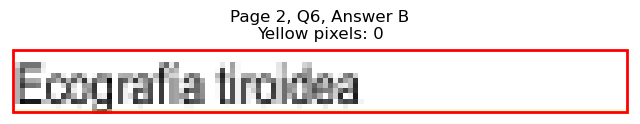

Page 2, Q6 - C: Detected box: x0=85.0, y0=518.8, x1=228.2, y1=530.9
Page 2, Q6, C: Yellow pixels: 1099
Page 2, Q6, C: Total non-white pixels: 1845
Page 2, Q6, C: Yellow percentage: 59.6%


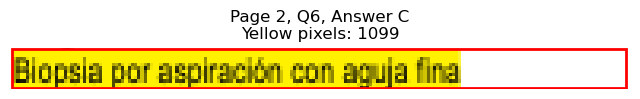

Page 2, Q6 - D: Detected box: x0=336.7, y0=494.7, x1=422.4, y1=506.8
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 451
Page 2, Q6, D: Yellow percentage: 0.0%


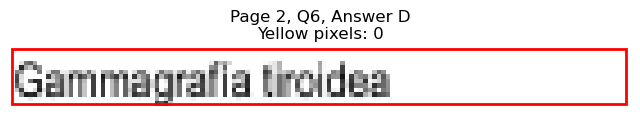

Page 2, Q6 - E: Detected box: x0=336.7, y0=506.8, x1=475.1, y1=518.9
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 701
Page 2, Q6, E: Yellow percentage: 0.0%


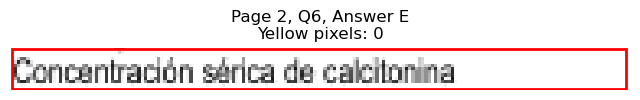


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=85.0, y0=554.9, x1=122.3, y1=567.0
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 170
Page 2, Q7, A: Yellow percentage: 0.0%


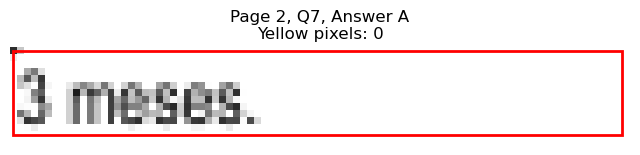

Page 2, Q7 - B: Detected box: x0=85.0, y0=567.1, x1=122.3, y1=579.2
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 163
Page 2, Q7, B: Yellow percentage: 0.0%


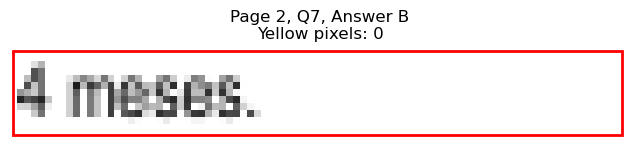

Page 2, Q7 - C: Detected box: x0=85.0, y0=579.1, x1=122.3, y1=591.2
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 171
Page 2, Q7, C: Yellow percentage: 0.0%


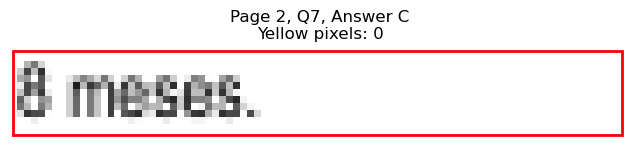

Page 2, Q7 - D: Detected box: x0=336.7, y0=554.9, x1=374.0, y1=567.0
Page 2, Q7, D: Yellow pixels: 286
Page 2, Q7, D: Total non-white pixels: 504
Page 2, Q7, D: Yellow percentage: 56.7%


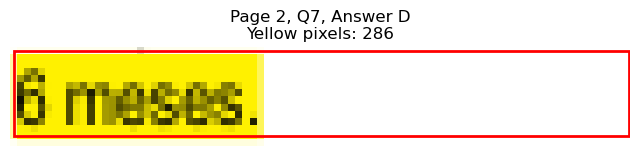

Page 2, Q7 - E: Detected box: x0=336.7, y0=567.1, x1=374.0, y1=579.2
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 198
Page 2, Q7, E: Yellow percentage: 0.0%


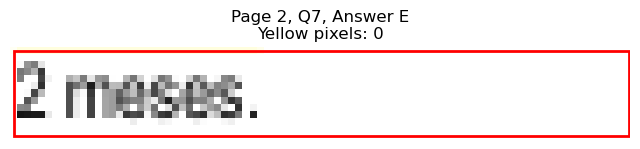


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=85.0, y0=639.3, x1=135.4, y1=651.4
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 276
Page 2, Q8, A: Yellow percentage: 0.0%


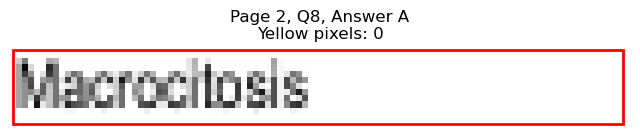

Page 2, Q8 - B: Detected box: x0=85.0, y0=651.4, x1=155.9, y1=663.5
Page 2, Q8, B: Yellow pixels: 603
Page 2, Q8, B: Total non-white pixels: 910
Page 2, Q8, B: Yellow percentage: 66.3%


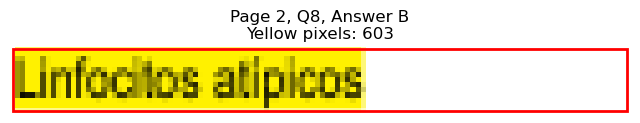

Page 2, Q8 - C: Detected box: x0=85.0, y0=663.4, x1=175.9, y1=675.5
Page 2, Q8, C: Yellow pixels: 68
Page 2, Q8, C: Total non-white pixels: 544
Page 2, Q8, C: Yellow percentage: 12.5%


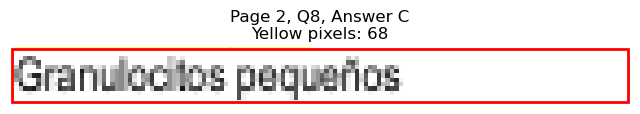

Page 2, Q8 - D: Detected box: x0=336.7, y0=639.3, x1=392.7, y1=651.4
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 276
Page 2, Q8, D: Yellow percentage: 0.0%


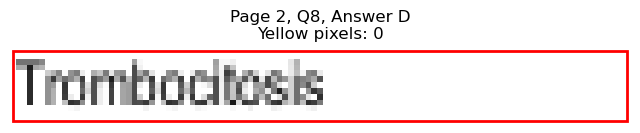

Page 2, Q8 - E: Detected box: x0=336.7, y0=651.4, x1=384.2, y1=663.5
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 253
Page 2, Q8, E: Yellow percentage: 0.0%


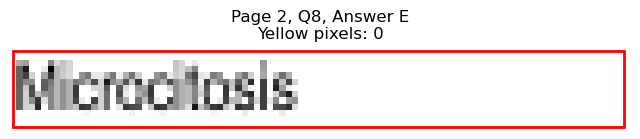


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=85.0, y0=699.5, x1=170.7, y1=711.7
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 414
Page 2, Q9, A: Yellow percentage: 0.0%


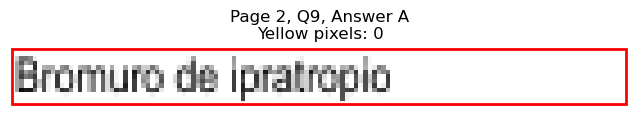

Page 2, Q9 - B: Detected box: x0=85.0, y0=711.7, x1=148.7, y1=723.8
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 325
Page 2, Q9, B: Yellow percentage: 0.0%


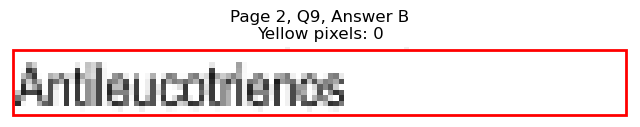

Page 2, Q9 - C: Detected box: x0=85.0, y0=723.7, x1=130.5, y1=735.8
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 234
Page 2, Q9, C: Yellow percentage: 0.0%


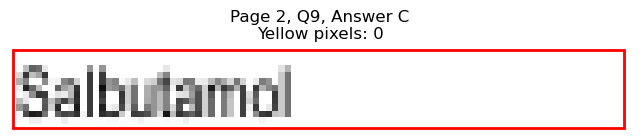

Page 2, Q9 - D: Detected box: x0=336.7, y0=699.5, x1=371.6, y1=711.7
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 178
Page 2, Q9, D: Yellow percentage: 0.0%


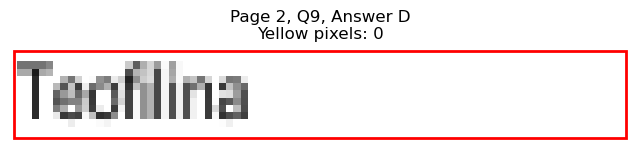

Page 2, Q9 - E: Detected box: x0=336.7, y0=711.7, x1=421.4, y1=723.8
Page 2, Q9, E: Yellow pixels: 610
Page 2, Q9, E: Total non-white pixels: 1079
Page 2, Q9, E: Yellow percentage: 56.5%


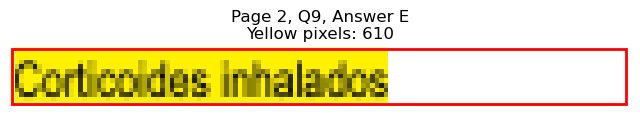


Page 2, Q9 - Selected Answer: E (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=133.8, y1=133.3
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 269
Page 3, Q1, A: Yellow percentage: 0.0%


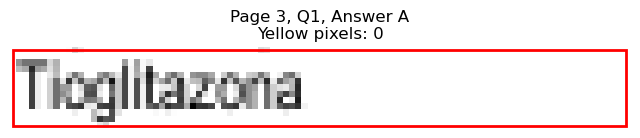

Page 3, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=153.5, y1=145.3
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 382
Page 3, Q1, B: Yellow percentage: 0.0%


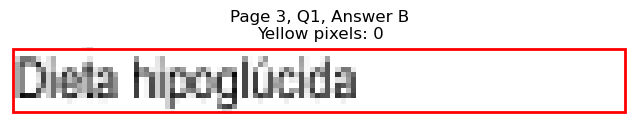

Page 3, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=130.5, y1=157.4
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 245
Page 3, Q1, C: Yellow percentage: 0.0%


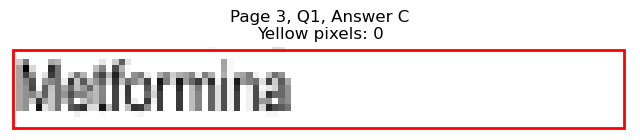

Page 3, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=382.6, y1=133.3
Page 3, Q1, D: Yellow pixels: 50
Page 3, Q1, D: Total non-white pixels: 302
Page 3, Q1, D: Yellow percentage: 16.6%


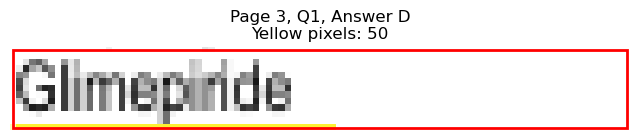

Page 3, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=389.4, y1=145.3
Page 3, Q1, E: Yellow pixels: 357
Page 3, Q1, E: Total non-white pixels: 663
Page 3, Q1, E: Yellow percentage: 53.8%


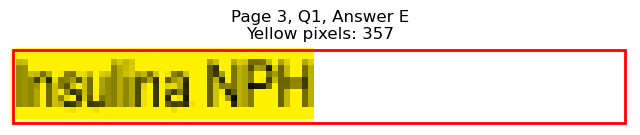


Page 3, Q1 - Selected Answer: E (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=128.1, y1=193.5
Page 3, Q2, A: Yellow pixels: 72
Page 3, Q2, A: Total non-white pixels: 317
Page 3, Q2, A: Yellow percentage: 22.7%


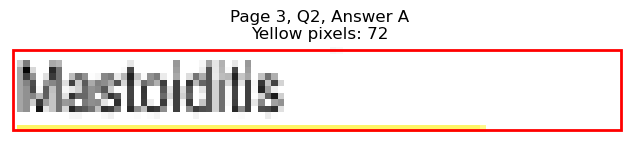

Page 3, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=159.1, y1=205.5
Page 3, Q2, B: Yellow pixels: 610
Page 3, Q2, B: Total non-white pixels: 949
Page 3, Q2, B: Yellow percentage: 64.3%


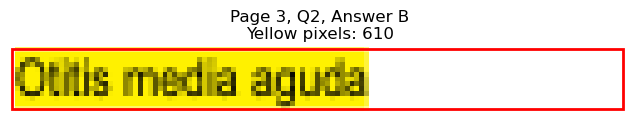

Page 3, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=135.7, y1=217.7
Page 3, Q2, C: Yellow pixels: 72
Page 3, Q2, C: Total non-white pixels: 358
Page 3, Q2, C: Yellow percentage: 20.1%


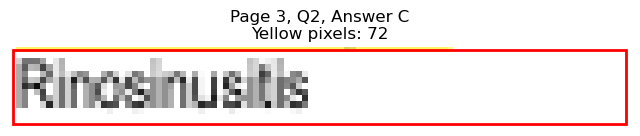

Page 3, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=403.8, y1=193.5
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 354
Page 3, Q2, D: Yellow percentage: 0.0%


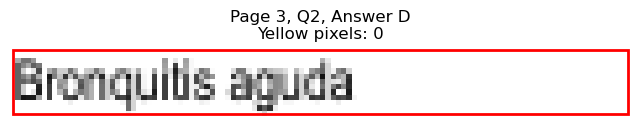

Page 3, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=408.9, y1=205.5
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 410
Page 3, Q2, E: Yellow percentage: 0.0%


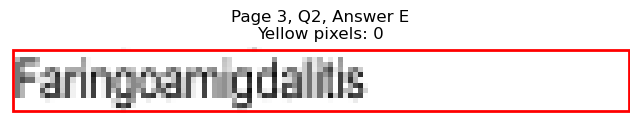


Page 3, Q2 - Selected Answer: B (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=85.0, y0=253.7, x1=252.5, y1=265.8
Page 3, Q3, A: Yellow pixels: 1306
Page 3, Q3, A: Total non-white pixels: 2174
Page 3, Q3, A: Yellow percentage: 60.1%


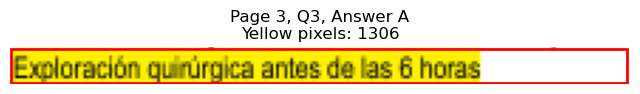

Page 3, Q3 - B: Detected box: x0=85.0, y0=265.8, x1=158.7, y1=277.9
Page 3, Q3, B: Yellow pixels: 117
Page 3, Q3, B: Total non-white pixels: 499
Page 3, Q3, B: Yellow percentage: 23.4%


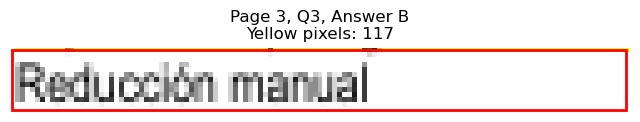

Page 3, Q3 - C: Detected box: x0=85.0, y0=277.8, x1=234.3, y1=289.9
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 780
Page 3, Q3, C: Yellow percentage: 0.0%


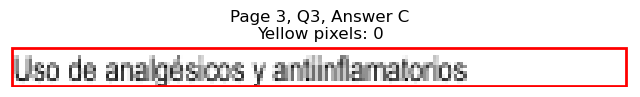

Page 3, Q3 - D: Detected box: x0=336.7, y0=253.7, x1=515.7, y1=265.8
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 919
Page 3, Q3, D: Yellow percentage: 0.0%


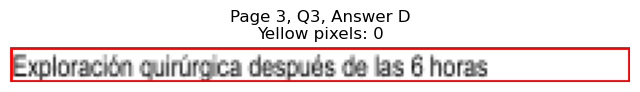

Page 3, Q3 - E: Detected box: x0=336.7, y0=265.8, x1=458.3, y1=277.9
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 620
Page 3, Q3, E: Yellow percentage: 0.0%


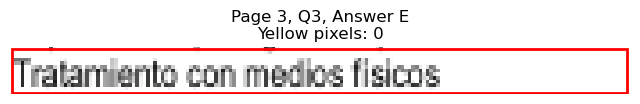


Page 3, Q3 - Selected Answer: A (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=85.0, y0=350.2, x1=201.3, y1=362.3
Page 3, Q4, A: Yellow pixels: 876
Page 3, Q4, A: Total non-white pixels: 1495
Page 3, Q4, A: Yellow percentage: 58.6%


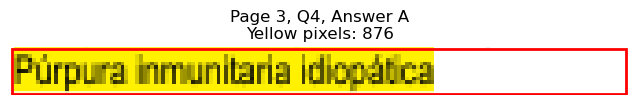

Page 3, Q4 - B: Detected box: x0=85.0, y0=362.2, x1=192.3, y1=374.3
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 657
Page 3, Q4, B: Yellow percentage: 0.0%


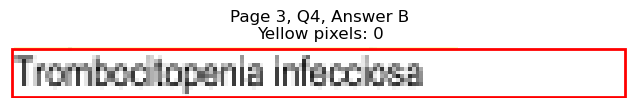

Page 3, Q4 - C: Detected box: x0=85.0, y0=374.2, x1=163.0, y1=386.3
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 375
Page 3, Q4, C: Yellow percentage: 0.0%


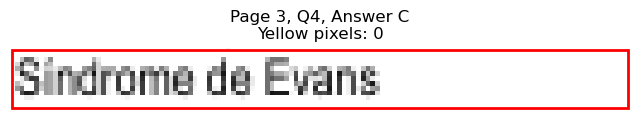

Page 3, Q4 - D: Detected box: x0=336.7, y0=350.2, x1=437.2, y1=362.3
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 524
Page 3, Q4, D: Yellow percentage: 0.0%


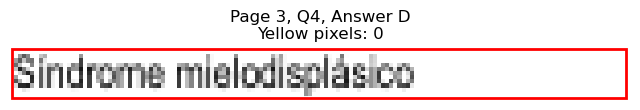

Page 3, Q4 - E: Detected box: x0=336.7, y0=362.2, x1=453.6, y1=374.3
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 591
Page 3, Q4, E: Yellow percentage: 0.0%


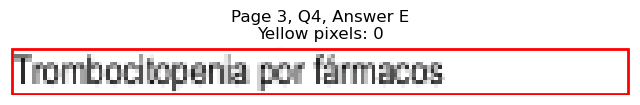


Page 3, Q4 - Selected Answer: A (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=85.0, y0=410.4, x1=215.7, y1=422.5
Page 3, Q5, A: Yellow pixels: 1186
Page 3, Q5, A: Total non-white pixels: 1692
Page 3, Q5, A: Yellow percentage: 70.1%


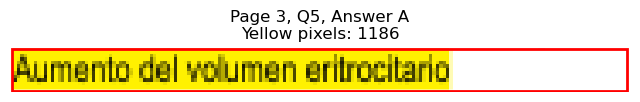

Page 3, Q5 - B: Detected box: x0=85.0, y0=422.4, x1=231.4, y1=434.5
Page 3, Q5, B: Yellow pixels: 128
Page 3, Q5, B: Total non-white pixels: 904
Page 3, Q5, B: Yellow percentage: 14.2%


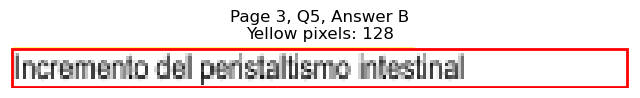

Page 3, Q5 - C: Detected box: x0=85.0, y0=434.4, x1=223.4, y1=446.5
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 670
Page 3, Q5, C: Yellow percentage: 0.0%


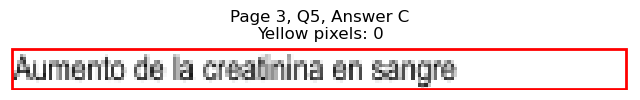

Page 3, Q5 - D: Detected box: x0=336.7, y0=410.4, x1=478.4, y1=422.5
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 732
Page 3, Q5, D: Yellow percentage: 0.0%


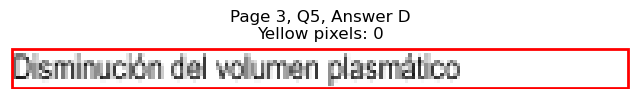

Page 3, Q5 - E: Detected box: x0=336.7, y0=422.4, x1=484.5, y1=434.5
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 770
Page 3, Q5, E: Yellow percentage: 0.0%


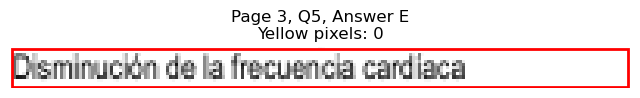


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=85.0, y0=470.7, x1=151.9, y1=482.8
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 322
Page 3, Q6, A: Yellow percentage: 0.0%


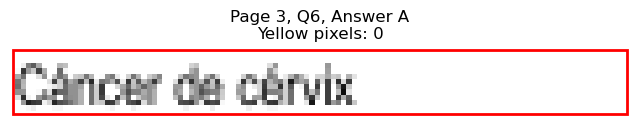

Page 3, Q6 - B: Detected box: x0=85.0, y0=482.7, x1=157.2, y1=494.8
Page 3, Q6, B: Yellow pixels: 1
Page 3, Q6, B: Total non-white pixels: 436
Page 3, Q6, B: Yellow percentage: 0.2%


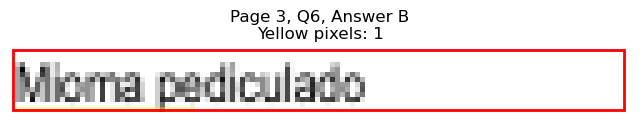

Page 3, Q6 - C: Detected box: x0=85.0, y0=494.7, x1=123.7, y1=506.8
Page 3, Q6, C: Yellow pixels: 270
Page 3, Q6, C: Total non-white pixels: 493
Page 3, Q6, C: Yellow percentage: 54.8%


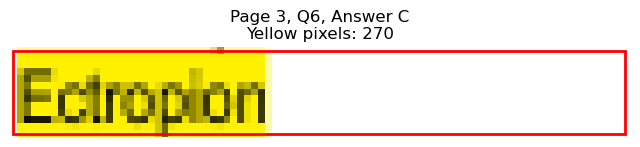

Page 3, Q6 - D: Detected box: x0=336.7, y0=470.7, x1=374.0, y1=482.8
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 194
Page 3, Q6, D: Yellow percentage: 0.0%


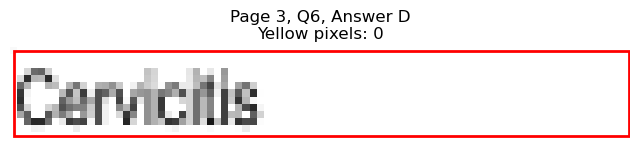

Page 3, Q6 - E: Detected box: x0=336.7, y0=482.7, x1=413.7, y1=494.8
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 380
Page 3, Q6, E: Yellow percentage: 0.0%


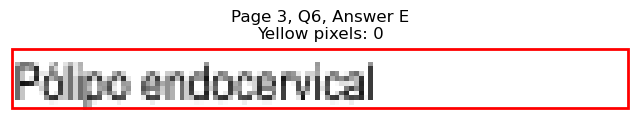


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=85.0, y0=530.9, x1=167.3, y1=543.0
Page 3, Q7, A: Yellow pixels: 615
Page 3, Q7, A: Total non-white pixels: 1054
Page 3, Q7, A: Yellow percentage: 58.3%


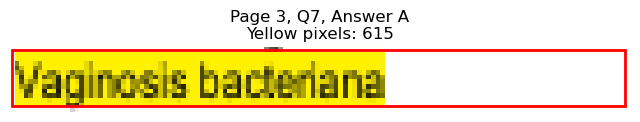

Page 3, Q7 - B: Detected box: x0=85.0, y0=542.9, x1=123.7, y1=555.0
Page 3, Q7, B: Yellow pixels: 76
Page 3, Q7, B: Total non-white pixels: 268
Page 3, Q7, B: Yellow percentage: 28.4%


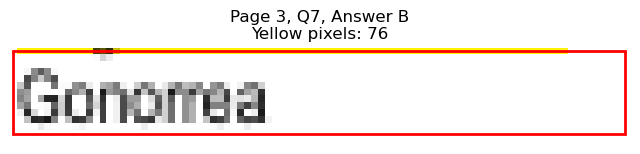

Page 3, Q7 - C: Detected box: x0=85.0, y0=554.9, x1=131.9, y1=567.0
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 252
Page 3, Q7, C: Yellow percentage: 0.0%


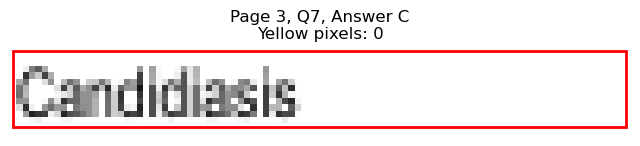

Page 3, Q7 - D: Detected box: x0=336.7, y0=530.9, x1=402.3, y1=543.0
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 373
Page 3, Q7, D: Yellow percentage: 0.0%


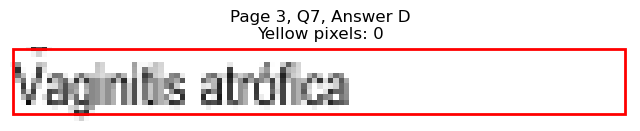

Page 3, Q7 - E: Detected box: x0=336.7, y0=542.9, x1=397.0, y1=555.0
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 290
Page 3, Q7, E: Yellow percentage: 0.0%


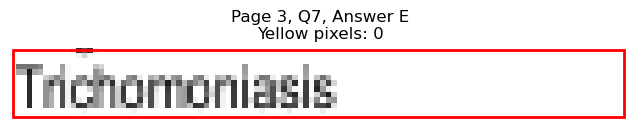


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=85.0, y0=591.2, x1=106.1, y1=603.3
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 108
Page 3, Q8, A: Yellow percentage: 0.0%


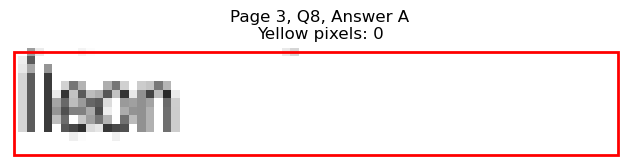

Page 3, Q8 - B: Detected box: x0=85.0, y0=603.2, x1=126.1, y1=615.3
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 224
Page 3, Q8, B: Yellow percentage: 0.0%


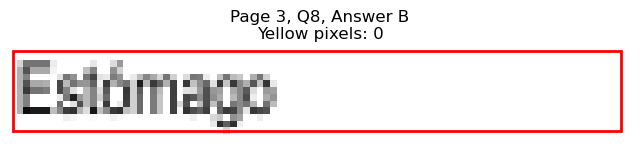

Page 3, Q8 - C: Detected box: x0=85.0, y0=615.2, x1=118.9, y1=627.3
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 196
Page 3, Q8, C: Yellow percentage: 0.0%


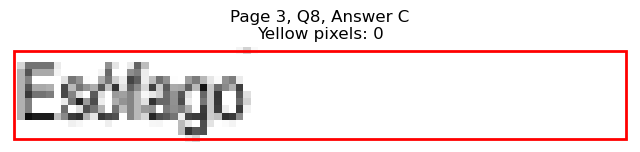

Page 3, Q8 - D: Detected box: x0=336.7, y0=591.2, x1=361.5, y1=603.3
Page 3, Q8, D: Yellow pixels: 35
Page 3, Q8, D: Total non-white pixels: 148
Page 3, Q8, D: Yellow percentage: 23.6%


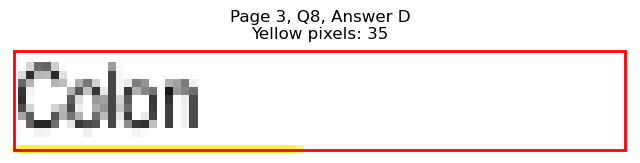

Page 3, Q8 - E: Detected box: x0=336.7, y0=603.2, x1=374.0, y1=615.3
Page 3, Q8, E: Yellow pixels: 259
Page 3, Q8, E: Total non-white pixels: 468
Page 3, Q8, E: Yellow percentage: 55.3%


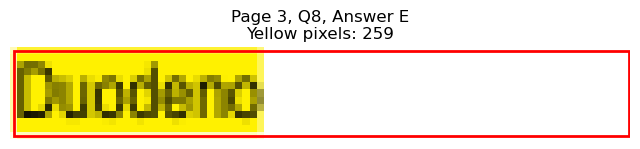


Page 3, Q8 - Selected Answer: E (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=127.6, y1=675.5
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 239
Page 3, Q9, A: Yellow percentage: 0.0%


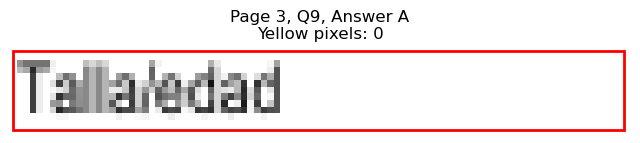

Page 3, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=128.5, y1=687.5
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 223
Page 3, Q9, B: Yellow percentage: 0.0%


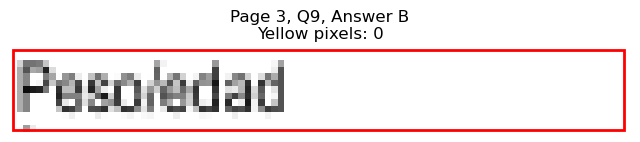

Page 3, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=179.3, y1=699.7
Page 3, Q9, C: Yellow pixels: 818
Page 3, Q9, C: Total non-white pixels: 1209
Page 3, Q9, C: Yellow percentage: 67.7%


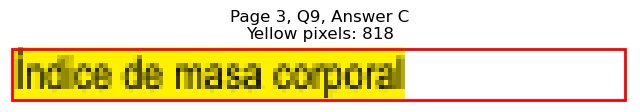

Page 3, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=409.9, y1=675.5
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 377
Page 3, Q9, D: Yellow percentage: 0.0%


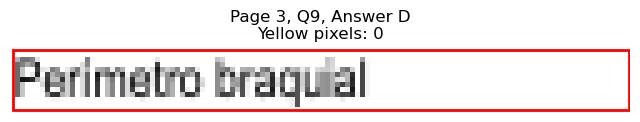

Page 3, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=399.4, y1=687.5
Page 3, Q9, E: Yellow pixels: 0
Page 3, Q9, E: Total non-white pixels: 356
Page 3, Q9, E: Yellow percentage: 0.0%


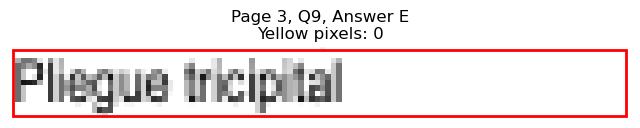


Page 3, Q9 - Selected Answer: C (based on yellow pixel count)





Page 4: Found 8 questions
Page 4, Q1 - A: Detected box: x0=85.0, y0=133.2, x1=177.4, y1=145.3
Page 4, Q1, A: Yellow pixels: 705
Page 4, Q1, A: Total non-white pixels: 1183
Page 4, Q1, A: Yellow percentage: 59.6%


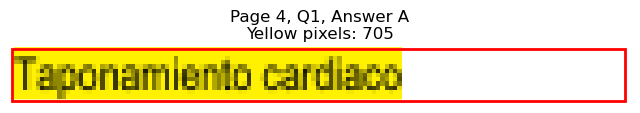

Page 4, Q1 - B: Detected box: x0=85.0, y0=145.3, x1=171.6, y1=157.4
Page 4, Q1, B: Yellow pixels: 1
Page 4, Q1, B: Total non-white pixels: 532
Page 4, Q1, B: Yellow percentage: 0.2%


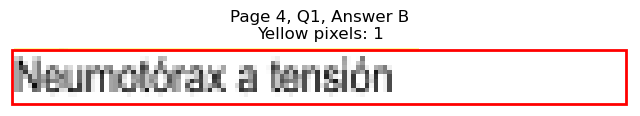

Page 4, Q1 - C: Detected box: x0=85.0, y0=157.3, x1=189.9, y1=169.4
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 519
Page 4, Q1, C: Yellow percentage: 0.0%


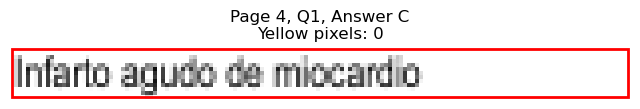

Page 4, Q1 - D: Detected box: x0=336.7, y0=133.2, x1=411.8, y1=145.3
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 398
Page 4, Q1, D: Yellow percentage: 0.0%


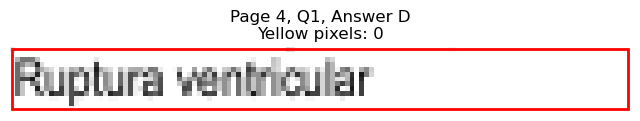

Page 4, Q1 - E: Detected box: x0=336.7, y0=145.3, x1=408.4, y1=157.4
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 369
Page 4, Q1, E: Yellow percentage: 0.0%


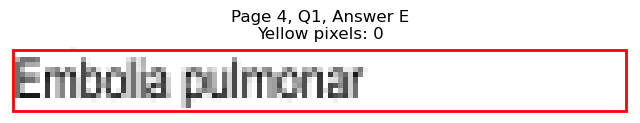


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=85.0, y0=241.7, x1=149.7, y1=253.8
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 381
Page 4, Q2, A: Yellow percentage: 0.0%


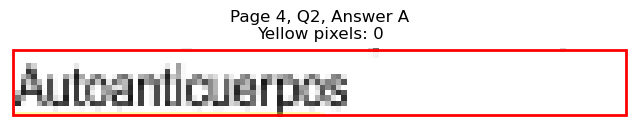

Page 4, Q2 - B: Detected box: x0=85.0, y0=253.7, x1=144.9, y1=265.8
Page 4, Q2, B: Yellow pixels: 419
Page 4, Q2, B: Total non-white pixels: 766
Page 4, Q2, B: Yellow percentage: 54.7%


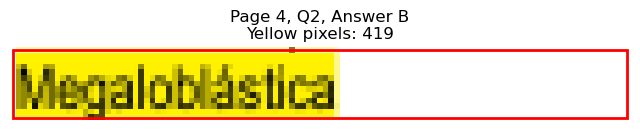

Page 4, Q2 - C: Detected box: x0=85.0, y0=265.8, x1=133.3, y1=277.9
Page 4, Q2, C: Yellow pixels: 53
Page 4, Q2, C: Total non-white pixels: 311
Page 4, Q2, C: Yellow percentage: 17.0%


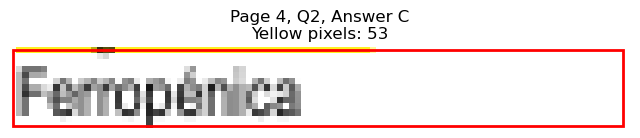

Page 4, Q2 - D: Detected box: x0=336.7, y0=241.7, x1=371.6, y1=253.8
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 197
Page 4, Q2, D: Yellow percentage: 0.0%


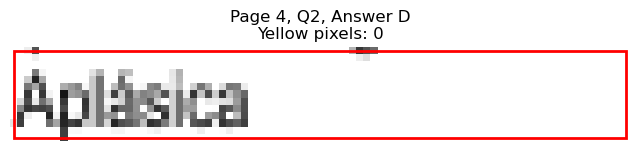

Page 4, Q2 - E: Detected box: x0=336.7, y0=253.7, x1=383.1, y1=265.8
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 236
Page 4, Q2, E: Yellow percentage: 0.0%


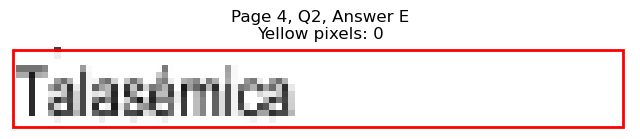


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=85.0, y0=338.1, x1=125.7, y1=350.2
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 157
Page 4, Q3, A: Yellow percentage: 0.0%


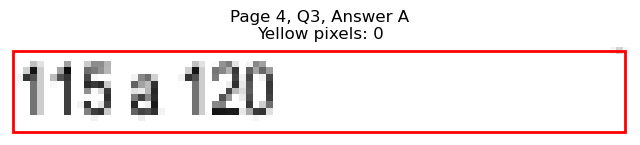

Page 4, Q3 - B: Detected box: x0=85.0, y0=350.2, x1=125.7, y1=362.3
Page 4, Q3, B: Yellow pixels: 321
Page 4, Q3, B: Total non-white pixels: 519
Page 4, Q3, B: Yellow percentage: 61.8%


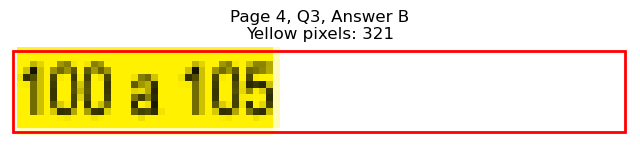

Page 4, Q3 - C: Detected box: x0=85.0, y0=362.2, x1=125.7, y1=374.3
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 180
Page 4, Q3, C: Yellow percentage: 0.0%


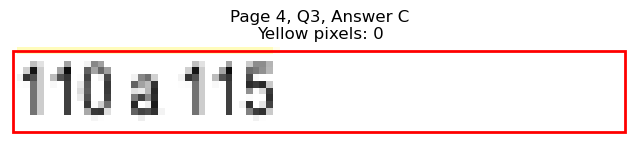

Page 4, Q3 - D: Detected box: x0=336.7, y0=338.1, x1=367.8, y1=350.2
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 141
Page 4, Q3, D: Yellow percentage: 0.0%


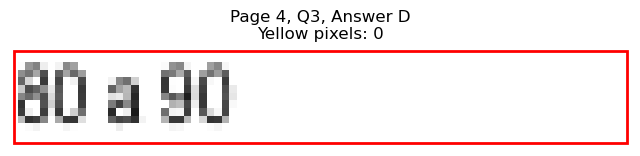

Page 4, Q3 - E: Detected box: x0=336.7, y0=350.2, x1=367.8, y1=362.3
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 144
Page 4, Q3, E: Yellow percentage: 0.0%


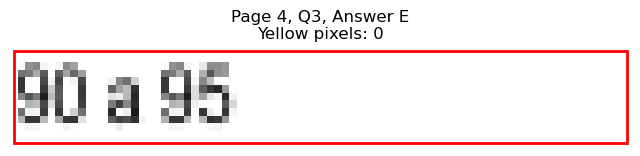


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=70.8, y0=410.4, x1=79.0, y1=422.5
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 57
Page 4, Q4, A: Yellow percentage: 0.0%


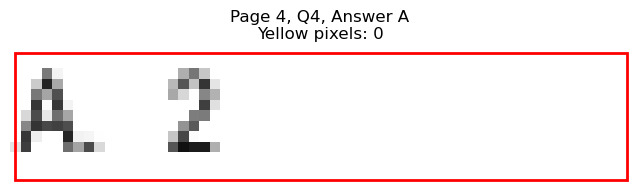

Page 4, Q4 - B: Detected box: x0=85.0, y0=422.4, x1=99.4, y1=434.5
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 65
Page 4, Q4, B: Yellow percentage: 0.0%


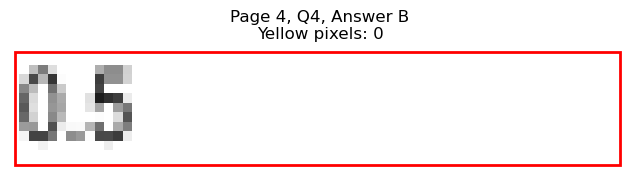

Page 4, Q4 - C: Detected box: x0=85.0, y0=434.4, x1=99.4, y1=446.5
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 52
Page 4, Q4, C: Yellow percentage: 0.0%


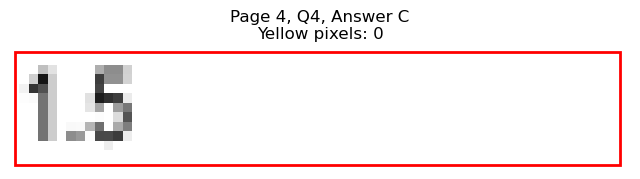

Page 4, Q4 - D: Detected box: x0=322.5, y0=410.4, x1=331.2, y1=422.5
Page 4, Q4, D: Yellow pixels: 52
Page 4, Q4, D: Total non-white pixels: 111
Page 4, Q4, D: Yellow percentage: 46.8%


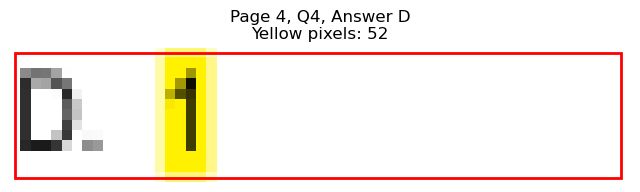

Page 4, Q4 - E: Detected box: x0=336.7, y0=422.4, x1=351.1, y1=434.5
Page 4, Q4, E: Yellow pixels: 4
Page 4, Q4, E: Total non-white pixels: 46
Page 4, Q4, E: Yellow percentage: 8.7%


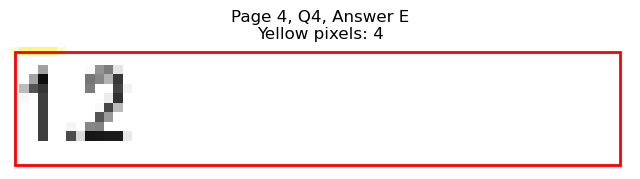


Page 4, Q4 - Selected Answer: D (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=70.8, y0=494.7, x1=79.0, y1=506.8
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 64
Page 4, Q5, A: Yellow percentage: 0.0%


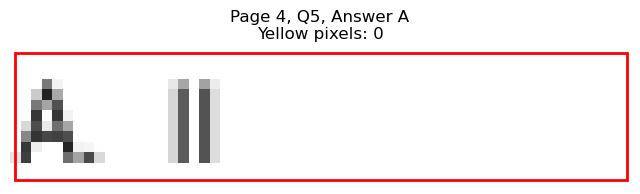

Page 4, Q5 - B: Detected box: x0=85.0, y0=506.8, x1=95.6, y1=518.9
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 42
Page 4, Q5, B: Yellow percentage: 0.0%


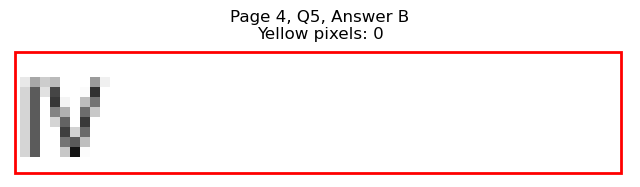

Page 4, Q5 - C: Detected box: x0=85.0, y0=518.8, x1=100.8, y1=530.9
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 78
Page 4, Q5, C: Yellow percentage: 0.0%


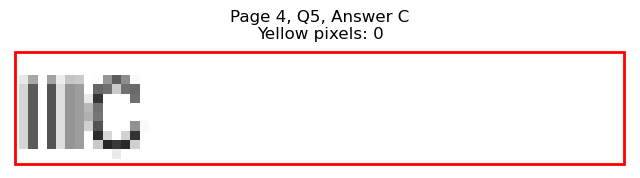

Page 4, Q5 - D: Detected box: x0=336.7, y0=494.7, x1=352.0, y1=506.8
Page 4, Q5, D: Yellow pixels: 84
Page 4, Q5, D: Total non-white pixels: 182
Page 4, Q5, D: Yellow percentage: 46.2%


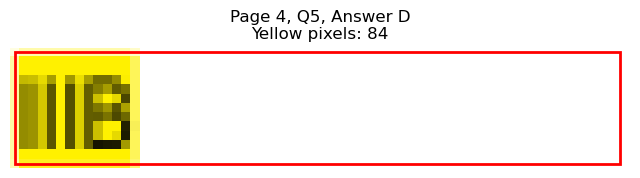

Page 4, Q5 - E: Detected box: x0=336.7, y0=506.8, x1=352.0, y1=518.9
Page 4, Q5, E: Yellow pixels: 13
Page 4, Q5, E: Total non-white pixels: 90
Page 4, Q5, E: Yellow percentage: 14.4%


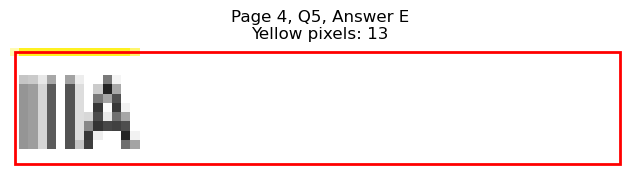


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=85.0, y0=567.1, x1=109.8, y1=579.2
Page 4, Q6, A: Yellow pixels: 180
Page 4, Q6, A: Total non-white pixels: 311
Page 4, Q6, A: Yellow percentage: 57.9%


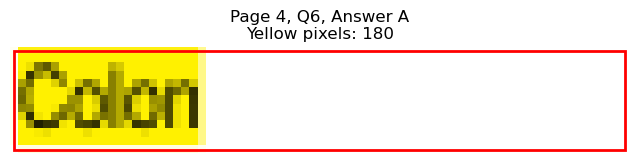

Page 4, Q6 - B: Detected box: x0=85.0, y0=579.1, x1=116.5, y1=591.2
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 160
Page 4, Q6, B: Yellow percentage: 0.0%


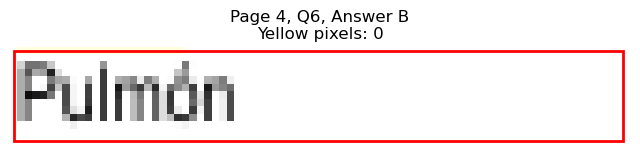

Page 4, Q6 - C: Detected box: x0=85.0, y0=591.2, x1=118.5, y1=603.3
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 162
Page 4, Q6, C: Yellow percentage: 0.0%


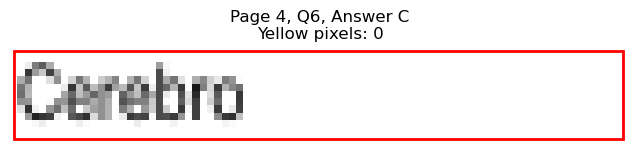

Page 4, Q6 - D: Detected box: x0=336.7, y0=567.1, x1=366.8, y1=579.2
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 170
Page 4, Q6, D: Yellow percentage: 0.0%


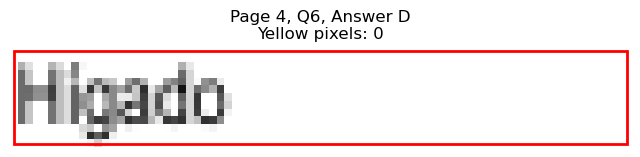

Page 4, Q6 - E: Detected box: x0=336.7, y0=579.1, x1=363.4, y1=591.2
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 135
Page 4, Q6, E: Yellow percentage: 0.0%


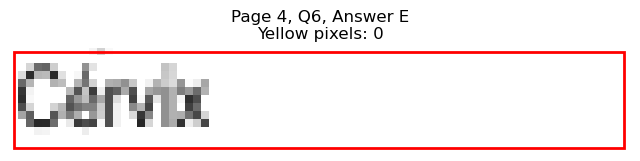


Page 4, Q6 - Selected Answer: A (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=85.0, y0=651.4, x1=126.6, y1=663.5
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 215
Page 4, Q7, A: Yellow percentage: 0.0%


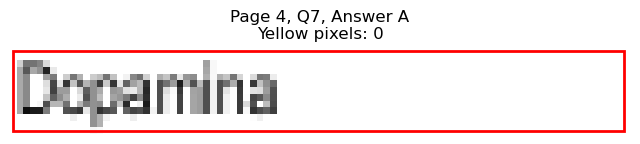

Page 4, Q7 - B: Detected box: x0=85.0, y0=663.4, x1=125.7, y1=675.5
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 213
Page 4, Q7, B: Yellow percentage: 0.0%


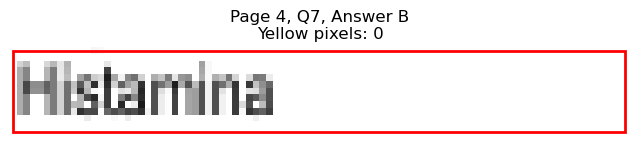

Page 4, Q7 - C: Detected box: x0=85.0, y0=675.4, x1=111.3, y1=687.5
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 131
Page 4, Q7, C: Yellow percentage: 0.0%


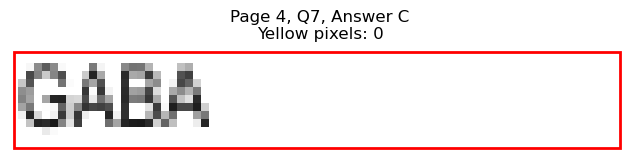

Page 4, Q7 - D: Detected box: x0=336.7, y0=651.4, x1=380.7, y1=663.5
Page 4, Q7, D: Yellow pixels: 43
Page 4, Q7, D: Total non-white pixels: 274
Page 4, Q7, D: Yellow percentage: 15.7%


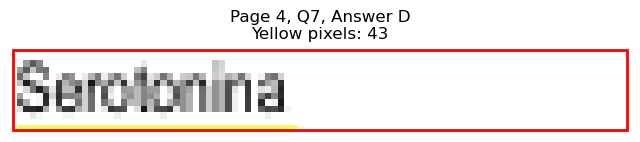

Page 4, Q7 - E: Detected box: x0=336.7, y0=663.4, x1=382.6, y1=675.5
Page 4, Q7, E: Yellow pixels: 373
Page 4, Q7, E: Total non-white pixels: 585
Page 4, Q7, E: Yellow percentage: 63.8%


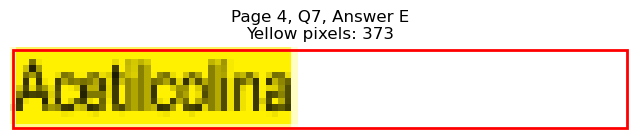


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=85.0, y0=711.7, x1=116.1, y1=723.8
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 223
Page 4, Q8, A: Yellow percentage: 0.0%


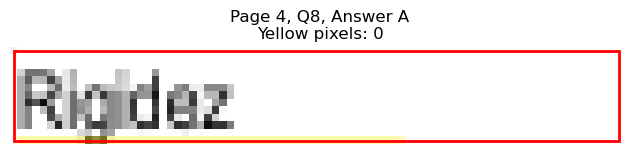

Page 4, Q8 - B: Detected box: x0=85.0, y0=723.7, x1=139.1, y1=735.8
Page 4, Q8, B: Yellow pixels: 392
Page 4, Q8, B: Total non-white pixels: 688
Page 4, Q8, B: Yellow percentage: 57.0%


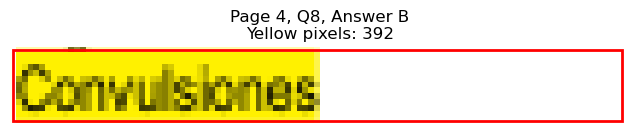

Page 4, Q8 - C: Detected box: x0=85.0, y0=735.8, x1=125.7, y1=747.9
Page 4, Q8, C: Yellow pixels: 52
Page 4, Q8, C: Total non-white pixels: 283
Page 4, Q8, C: Yellow percentage: 18.4%


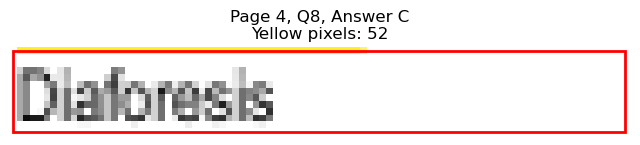

Page 4, Q8 - D: Detected box: x0=336.7, y0=711.7, x1=390.3, y1=723.8
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 301
Page 4, Q8, D: Yellow percentage: 0.0%


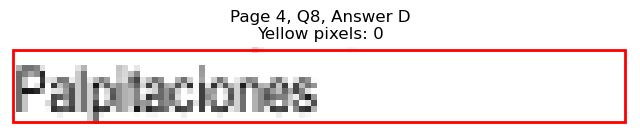

Page 4, Q8 - E: Detected box: x0=336.7, y0=723.7, x1=379.8, y1=735.8
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 209
Page 4, Q8, E: Yellow percentage: 0.0%


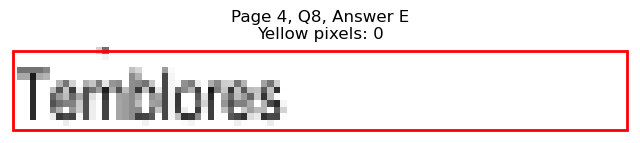


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=116.5, y1=109.2
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 136
Page 5, Q1, A: Yellow percentage: 0.0%


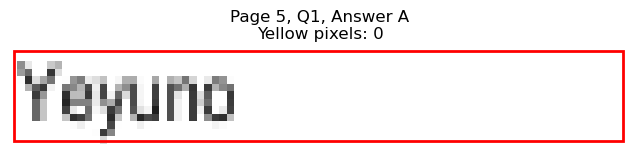

Page 5, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=137.7, y1=121.3
Page 5, Q1, B: Yellow pixels: 395
Page 5, Q1, B: Total non-white pixels: 675
Page 5, Q1, B: Yellow percentage: 58.5%


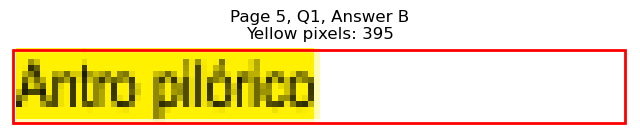

Page 5, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=144.4, y1=133.3
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 356
Page 5, Q1, C: Yellow percentage: 0.0%


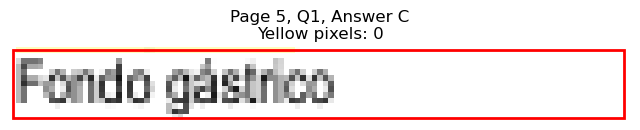

Page 5, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=368.8, y1=109.2
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 163
Page 5, Q1, D: Yellow percentage: 0.0%


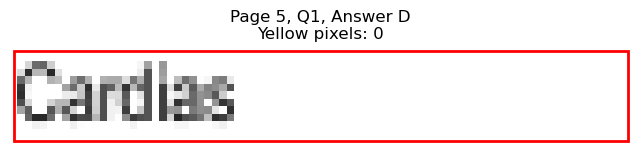

Page 5, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=374.0, y1=121.3
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 188
Page 5, Q1, E: Yellow percentage: 0.0%


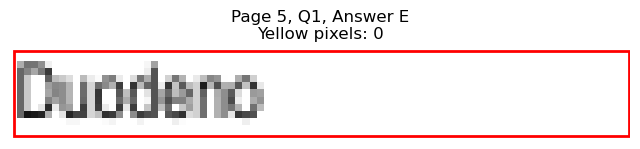


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=138.1, y1=181.5
Page 5, Q2, A: Yellow pixels: 89
Page 5, Q2, A: Total non-white pixels: 373
Page 5, Q2, A: Yellow percentage: 23.9%


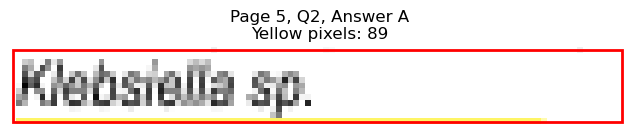

Page 5, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=176.9, y1=193.5
Page 5, Q2, B: Yellow pixels: 799
Page 5, Q2, B: Total non-white pixels: 1183
Page 5, Q2, B: Yellow percentage: 67.5%


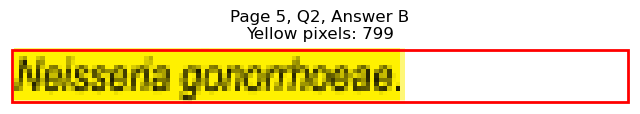

Page 5, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=149.7, y1=205.5
Page 5, Q2, C: Yellow pixels: 89
Page 5, Q2, C: Total non-white pixels: 411
Page 5, Q2, C: Yellow percentage: 21.7%


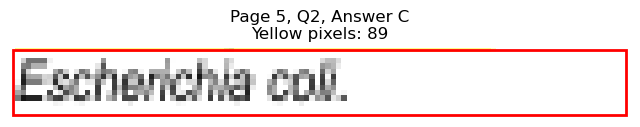

Page 5, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=430.5, y1=181.5
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 461
Page 5, Q2, D: Yellow percentage: 0.0%


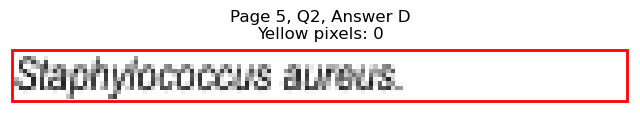

Page 5, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=407.5, y1=193.5
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 357
Page 5, Q2, E: Yellow percentage: 0.0%


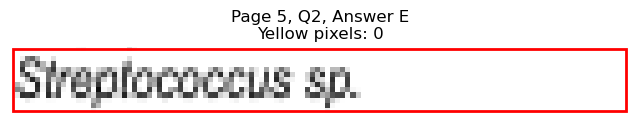


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=85.0, y0=265.8, x1=134.3, y1=277.9
Page 5, Q3, A: Yellow pixels: 365
Page 5, Q3, A: Total non-white pixels: 627
Page 5, Q3, A: Yellow percentage: 58.2%


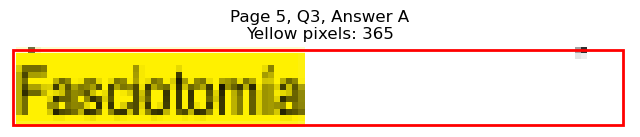

Page 5, Q3 - B: Detected box: x0=85.0, y0=277.8, x1=179.3, y1=289.9
Page 5, Q3, B: Yellow pixels: 47
Page 5, Q3, B: Total non-white pixels: 557
Page 5, Q3, B: Yellow percentage: 8.4%


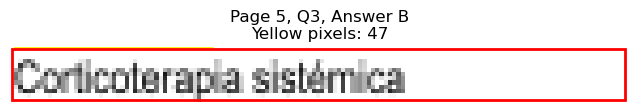

Page 5, Q3 - C: Detected box: x0=85.0, y0=289.9, x1=236.2, y1=302.0
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 759
Page 5, Q3, C: Yellow percentage: 0.0%


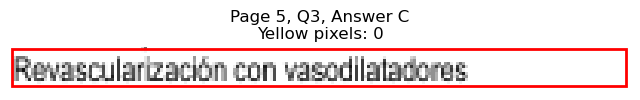

Page 5, Q3 - D: Detected box: x0=336.7, y0=265.8, x1=420.4, y1=277.9
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 457
Page 5, Q3, D: Yellow percentage: 0.0%


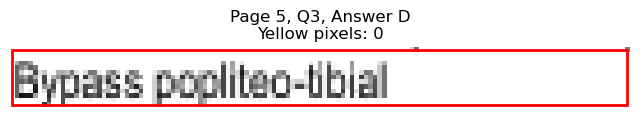

Page 5, Q3 - E: Detected box: x0=336.7, y0=277.8, x1=484.5, y1=289.9
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 758
Page 5, Q3, E: Yellow percentage: 0.0%


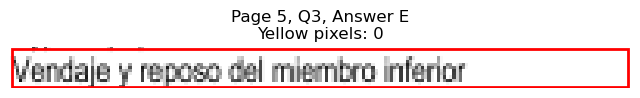


Page 5, Q3 - Selected Answer: A (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=121.3, y1=350.2
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 189
Page 5, Q4, A: Yellow percentage: 0.0%


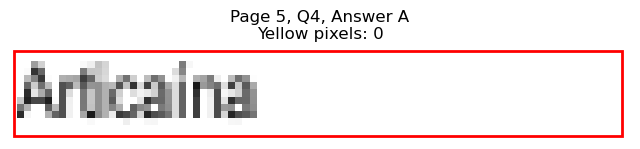

Page 5, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=124.7, y1=362.3
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 189
Page 5, Q4, B: Yellow percentage: 0.0%


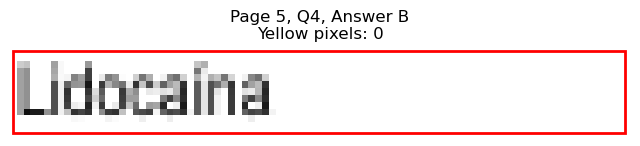

Page 5, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=141.5, y1=374.3
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 272
Page 5, Q4, C: Yellow percentage: 0.0%


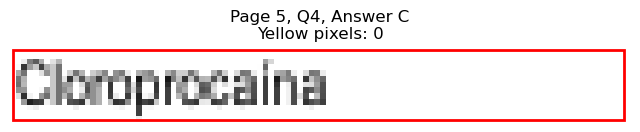

Page 5, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=387.9, y1=350.2
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 271
Page 5, Q4, D: Yellow percentage: 0.0%


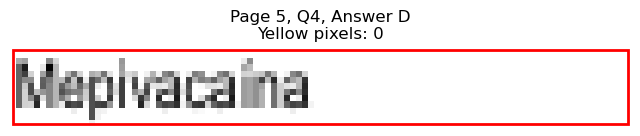

Page 5, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=386.5, y1=362.3
Page 5, Q4, E: Yellow pixels: 360
Page 5, Q4, E: Total non-white pixels: 637
Page 5, Q4, E: Yellow percentage: 56.5%


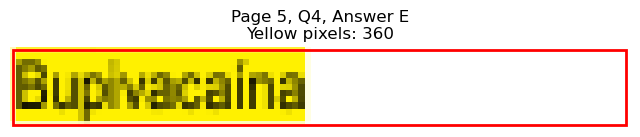


Page 5, Q4 - Selected Answer: E (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=209.0, y1=410.4
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 609
Page 5, Q5, A: Yellow percentage: 0.0%


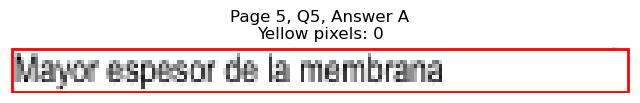

Page 5, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=148.7, y1=422.5
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 350
Page 5, Q5, B: Yellow percentage: 0.0%


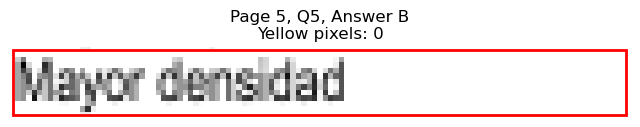

Page 5, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=154.8, y1=434.5
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 366
Page 5, Q5, C: Yellow percentage: 0.0%


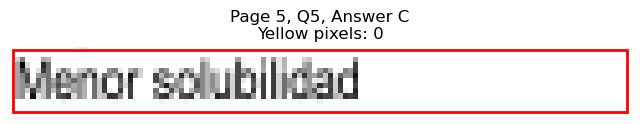

Page 5, Q5 - D: Detected box: x0=336.7, y0=398.3, x1=408.4, y1=410.4
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 357
Page 5, Q5, D: Yellow percentage: 0.0%


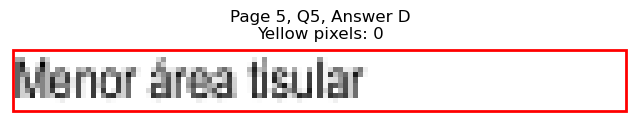

Page 5, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=471.7, y1=422.5
Page 5, Q5, E: Yellow pixels: 1127
Page 5, Q5, E: Total non-white pixels: 1742
Page 5, Q5, E: Yellow percentage: 64.7%


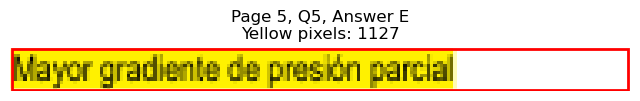


Page 5, Q5 - Selected Answer: E (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=85.0, y0=458.6, x1=276.5, y1=470.7
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 883
Page 5, Q6, A: Yellow percentage: 0.0%


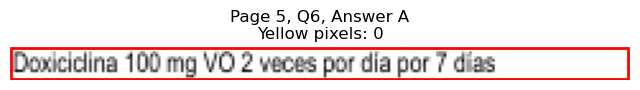

Page 5, Q6 - B: Detected box: x0=85.0, y0=470.7, x1=221.9, y1=482.8
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 694
Page 5, Q6, B: Yellow percentage: 0.0%


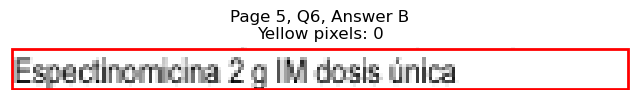

Page 5, Q6 - C: Detected box: x0=85.0, y0=482.7, x1=209.0, y1=494.8
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 586
Page 5, Q6, C: Yellow percentage: 0.0%


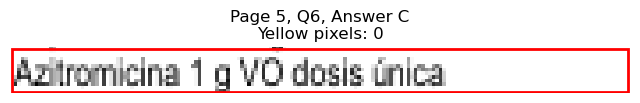

Page 5, Q6 - D: Detected box: x0=85.0, y0=494.7, x1=219.5, y1=506.8
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 679
Page 5, Q6, D: Yellow percentage: 0.0%


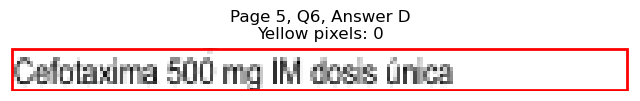

Page 5, Q6 - E: Detected box: x0=85.0, y0=506.8, x1=220.0, y1=518.9
Page 5, Q6, E: Yellow pixels: 1063
Page 5, Q6, E: Total non-white pixels: 1741
Page 5, Q6, E: Yellow percentage: 61.1%


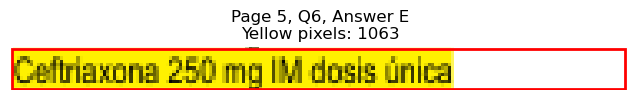


Page 5, Q6 - Selected Answer: E (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=85.0, y0=579.1, x1=183.6, y1=591.2
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 502
Page 5, Q7, A: Yellow percentage: 0.0%


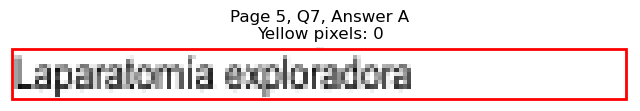

Page 5, Q7 - B: Detected box: x0=85.0, y0=591.2, x1=181.2, y1=603.3
Page 5, Q7, B: Yellow pixels: 147
Page 5, Q7, B: Total non-white pixels: 654
Page 5, Q7, B: Yellow percentage: 22.5%


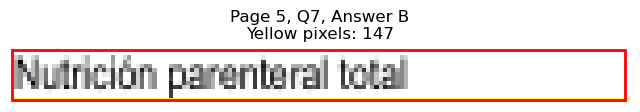

Page 5, Q7 - C: Detected box: x0=85.0, y0=603.2, x1=308.1, y1=615.3
Page 5, Q7, C: Yellow pixels: 1723
Page 5, Q7, C: Total non-white pixels: 2885
Page 5, Q7, C: Yellow percentage: 59.7%


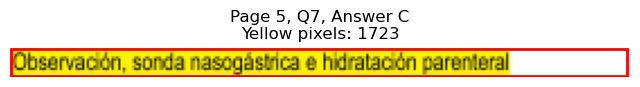

Page 5, Q7 - D: Detected box: x0=85.0, y0=615.2, x1=232.4, y1=627.3
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 962
Page 5, Q7, D: Yellow percentage: 0.0%


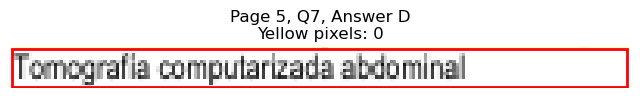

Page 5, Q7 - E: Detected box: x0=85.0, y0=627.3, x1=254.9, y1=639.4
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 847
Page 5, Q7, E: Yellow percentage: 0.0%


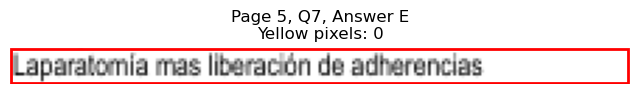


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=85.0, y0=675.4, x1=150.6, y1=687.5
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 344
Page 5, Q8, A: Yellow percentage: 0.0%


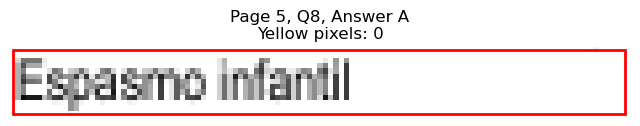

Page 5, Q8 - B: Detected box: x0=85.0, y0=687.5, x1=178.3, y1=699.7
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 493
Page 5, Q8, B: Yellow percentage: 0.0%


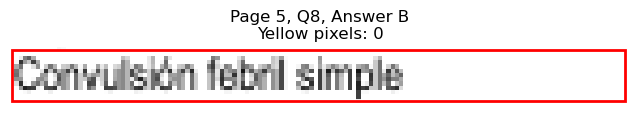

Page 5, Q8 - C: Detected box: x0=85.0, y0=699.5, x1=122.3, y1=711.7
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 207
Page 5, Q8, C: Yellow percentage: 0.0%


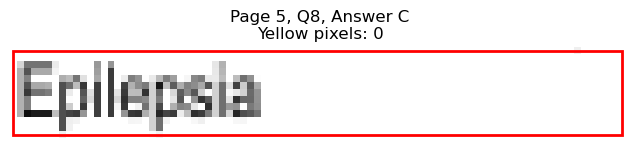

Page 5, Q8 - D: Detected box: x0=336.7, y0=675.4, x1=439.6, y1=687.5
Page 5, Q8, D: Yellow pixels: 892
Page 5, Q8, D: Total non-white pixels: 1326
Page 5, Q8, D: Yellow percentage: 67.3%


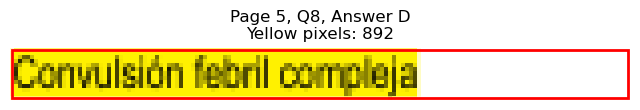

Page 5, Q8 - E: Detected box: x0=336.7, y0=687.5, x1=391.8, y1=699.7
Page 5, Q8, E: Yellow pixels: 100
Page 5, Q8, E: Total non-white pixels: 381
Page 5, Q8, E: Yellow percentage: 26.2%


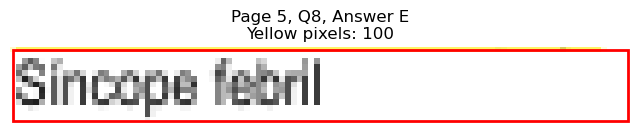


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=85.0, y0=735.8, x1=215.7, y1=747.9
Page 5, Q9, A: Yellow pixels: 993
Page 5, Q9, A: Total non-white pixels: 1692
Page 5, Q9, A: Yellow percentage: 58.7%


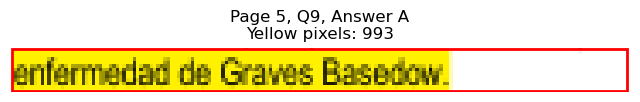

Page 5, Q9 - B: Detected box: x0=85.0, y0=747.8, x1=150.6, y1=759.9
Page 5, Q9, B: Yellow pixels: 116
Page 5, Q9, B: Total non-white pixels: 427
Page 5, Q9, B: Yellow percentage: 27.2%


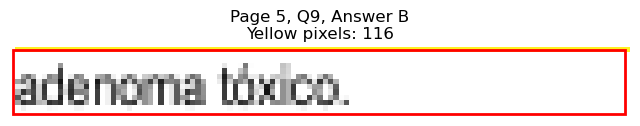

Page 5, Q9 - C: Detected box: x0=85.0, y0=759.8, x1=150.1, y1=771.9
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 302
Page 5, Q9, C: Yellow percentage: 0.0%


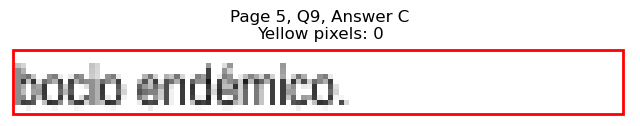

Page 5, Q9 - D: Detected box: x0=336.7, y0=735.8, x1=450.1, y1=747.9
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 558
Page 5, Q9, D: Yellow percentage: 0.0%


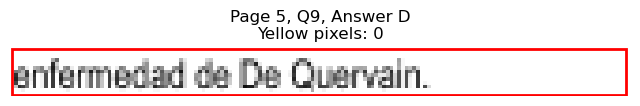

Page 5, Q9 - E: Detected box: x0=336.7, y0=747.8, x1=434.0, y1=759.9
Page 5, Q9, E: Yellow pixels: 0
Page 5, Q9, E: Total non-white pixels: 482
Page 5, Q9, E: Yellow percentage: 0.0%


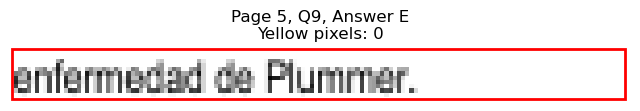


Page 5, Q9 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 8 questions
Page 6, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=129.5, y1=121.3
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 240
Page 6, Q1, A: Yellow percentage: 0.0%


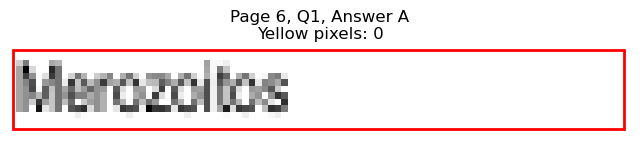

Page 6, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=130.0, y1=133.3
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 231
Page 6, Q1, B: Yellow percentage: 0.0%


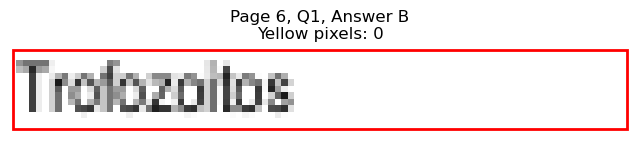

Page 6, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=132.4, y1=145.3
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 251
Page 6, Q1, C: Yellow percentage: 0.0%


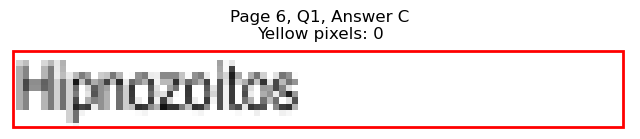

Page 6, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=387.4, y1=121.3
Page 6, Q1, D: Yellow pixels: 52
Page 6, Q1, D: Total non-white pixels: 314
Page 6, Q1, D: Yellow percentage: 16.6%


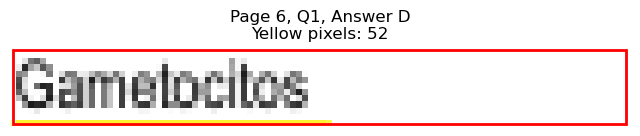

Page 6, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=389.0, y1=133.3
Page 6, Q1, E: Yellow pixels: 402
Page 6, Q1, E: Total non-white pixels: 689
Page 6, Q1, E: Yellow percentage: 58.3%


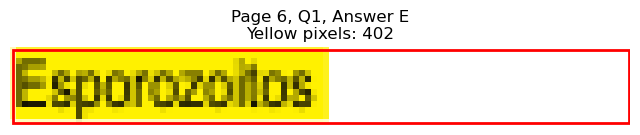


Page 6, Q1 - Selected Answer: E (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=85.0, y0=217.5, x1=201.8, y1=229.7
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 577
Page 6, Q2, A: Yellow percentage: 0.0%


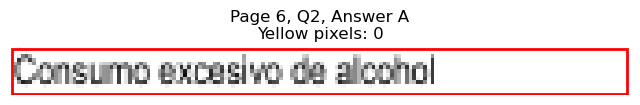

Page 6, Q2 - B: Detected box: x0=85.0, y0=229.7, x1=217.1, y1=241.8
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 688
Page 6, Q2, B: Yellow percentage: 0.0%


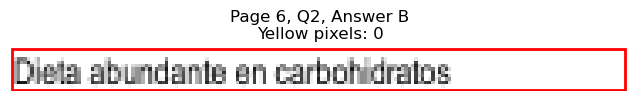

Page 6, Q2 - C: Detected box: x0=85.0, y0=241.7, x1=221.5, y1=253.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 683
Page 6, Q2, C: Yellow percentage: 0.0%


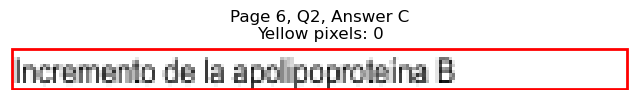

Page 6, Q2 - D: Detected box: x0=336.7, y0=217.5, x1=503.7, y1=229.7
Page 6, Q2, D: Yellow pixels: 1459
Page 6, Q2, D: Total non-white pixels: 2158
Page 6, Q2, D: Yellow percentage: 67.6%


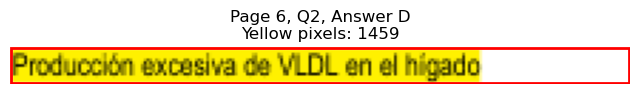

Page 6, Q2 - E: Detected box: x0=336.7, y0=229.7, x1=460.7, y1=241.8
Page 6, Q2, E: Yellow pixels: 163
Page 6, Q2, E: Total non-white pixels: 756
Page 6, Q2, E: Yellow percentage: 21.6%


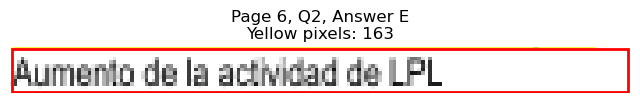


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=85.0, y0=301.9, x1=144.4, y1=314.0
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 301
Page 6, Q3, A: Yellow percentage: 0.0%


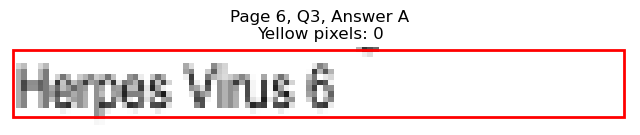

Page 6, Q3 - B: Detected box: x0=85.0, y0=313.9, x1=141.0, y1=326.0
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 290
Page 6, Q3, B: Yellow percentage: 0.0%


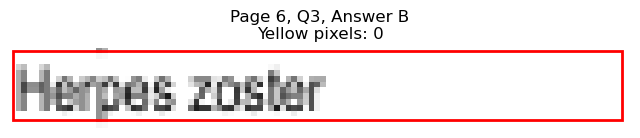

Page 6, Q3 - C: Detected box: x0=85.0, y0=326.1, x1=142.0, y1=338.2
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 274
Page 6, Q3, C: Yellow percentage: 0.0%


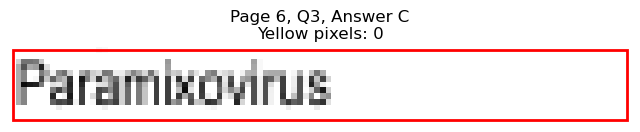

Page 6, Q3 - D: Detected box: x0=336.7, y0=301.9, x1=397.5, y1=314.0
Page 6, Q3, D: Yellow pixels: 466
Page 6, Q3, D: Total non-white pixels: 779
Page 6, Q3, D: Yellow percentage: 59.8%


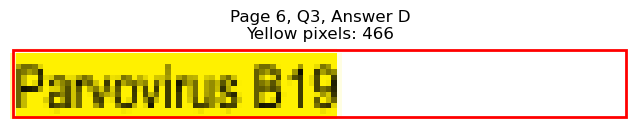

Page 6, Q3 - E: Detected box: x0=336.7, y0=313.9, x1=385.5, y1=326.0
Page 6, Q3, E: Yellow pixels: 58
Page 6, Q3, E: Total non-white pixels: 300
Page 6, Q3, E: Yellow percentage: 19.3%


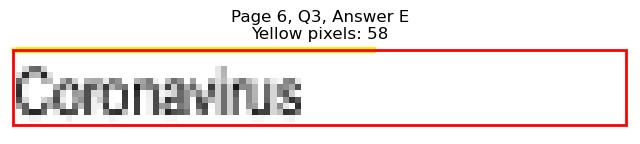


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=85.0, y0=386.3, x1=150.6, y1=398.4
Page 6, Q4, A: Yellow pixels: 111
Page 6, Q4, A: Total non-white pixels: 442
Page 6, Q4, A: Yellow percentage: 25.1%


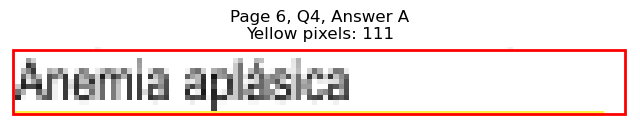

Page 6, Q4 - B: Detected box: x0=85.0, y0=398.3, x1=198.5, y1=410.4
Page 6, Q4, B: Yellow pixels: 1005
Page 6, Q4, B: Total non-white pixels: 1469
Page 6, Q4, B: Yellow percentage: 68.4%


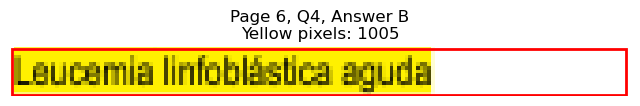

Page 6, Q4 - C: Detected box: x0=85.0, y0=410.4, x1=185.5, y1=422.5
Page 6, Q4, C: Yellow pixels: 111
Page 6, Q4, C: Total non-white pixels: 626
Page 6, Q4, C: Yellow percentage: 17.7%


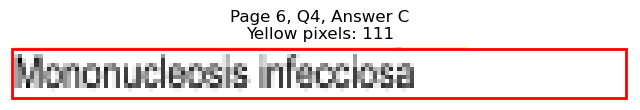

Page 6, Q4 - D: Detected box: x0=336.7, y0=386.3, x1=440.6, y1=398.4
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 525
Page 6, Q4, D: Yellow percentage: 0.0%


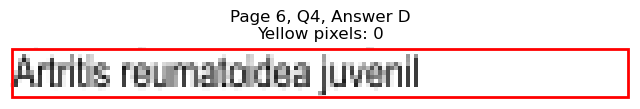

Page 6, Q4 - E: Detected box: x0=336.7, y0=398.3, x1=432.0, y1=410.4
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 498
Page 6, Q4, E: Yellow percentage: 0.0%


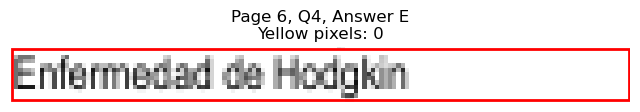


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=85.0, y0=458.6, x1=121.3, y1=470.7
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 205
Page 6, Q5, A: Yellow percentage: 0.0%


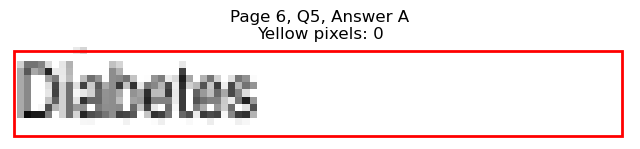

Page 6, Q5 - B: Detected box: x0=85.0, y0=470.7, x1=118.9, y1=482.8
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 217
Page 6, Q5, B: Yellow percentage: 0.0%


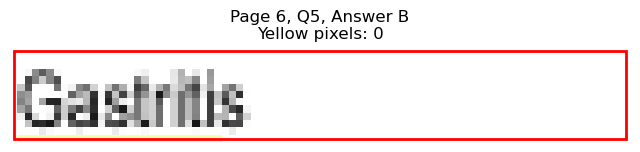

Page 6, Q5 - C: Detected box: x0=85.0, y0=482.7, x1=115.6, y1=494.8
Page 6, Q5, C: Yellow pixels: 225
Page 6, Q5, C: Total non-white pixels: 389
Page 6, Q5, C: Yellow percentage: 57.8%


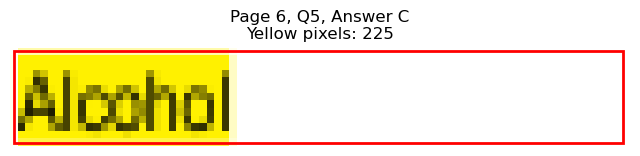

Page 6, Q5 - D: Detected box: x0=336.7, y0=458.6, x1=375.9, y1=470.7
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 207
Page 6, Q5, D: Yellow percentage: 0.0%


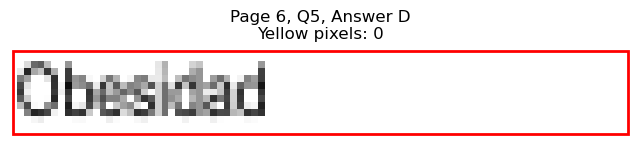

Page 6, Q5 - E: Detected box: x0=336.7, y0=470.7, x1=387.0, y1=482.8
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 263
Page 6, Q5, E: Yellow percentage: 0.0%


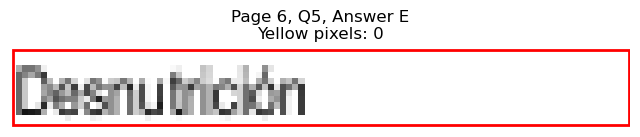


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=85.0, y0=542.9, x1=151.6, y1=555.0
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 355
Page 6, Q6, A: Yellow percentage: 0.0%


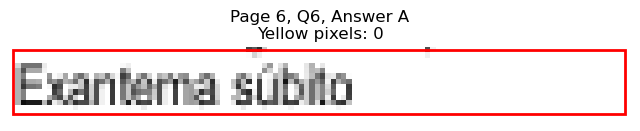

Page 6, Q6 - B: Detected box: x0=85.0, y0=554.9, x1=157.7, y1=567.0
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 378
Page 6, Q6, B: Yellow percentage: 0.0%


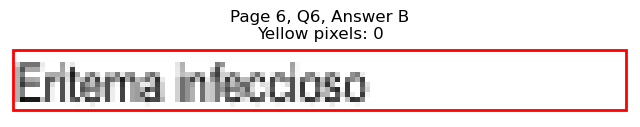

Page 6, Q6 - C: Detected box: x0=85.0, y0=567.1, x1=129.0, y1=579.2
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 226
Page 6, Q6, C: Yellow percentage: 0.0%


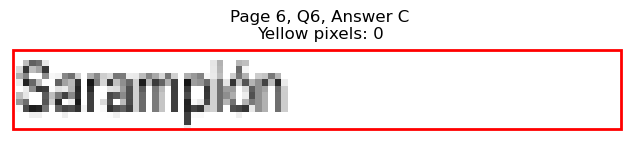

Page 6, Q6 - D: Detected box: x0=336.7, y0=542.9, x1=437.2, y1=555.0
Page 6, Q6, D: Yellow pixels: 736
Page 6, Q6, D: Total non-white pixels: 1287
Page 6, Q6, D: Yellow percentage: 57.2%


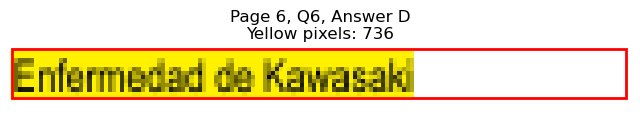

Page 6, Q6 - E: Detected box: x0=336.7, y0=554.9, x1=381.7, y1=567.0
Page 6, Q6, E: Yellow pixels: 95
Page 6, Q6, E: Total non-white pixels: 330
Page 6, Q6, E: Yellow percentage: 28.8%


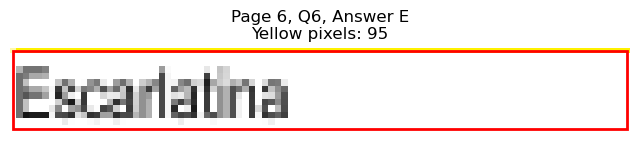


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=85.0, y0=627.3, x1=212.8, y1=639.4
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 679
Page 6, Q7, A: Yellow percentage: 0.0%


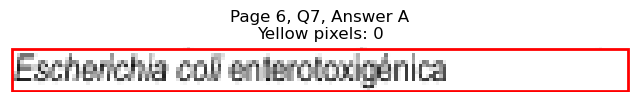

Page 6, Q7 - B: Detected box: x0=85.0, y0=639.3, x1=144.9, y1=651.4
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 321
Page 6, Q7, B: Yellow percentage: 0.0%


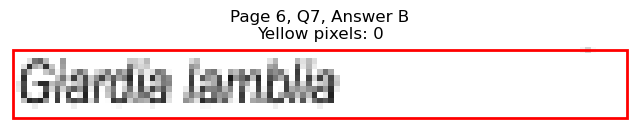

Page 6, Q7 - C: Detected box: x0=85.0, y0=651.4, x1=221.5, y1=663.5
Page 6, Q7, C: Yellow pixels: 1184
Page 6, Q7, C: Total non-white pixels: 1768
Page 6, Q7, C: Yellow percentage: 67.0%


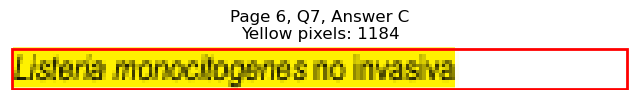

Page 6, Q7 - D: Detected box: x0=336.7, y0=627.3, x1=473.6, y1=639.4
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 705
Page 6, Q7, D: Yellow percentage: 0.0%


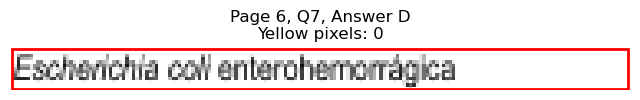

Page 6, Q7 - E: Detected box: x0=336.7, y0=639.3, x1=428.1, y1=651.4
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 460
Page 6, Q7, E: Yellow percentage: 0.0%


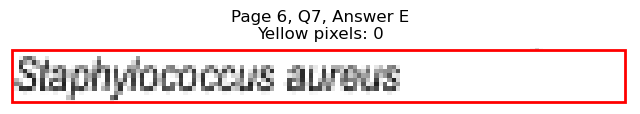


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=70.8, y0=711.7, x1=79.0, y1=723.8
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 107
Page 6, Q8, A: Yellow percentage: 0.0%


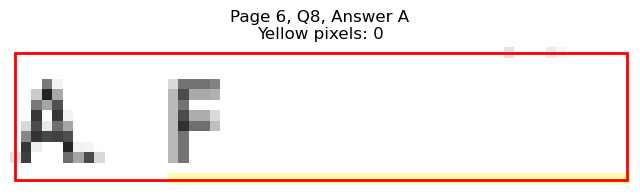

Page 6, Q8 - B: Detected box: x0=85.0, y0=723.7, x1=133.8, y1=735.8
Page 6, Q8, B: Yellow pixels: 376
Page 6, Q8, B: Total non-white pixels: 623
Page 6, Q8, B: Yellow percentage: 60.4%


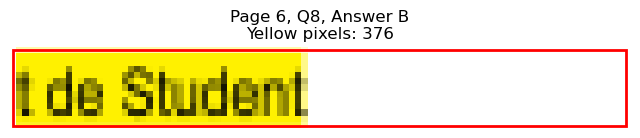

Page 6, Q8 - C: Detected box: x0=70.8, y0=735.8, x1=79.5, y1=747.9
Page 6, Q8, C: Yellow pixels: 45
Page 6, Q8, C: Total non-white pixels: 108
Page 6, Q8, C: Yellow percentage: 41.7%


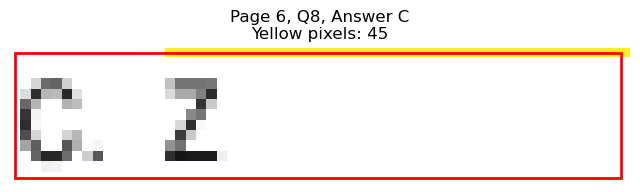

Page 6, Q8 - D: Detected box: x0=336.7, y0=711.7, x1=372.1, y1=723.8
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 191
Page 6, Q8, D: Yellow percentage: 0.0%


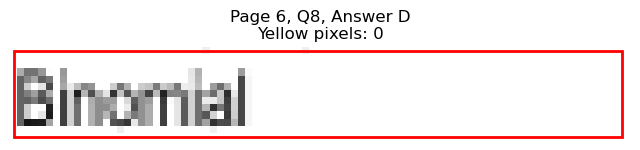

Page 6, Q8 - E: Detected box: x0=336.7, y0=723.7, x1=390.3, y1=735.8
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 276
Page 6, Q8, E: Yellow percentage: 0.0%


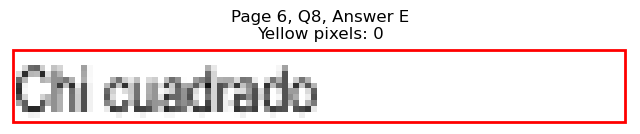


Page 6, Q8 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 8 questions
Page 7, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=130.9, y1=121.3
Page 7, Q1, A: Yellow pixels: 33
Page 7, Q1, A: Total non-white pixels: 271
Page 7, Q1, A: Yellow percentage: 12.2%


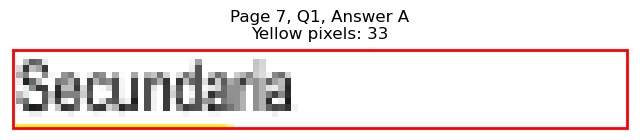

Page 7, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=120.9, y1=133.3
Page 7, Q1, B: Yellow pixels: 260
Page 7, Q1, B: Total non-white pixels: 454
Page 7, Q1, B: Yellow percentage: 57.3%


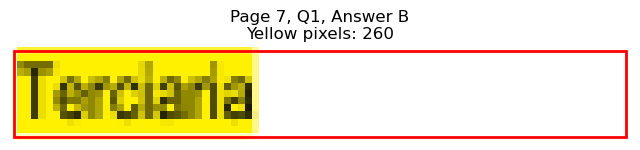

Page 7, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=119.4, y1=145.3
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 200
Page 7, Q1, C: Yellow percentage: 0.0%


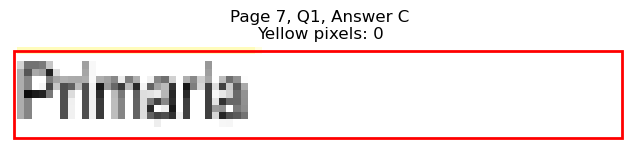

Page 7, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=377.8, y1=121.3
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 212
Page 7, Q1, D: Yellow percentage: 0.0%


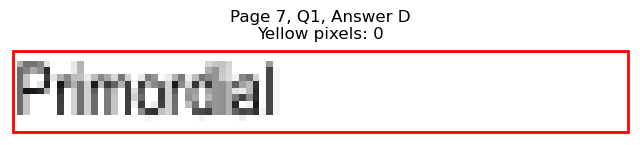

Page 7, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=384.1, y1=133.3
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 244
Page 7, Q1, E: Yellow percentage: 0.0%


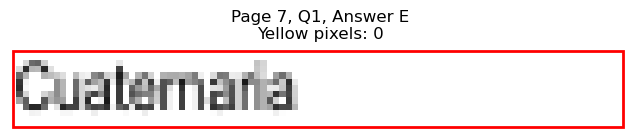


Page 7, Q1 - Selected Answer: B (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=115.6, y1=193.5
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 160
Page 7, Q2, A: Yellow percentage: 0.0%


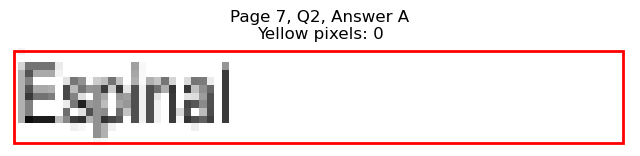

Page 7, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=118.9, y1=205.5
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 185
Page 7, Q2, B: Yellow percentage: 0.0%


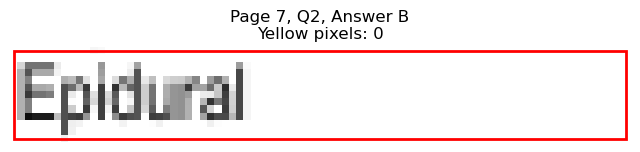

Page 7, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=200.3, y1=217.7
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 564
Page 7, Q2, C: Yellow percentage: 0.0%


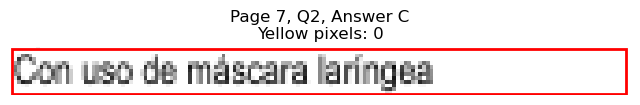

Page 7, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=369.7, y1=193.5
Page 7, Q2, D: Yellow pixels: 257
Page 7, Q2, D: Total non-white pixels: 416
Page 7, Q2, D: Yellow percentage: 61.8%


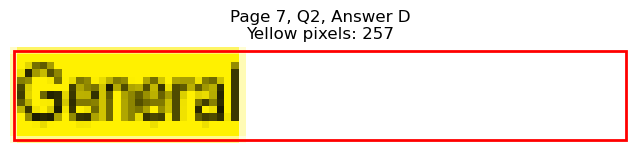

Page 7, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=434.4, y1=205.5
Page 7, Q2, E: Yellow pixels: 30
Page 7, Q2, E: Total non-white pixels: 508
Page 7, Q2, E: Yellow percentage: 5.9%


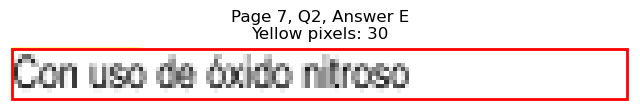


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=85.0, y0=277.8, x1=196.6, y1=289.9
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 640
Page 7, Q3, A: Yellow percentage: 0.0%


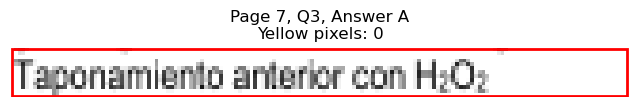

Page 7, Q3 - B: Detected box: x0=85.0, y0=289.9, x1=160.1, y1=302.0
Page 7, Q3, B: Yellow pixels: 91
Page 7, Q3, B: Total non-white pixels: 576
Page 7, Q3, B: Yellow percentage: 15.8%


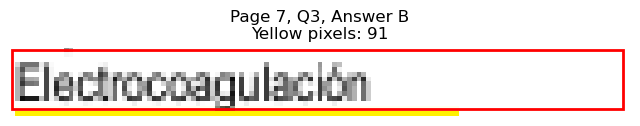

Page 7, Q3 - C: Detected box: x0=85.0, y0=301.9, x1=178.3, y1=314.0
Page 7, Q3, C: Yellow pixels: 723
Page 7, Q3, C: Total non-white pixels: 1200
Page 7, Q3, C: Yellow percentage: 60.2%


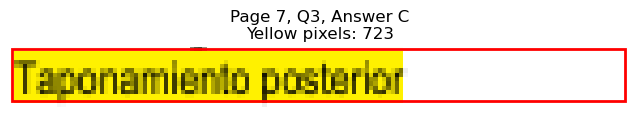

Page 7, Q3 - D: Detected box: x0=336.7, y0=277.8, x1=441.6, y1=289.9
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 549
Page 7, Q3, D: Yellow percentage: 0.0%


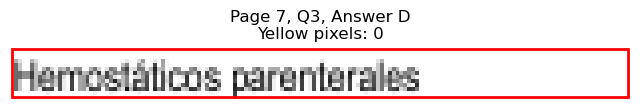

Page 7, Q3 - E: Detected box: x0=336.7, y0=289.9, x1=424.3, y1=302.0
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 428
Page 7, Q3, E: Yellow percentage: 0.0%


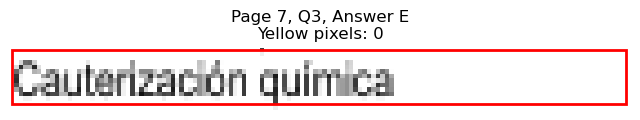


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=85.0, y0=350.2, x1=353.1, y1=362.3
Page 7, Q4, A: Yellow pixels: 248
Page 7, Q4, A: Total non-white pixels: 1551
Page 7, Q4, A: Yellow percentage: 16.0%


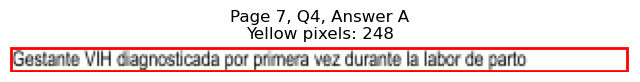

Page 7, Q4 - B: Detected box: x0=85.0, y0=362.2, x1=335.8, y1=374.3
Page 7, Q4, B: Yellow pixels: 1974
Page 7, Q4, B: Total non-white pixels: 3249
Page 7, Q4, B: Yellow percentage: 60.8%


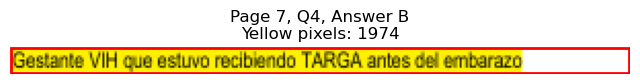

Page 7, Q4 - C: Detected box: x0=85.0, y0=374.2, x1=321.4, y1=386.3
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 1404
Page 7, Q4, C: Yellow percentage: 0.0%


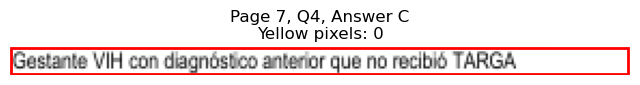

Page 7, Q4 - D: Detected box: x0=85.0, y0=386.3, x1=372.7, y1=398.4
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 1424
Page 7, Q4, D: Yellow percentage: 0.0%


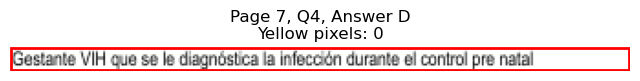

Page 7, Q4 - E: Detected box: x0=85.0, y0=398.3, x1=265.0, y1=410.4
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 889
Page 7, Q4, E: Yellow percentage: 0.0%


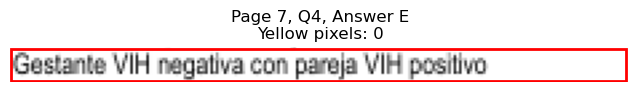


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=85.0, y0=434.4, x1=170.7, y1=446.5
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 433
Page 7, Q5, A: Yellow percentage: 0.0%


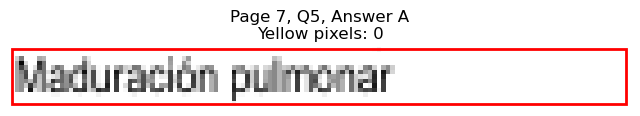

Page 7, Q5 - B: Detected box: x0=85.0, y0=446.6, x1=120.4, y1=458.7
Page 7, Q5, B: Yellow pixels: 280
Page 7, Q5, B: Total non-white pixels: 443
Page 7, Q5, B: Yellow percentage: 63.2%


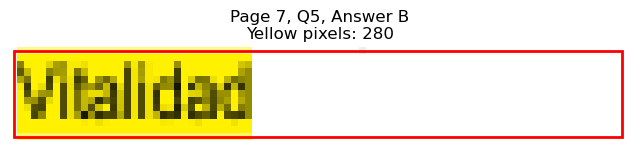

Page 7, Q5 - C: Detected box: x0=85.0, y0=458.6, x1=153.5, y1=470.7
Page 7, Q5, C: Yellow pixels: 33
Page 7, Q5, C: Total non-white pixels: 389
Page 7, Q5, C: Yellow percentage: 8.5%


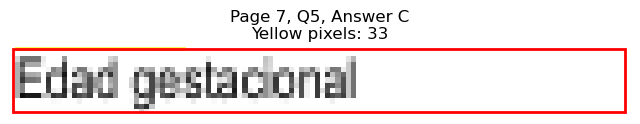

Page 7, Q5 - D: Detected box: x0=336.7, y0=434.4, x1=412.8, y1=446.5
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 394
Page 7, Q5, D: Yellow percentage: 0.0%


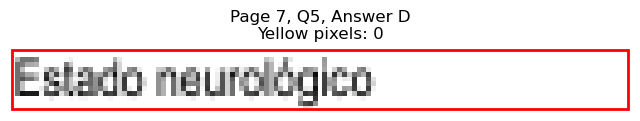

Page 7, Q5 - E: Detected box: x0=336.7, y0=446.6, x1=391.3, y1=458.7
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 291
Page 7, Q5, E: Yellow percentage: 0.0%


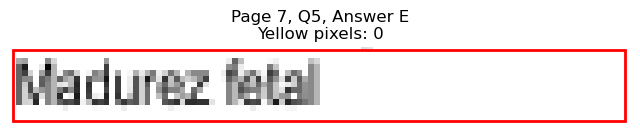


Page 7, Q5 - Selected Answer: B (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=85.0, y0=518.8, x1=109.0, y1=530.9
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 129
Page 7, Q6, A: Yellow percentage: 0.0%


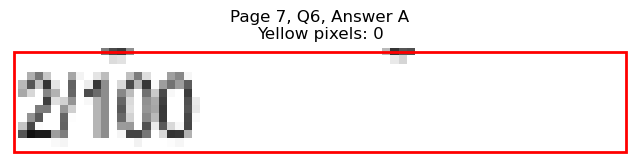

Page 7, Q6 - B: Detected box: x0=85.0, y0=530.9, x1=109.0, y1=543.0
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 123
Page 7, Q6, B: Yellow percentage: 0.0%


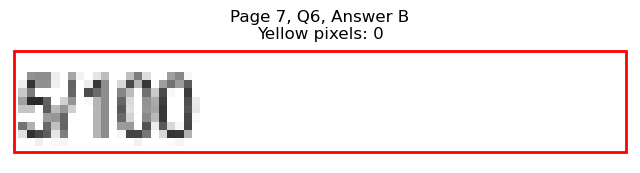

Page 7, Q6 - C: Detected box: x0=85.0, y0=542.9, x1=109.0, y1=555.0
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 127
Page 7, Q6, C: Yellow percentage: 0.0%


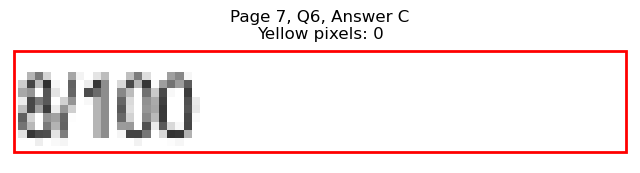

Page 7, Q6 - D: Detected box: x0=336.7, y0=518.8, x1=360.7, y1=530.9
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 106
Page 7, Q6, D: Yellow percentage: 0.0%


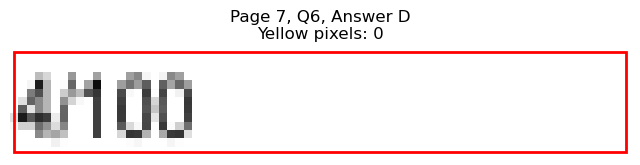

Page 7, Q6 - E: Detected box: x0=336.7, y0=530.9, x1=360.7, y1=543.0
Page 7, Q6, E: Yellow pixels: 178
Page 7, Q6, E: Total non-white pixels: 298
Page 7, Q6, E: Yellow percentage: 59.7%


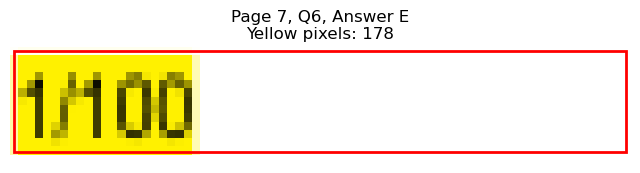


Page 7, Q6 - Selected Answer: E (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=85.0, y0=615.2, x1=156.7, y1=627.3
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 370
Page 7, Q7, A: Yellow percentage: 0.0%


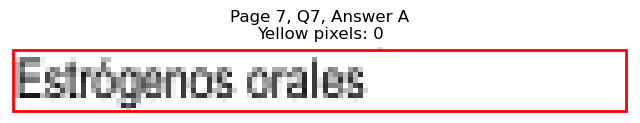

Page 7, Q7 - B: Detected box: x0=85.0, y0=627.3, x1=170.2, y1=639.4
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 450
Page 7, Q7, B: Yellow percentage: 0.0%


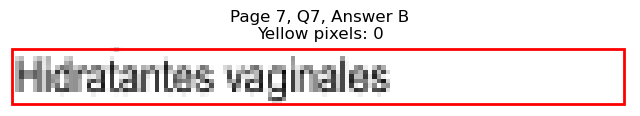

Page 7, Q7 - C: Detected box: x0=85.0, y0=639.3, x1=144.4, y1=651.4
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 320
Page 7, Q7, C: Yellow percentage: 0.0%


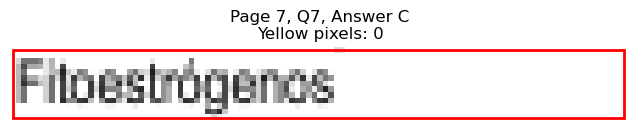

Page 7, Q7 - D: Detected box: x0=336.7, y0=615.2, x1=412.3, y1=627.3
Page 7, Q7, D: Yellow pixels: 563
Page 7, Q7, D: Total non-white pixels: 962
Page 7, Q7, D: Yellow percentage: 58.5%


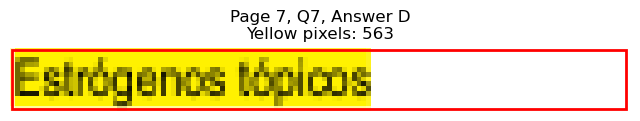

Page 7, Q7 - E: Detected box: x0=336.7, y0=627.3, x1=432.9, y1=639.4
Page 7, Q7, E: Yellow pixels: 3
Page 7, Q7, E: Total non-white pixels: 580
Page 7, Q7, E: Yellow percentage: 0.5%


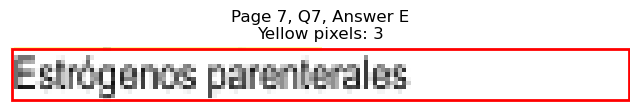


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=85.0, y0=687.5, x1=125.7, y1=699.7
Page 7, Q8, A: Yellow pixels: 328
Page 7, Q8, A: Total non-white pixels: 520
Page 7, Q8, A: Yellow percentage: 63.1%


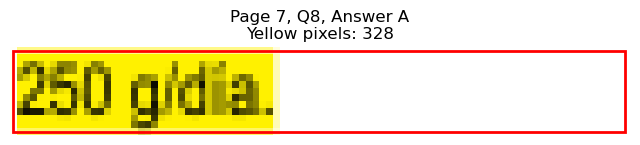

Page 7, Q8 - B: Detected box: x0=85.0, y0=699.5, x1=125.7, y1=711.7
Page 7, Q8, B: Yellow pixels: 38
Page 7, Q8, B: Total non-white pixels: 231
Page 7, Q8, B: Yellow percentage: 16.5%


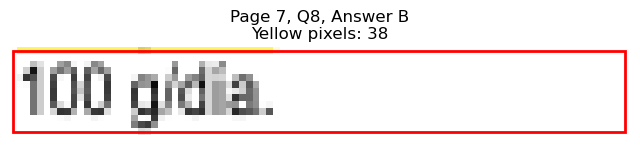

Page 7, Q8 - C: Detected box: x0=85.0, y0=711.7, x1=125.7, y1=723.8
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 195
Page 7, Q8, C: Yellow percentage: 0.0%


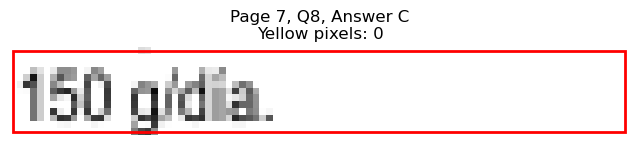

Page 7, Q8 - D: Detected box: x0=336.7, y0=687.5, x1=372.6, y1=699.7
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 168
Page 7, Q8, D: Yellow percentage: 0.0%


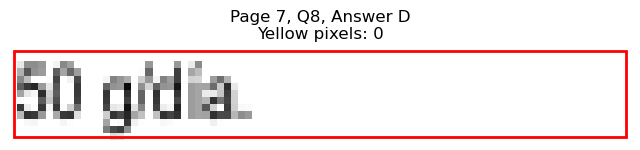

Page 7, Q8 - E: Detected box: x0=336.7, y0=699.5, x1=375.1, y1=711.7
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 203
Page 7, Q8, E: Yellow percentage: 0.0%


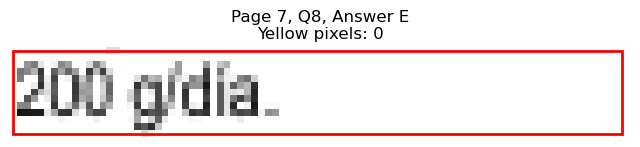


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)





Page 8: Found 8 questions
Page 8, Q1 - A: Detected box: x0=85.0, y0=133.2, x1=187.0, y1=145.3
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 539
Page 8, Q1, A: Yellow percentage: 0.0%


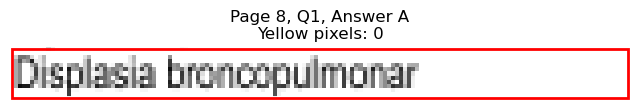

Page 8, Q1 - B: Detected box: x0=85.0, y0=145.3, x1=162.0, y1=157.4
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 397
Page 8, Q1, B: Yellow percentage: 0.0%


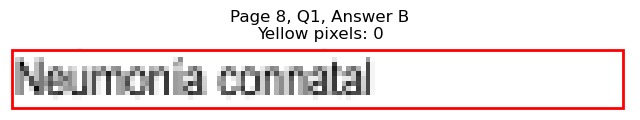

Page 8, Q1 - C: Detected box: x0=85.0, y0=157.3, x1=166.3, y1=169.4
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 438
Page 8, Q1, C: Yellow percentage: 0.0%


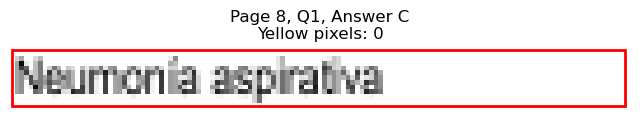

Page 8, Q1 - D: Detected box: x0=336.7, y0=133.2, x1=424.8, y1=145.3
Page 8, Q1, D: Yellow pixels: 656
Page 8, Q1, D: Total non-white pixels: 1131
Page 8, Q1, D: Yellow percentage: 58.0%


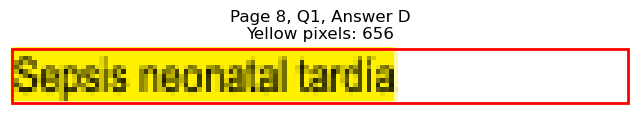

Page 8, Q1 - E: Detected box: x0=336.7, y0=145.3, x1=439.2, y1=157.4
Page 8, Q1, E: Yellow pixels: 1
Page 8, Q1, E: Total non-white pixels: 614
Page 8, Q1, E: Yellow percentage: 0.2%


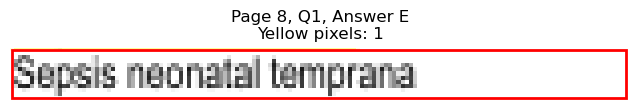


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=128.1, y1=205.5
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 251
Page 8, Q2, A: Yellow percentage: 0.0%


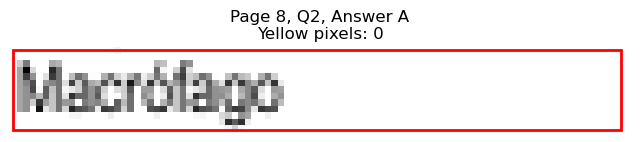

Page 8, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=130.5, y1=217.7
Page 8, Q2, B: Yellow pixels: 33
Page 8, Q2, B: Total non-white pixels: 282
Page 8, Q2, B: Yellow percentage: 11.7%


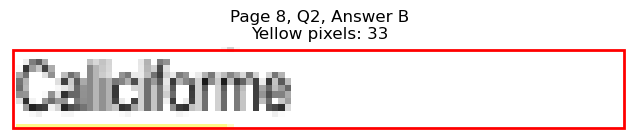

Page 8, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=118.6, y1=229.7
Page 8, Q2, C: Yellow pixels: 310
Page 8, Q2, C: Total non-white pixels: 455
Page 8, Q2, C: Yellow percentage: 68.1%


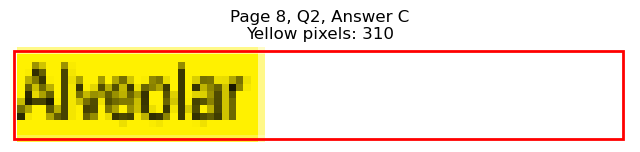

Page 8, Q2 - D: Detected box: x0=336.7, y0=193.4, x1=383.1, y1=205.5
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 236
Page 8, Q2, D: Yellow percentage: 0.0%


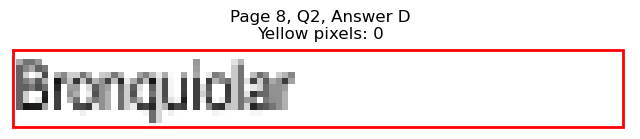

Page 8, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=365.4, y1=217.7
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 164
Page 8, Q2, E: Yellow percentage: 0.0%


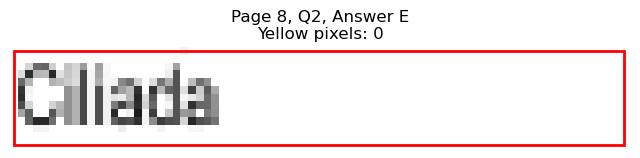


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=85.0, y0=313.9, x1=155.4, y1=326.0
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 390
Page 8, Q3, A: Yellow percentage: 0.0%


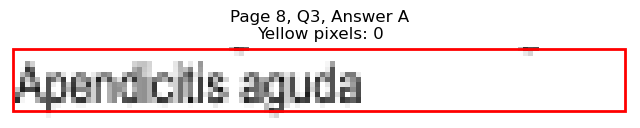

Page 8, Q3 - B: Detected box: x0=85.0, y0=326.1, x1=145.8, y1=338.2
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 318
Page 8, Q3, B: Yellow percentage: 0.0%


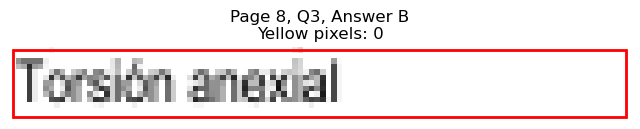

Page 8, Q3 - C: Detected box: x0=85.0, y0=338.1, x1=178.3, y1=350.2
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 470
Page 8, Q3, C: Yellow percentage: 0.0%


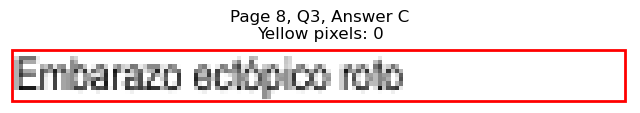

Page 8, Q3 - D: Detected box: x0=336.7, y0=313.9, x1=411.8, y1=326.0
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 397
Page 8, Q3, D: Yellow percentage: 0.0%


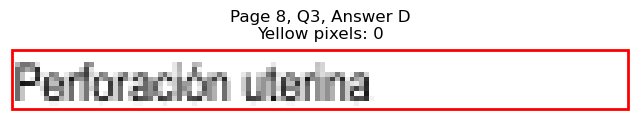

Page 8, Q3 - E: Detected box: x0=336.7, y0=326.1, x1=421.9, y1=338.2
Page 8, Q3, E: Yellow pixels: 694
Page 8, Q3, E: Total non-white pixels: 1092
Page 8, Q3, E: Yellow percentage: 63.6%


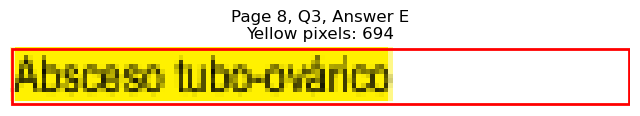


Page 8, Q3 - Selected Answer: E (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=85.0, y0=398.3, x1=169.2, y1=410.4
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 428
Page 8, Q4, A: Yellow percentage: 0.0%


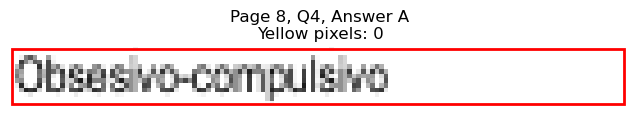

Page 8, Q4 - B: Detected box: x0=85.0, y0=410.4, x1=175.0, y1=422.5
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 484
Page 8, Q4, B: Yellow percentage: 0.0%


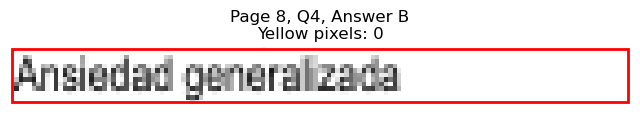

Page 8, Q4 - C: Detected box: x0=85.0, y0=422.4, x1=155.8, y1=434.5
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 366
Page 8, Q4, C: Yellow percentage: 0.0%


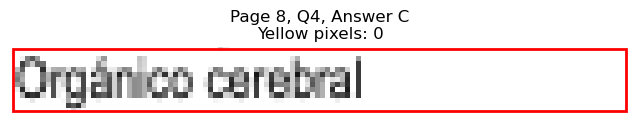

Page 8, Q4 - D: Detected box: x0=336.7, y0=398.3, x1=391.8, y1=410.4
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 283
Page 8, Q4, D: Yellow percentage: 0.0%


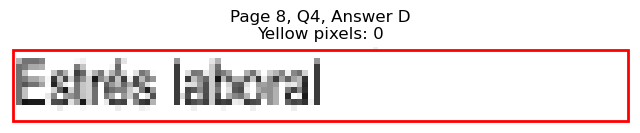

Page 8, Q4 - E: Detected box: x0=336.7, y0=410.4, x1=404.6, y1=422.5
Page 8, Q4, E: Yellow pixels: 578
Page 8, Q4, E: Total non-white pixels: 871
Page 8, Q4, E: Yellow percentage: 66.4%


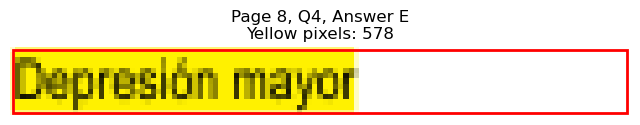


Page 8, Q4 - Selected Answer: E (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=85.0, y0=133.2, x1=187.0, y1=145.3
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 539
Page 8, Q5, A: Yellow percentage: 0.0%


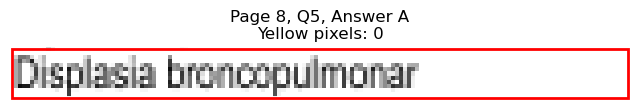

Page 8, Q5 - B: Detected box: x0=85.0, y0=145.3, x1=162.0, y1=157.4
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 397
Page 8, Q5, B: Yellow percentage: 0.0%


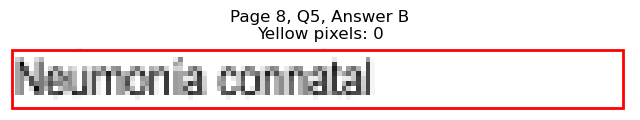

Page 8, Q5 - C: Detected box: x0=85.0, y0=506.8, x1=168.9, y1=518.9
Page 8, Q5, C: Yellow pixels: 650
Page 8, Q5, C: Total non-white pixels: 1104
Page 8, Q5, C: Yellow percentage: 58.9%


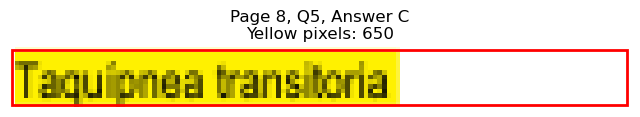

Page 8, Q5 - D: Detected box: x0=336.7, y0=482.7, x1=423.3, y1=494.8
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 478
Page 8, Q5, D: Yellow percentage: 0.0%


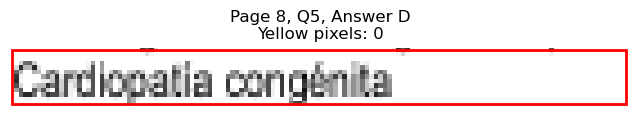

Page 8, Q5 - E: Detected box: x0=336.7, y0=494.7, x1=466.4, y1=506.8
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 661
Page 8, Q5, E: Yellow percentage: 0.0%


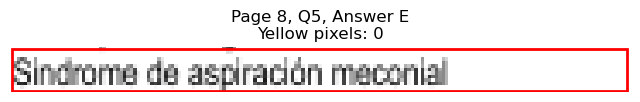


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=85.0, y0=542.9, x1=195.1, y1=555.0
Page 8, Q6, A: Yellow pixels: 71
Page 8, Q6, A: Total non-white pixels: 715
Page 8, Q6, A: Yellow percentage: 9.9%


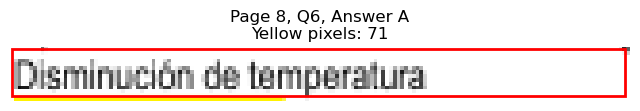

Page 8, Q6 - B: Detected box: x0=85.0, y0=554.9, x1=152.5, y1=567.0
Page 8, Q6, B: Yellow pixels: 585
Page 8, Q6, B: Total non-white pixels: 1009
Page 8, Q6, B: Yellow percentage: 58.0%


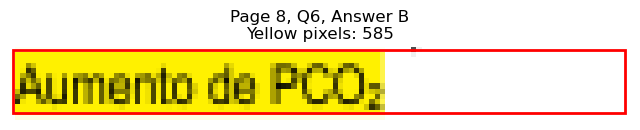

Page 8, Q6 - C: Detected box: x0=85.0, y0=567.1, x1=174.0, y1=579.2
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 551
Page 8, Q6, C: Yellow percentage: 0.0%


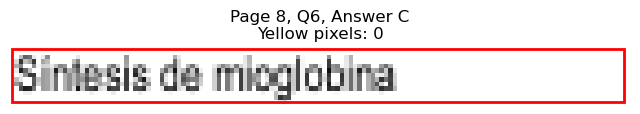

Page 8, Q6 - D: Detected box: x0=336.7, y0=542.9, x1=399.0, y1=555.0
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 281
Page 8, Q6, D: Yellow percentage: 0.0%


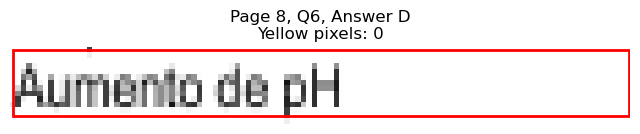

Page 8, Q6 - E: Detected box: x0=336.7, y0=554.9, x1=433.4, y1=567.0
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 482
Page 8, Q6, E: Yellow percentage: 0.0%


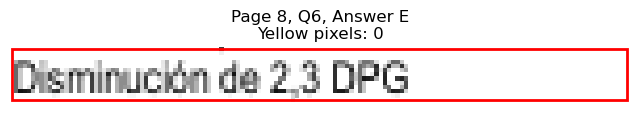


Page 8, Q6 - Selected Answer: B (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=85.0, y0=615.2, x1=122.8, y1=627.3
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 208
Page 8, Q7, A: Yellow percentage: 0.0%


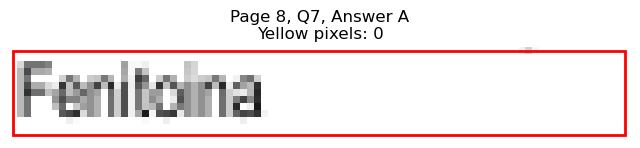

Page 8, Q7 - B: Detected box: x0=85.0, y0=627.3, x1=126.3, y1=639.4
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 220
Page 8, Q7, B: Yellow percentage: 0.0%


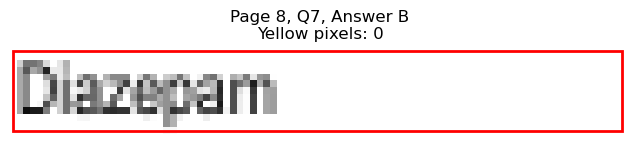

Page 8, Q7 - C: Detected box: x0=85.0, y0=639.3, x1=135.3, y1=651.4
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 280
Page 8, Q7, C: Yellow percentage: 0.0%


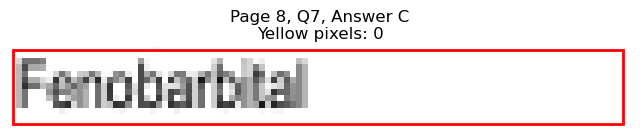

Page 8, Q7 - D: Detected box: x0=336.7, y0=615.2, x1=382.6, y1=627.3
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 237
Page 8, Q7, D: Yellow percentage: 0.0%


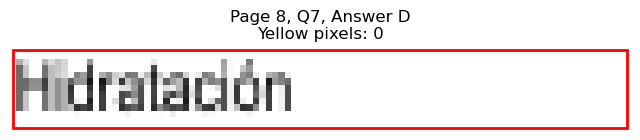

Page 8, Q7 - E: Detected box: x0=336.7, y0=627.3, x1=427.2, y1=639.4
Page 8, Q7, E: Yellow pixels: 702
Page 8, Q7, E: Total non-white pixels: 1157
Page 8, Q7, E: Yellow percentage: 60.7%


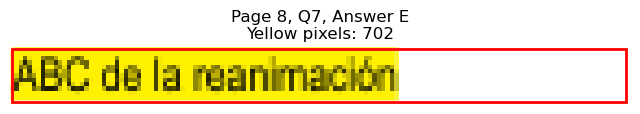


Page 8, Q7 - Selected Answer: E (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=85.0, y0=675.4, x1=130.5, y1=687.5
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 238
Page 8, Q8, A: Yellow percentage: 0.0%


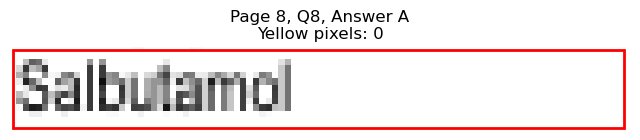

Page 8, Q8 - B: Detected box: x0=85.0, y0=687.5, x1=145.8, y1=699.7
Page 8, Q8, B: Yellow pixels: 502
Page 8, Q8, B: Total non-white pixels: 780
Page 8, Q8, B: Yellow percentage: 64.4%


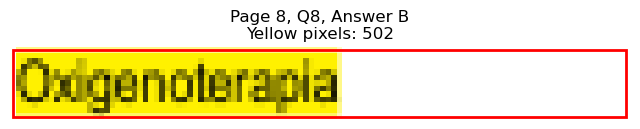

Page 8, Q8 - C: Detected box: x0=85.0, y0=699.5, x1=169.7, y1=711.7
Page 8, Q8, C: Yellow pixels: 58
Page 8, Q8, C: Total non-white pixels: 489
Page 8, Q8, C: Yellow percentage: 11.9%


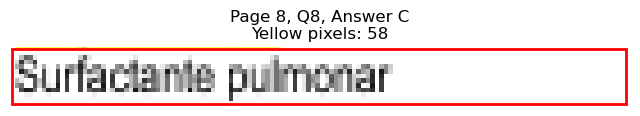

Page 8, Q8 - D: Detected box: x0=336.7, y0=675.4, x1=392.7, y1=687.5
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 307
Page 8, Q8, D: Yellow percentage: 0.0%


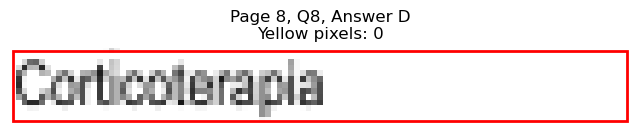

Page 8, Q8 - E: Detected box: x0=336.7, y0=687.5, x1=384.6, y1=699.7
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 240
Page 8, Q8, E: Yellow percentage: 0.0%


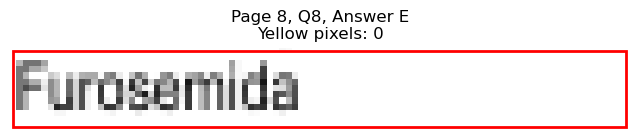


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=85.0, y0=133.2, x1=185.5, y1=145.3
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 533
Page 9, Q1, A: Yellow percentage: 0.0%


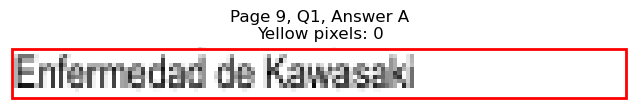

Page 9, Q1 - B: Detected box: x0=85.0, y0=145.3, x1=168.3, y1=157.4
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 421
Page 9, Q1, B: Yellow percentage: 0.0%


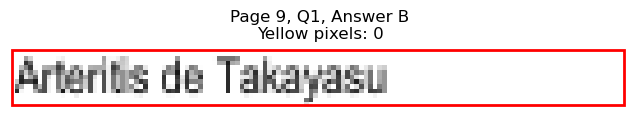

Page 9, Q1 - C: Detected box: x0=85.0, y0=157.3, x1=193.7, y1=169.4
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 556
Page 9, Q1, C: Yellow percentage: 0.0%


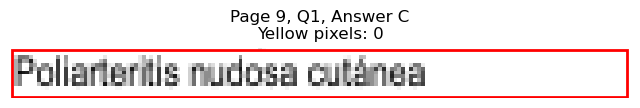

Page 9, Q1 - D: Detected box: x0=336.7, y0=133.2, x1=454.4, y1=145.3
Page 9, Q1, D: Yellow pixels: 904
Page 9, Q1, D: Total non-white pixels: 1521
Page 9, Q1, D: Yellow percentage: 59.4%


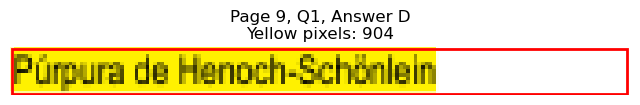

Page 9, Q1 - E: Detected box: x0=336.7, y0=145.3, x1=410.4, y1=157.4
Page 9, Q1, E: Yellow pixels: 1
Page 9, Q1, E: Total non-white pixels: 498
Page 9, Q1, E: Yellow percentage: 0.2%


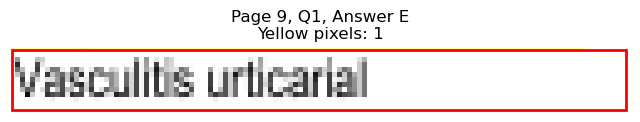


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=85.0, y0=205.5, x1=327.7, y1=217.7
Page 9, Q2, A: Yellow pixels: 293
Page 9, Q2, A: Total non-white pixels: 1483
Page 9, Q2, A: Yellow percentage: 19.8%


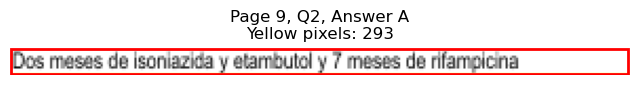

Page 9, Q2 - B: Detected box: x0=85.0, y0=217.5, x1=421.5, y1=229.7
Page 9, Q2, B: Yellow pixels: 3034
Page 9, Q2, B: Total non-white pixels: 4368
Page 9, Q2, B: Yellow percentage: 69.5%


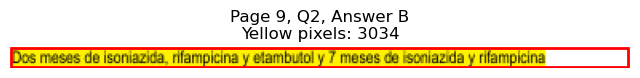

Page 9, Q2 - C: Detected box: x0=85.0, y0=229.7, x1=328.2, y1=241.8
Page 9, Q2, C: Yellow pixels: 294
Page 9, Q2, C: Total non-white pixels: 1501
Page 9, Q2, C: Yellow percentage: 19.6%


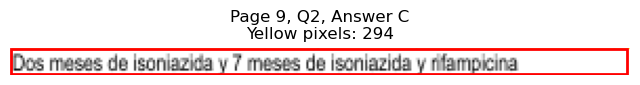

Page 9, Q2 - D: Detected box: x0=85.0, y0=241.7, x1=328.2, y1=253.8
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 1208
Page 9, Q2, D: Yellow percentage: 0.0%


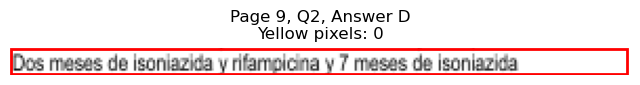

Page 9, Q2 - E: Detected box: x0=85.0, y0=253.7, x1=366.4, y1=265.8
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 1392
Page 9, Q2, E: Yellow percentage: 0.0%


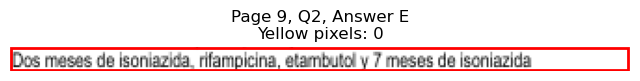


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=85.0, y0=301.9, x1=120.9, y1=314.0
Page 9, Q3, A: Yellow pixels: 86
Page 9, Q3, A: Total non-white pixels: 364
Page 9, Q3, A: Yellow percentage: 23.6%


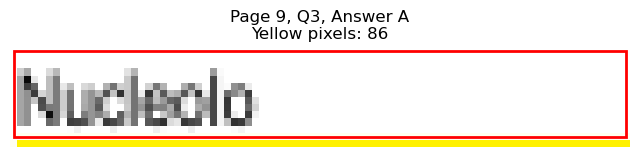

Page 9, Q3 - B: Detected box: x0=85.0, y0=313.9, x1=176.4, y1=326.0
Page 9, Q3, B: Yellow pixels: 665
Page 9, Q3, B: Total non-white pixels: 1270
Page 9, Q3, B: Yellow percentage: 52.4%


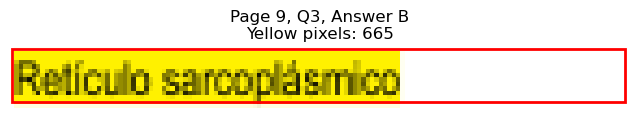

Page 9, Q3 - C: Detected box: x0=85.0, y0=326.1, x1=124.2, y1=338.2
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 284
Page 9, Q3, C: Yellow percentage: 0.0%


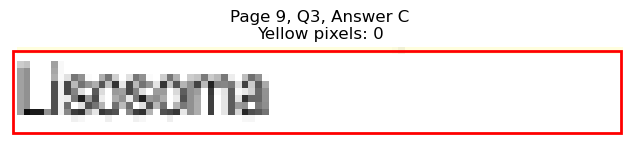

Page 9, Q3 - D: Detected box: x0=336.7, y0=301.9, x1=385.5, y1=314.0
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 240
Page 9, Q3, D: Yellow percentage: 0.0%


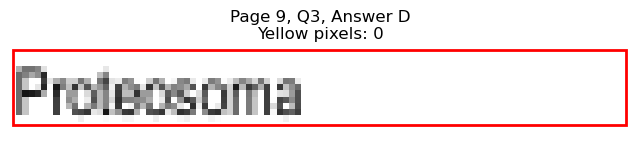

Page 9, Q3 - E: Detected box: x0=336.7, y0=313.9, x1=403.8, y1=326.0
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 343
Page 9, Q3, E: Yellow percentage: 0.0%


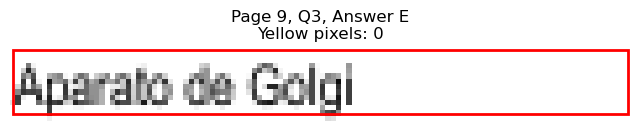


Page 9, Q3 - Selected Answer: B (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=85.0, y0=374.2, x1=144.4, y1=386.3
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 329
Page 9, Q4, A: Yellow percentage: 0.0%


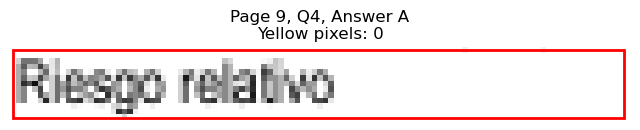

Page 9, Q4 - B: Detected box: x0=85.0, y0=386.3, x1=199.9, y1=398.4
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 571
Page 9, Q4, B: Yellow percentage: 0.0%


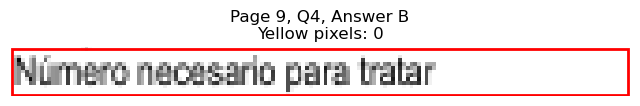

Page 9, Q4 - C: Detected box: x0=85.0, y0=398.3, x1=180.7, y1=410.4
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 495
Page 9, Q4, C: Yellow percentage: 0.0%


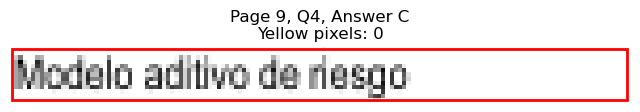

Page 9, Q4 - D: Detected box: x0=336.7, y0=374.2, x1=453.5, y1=386.3
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 579
Page 9, Q4, D: Yellow percentage: 0.0%


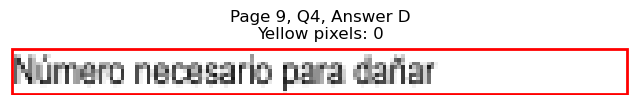

Page 9, Q4 - E: Detected box: x0=336.7, y0=386.3, x1=475.1, y1=398.4
Page 9, Q4, E: Yellow pixels: 1060
Page 9, Q4, E: Total non-white pixels: 1781
Page 9, Q4, E: Yellow percentage: 59.5%


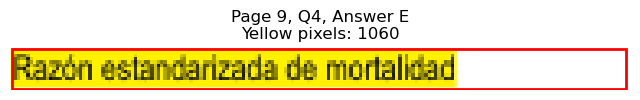


Page 9, Q4 - Selected Answer: E (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=85.0, y0=458.6, x1=201.9, y1=470.7
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 616
Page 9, Q5, A: Yellow percentage: 0.0%


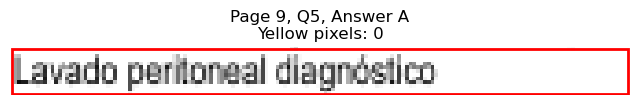

Page 9, Q5 - B: Detected box: x0=85.0, y0=470.7, x1=173.5, y1=482.8
Page 9, Q5, B: Yellow pixels: 664
Page 9, Q5, B: Total non-white pixels: 1143
Page 9, Q5, B: Yellow percentage: 58.1%


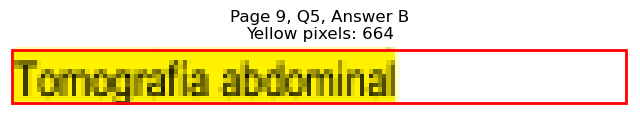

Page 9, Q5 - C: Detected box: x0=85.0, y0=482.7, x1=179.3, y1=494.8
Page 9, Q5, C: Yellow pixels: 82
Page 9, Q5, C: Total non-white pixels: 576
Page 9, Q5, C: Yellow percentage: 14.2%


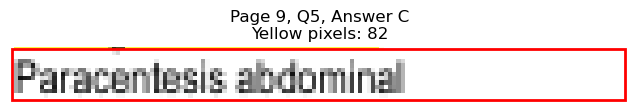

Page 9, Q5 - D: Detected box: x0=336.7, y0=458.6, x1=437.2, y1=470.7
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 547
Page 9, Q5, D: Yellow percentage: 0.0%


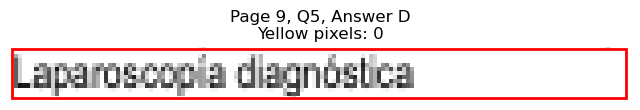

Page 9, Q5 - E: Detected box: x0=336.7, y0=470.7, x1=434.8, y1=482.8
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 512
Page 9, Q5, E: Yellow percentage: 0.0%


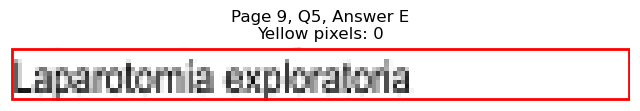


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=85.0, y0=518.8, x1=115.6, y1=530.9
Page 9, Q6, A: Yellow pixels: 225
Page 9, Q6, A: Total non-white pixels: 389
Page 9, Q6, A: Yellow percentage: 57.8%


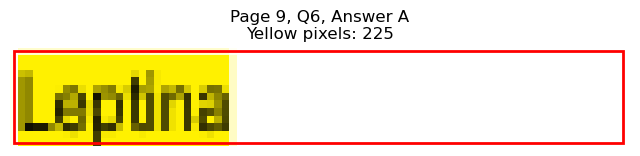

Page 9, Q6 - B: Detected box: x0=85.0, y0=530.9, x1=117.0, y1=543.0
Page 9, Q6, B: Yellow pixels: 27
Page 9, Q6, B: Total non-white pixels: 196
Page 9, Q6, B: Yellow percentage: 13.8%


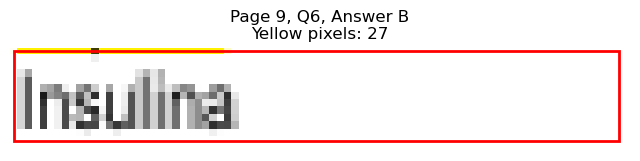

Page 9, Q6 - C: Detected box: x0=85.0, y0=542.9, x1=115.1, y1=555.0
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 157
Page 9, Q6, C: Yellow percentage: 0.0%


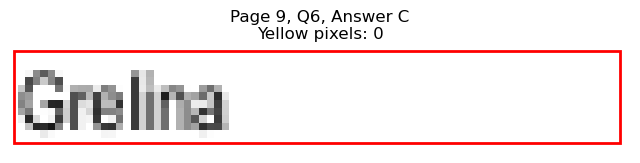

Page 9, Q6 - D: Detected box: x0=336.7, y0=518.8, x1=369.2, y1=530.9
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 155
Page 9, Q6, D: Yellow percentage: 0.0%


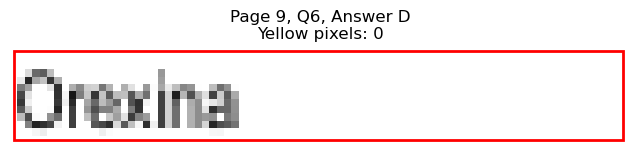

Page 9, Q6 - E: Detected box: x0=336.7, y0=530.9, x1=373.5, y1=543.0
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 193
Page 9, Q6, E: Yellow percentage: 0.0%


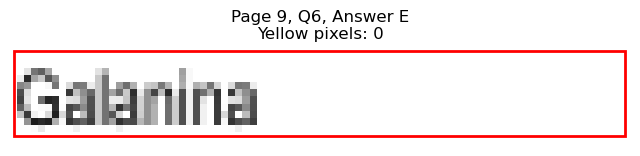


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=85.0, y0=591.2, x1=128.7, y1=603.3
Page 9, Q7, A: Yellow pixels: 388
Page 9, Q7, A: Total non-white pixels: 586
Page 9, Q7, A: Yellow percentage: 66.2%


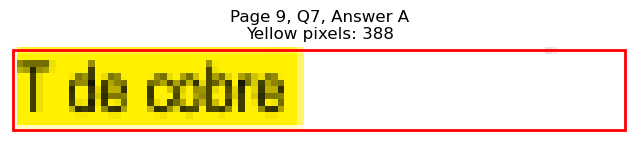

Page 9, Q7 - B: Detected box: x0=85.0, y0=603.2, x1=182.2, y1=615.3
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 572
Page 9, Q7, B: Yellow percentage: 0.0%


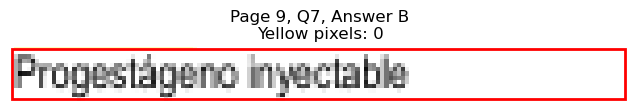

Page 9, Q7 - C: Detected box: x0=85.0, y0=615.2, x1=180.7, y1=627.3
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 524
Page 9, Q7, C: Yellow percentage: 0.0%


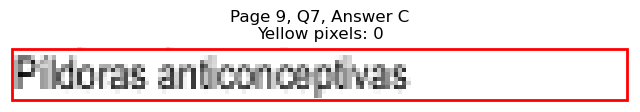

Page 9, Q7 - D: Detected box: x0=336.7, y0=591.2, x1=389.8, y1=603.3
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 286
Page 9, Q7, D: Yellow percentage: 0.0%


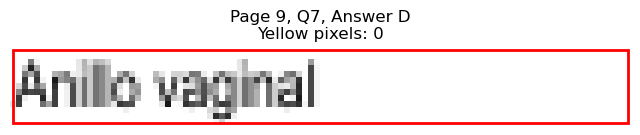

Page 9, Q7 - E: Detected box: x0=336.7, y0=603.2, x1=387.1, y1=615.3
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 251
Page 9, Q7, E: Yellow percentage: 0.0%


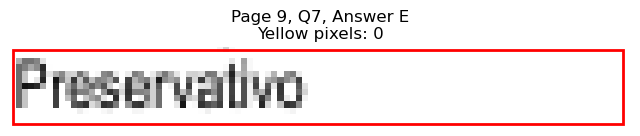


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=85.0, y0=651.4, x1=141.0, y1=663.5
Page 9, Q8, A: Yellow pixels: 44
Page 9, Q8, A: Total non-white pixels: 335
Page 9, Q8, A: Yellow percentage: 13.1%


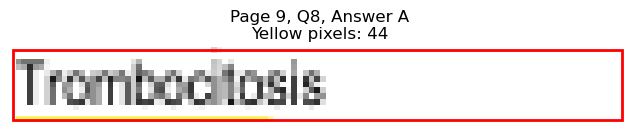

Page 9, Q8 - B: Detected box: x0=85.0, y0=663.4, x1=131.9, y1=675.5
Page 9, Q8, B: Yellow pixels: 398
Page 9, Q8, B: Total non-white pixels: 598
Page 9, Q8, B: Yellow percentage: 66.6%


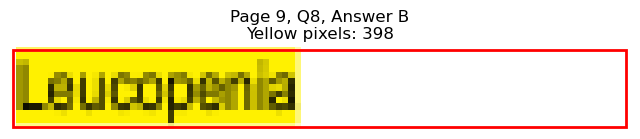

Page 9, Q8 - C: Detected box: x0=85.0, y0=675.4, x1=165.9, y1=687.5
Page 9, Q8, C: Yellow pixels: 44
Page 9, Q8, C: Total non-white pixels: 484
Page 9, Q8, C: Yellow percentage: 9.1%


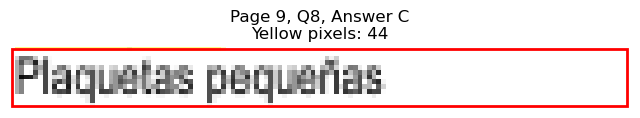

Page 9, Q8 - D: Detected box: x0=336.7, y0=651.4, x1=384.1, y1=663.5
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 254
Page 9, Q8, D: Yellow percentage: 0.0%


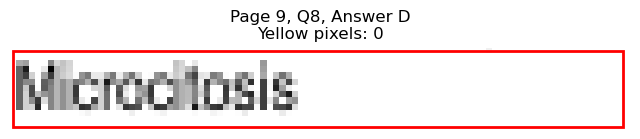

Page 9, Q8 - E: Detected box: x0=336.7, y0=663.4, x1=427.6, y1=675.5
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 470
Page 9, Q8, E: Yellow percentage: 0.0%


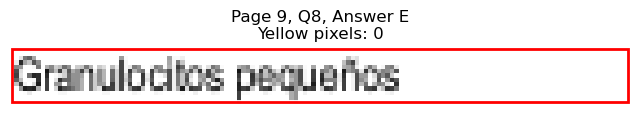


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=85.0, y0=723.7, x1=130.9, y1=735.8
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 247
Page 9, Q9, A: Yellow percentage: 0.0%


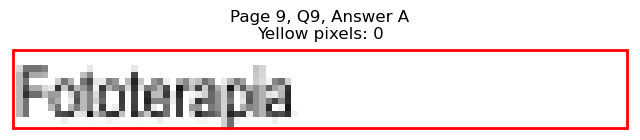

Page 9, Q9 - B: Detected box: x0=85.0, y0=735.8, x1=175.5, y1=747.9
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 600
Page 9, Q9, B: Yellow percentage: 0.0%


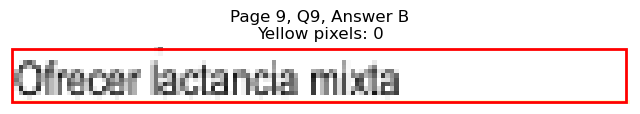

Page 9, Q9 - C: Detected box: x0=85.0, y0=747.8, x1=247.7, y1=759.9
Page 9, Q9, C: Yellow pixels: 1318
Page 9, Q9, C: Total non-white pixels: 2105
Page 9, Q9, C: Yellow percentage: 62.6%


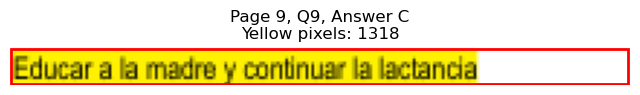

Page 9, Q9 - D: Detected box: x0=336.7, y0=723.7, x1=460.2, y1=735.8
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 621
Page 9, Q9, D: Yellow percentage: 0.0%


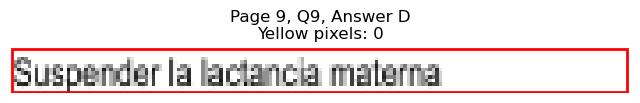

Page 9, Q9 - E: Detected box: x0=336.7, y0=735.8, x1=457.9, y1=747.9
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 593
Page 9, Q9, E: Yellow percentage: 0.0%


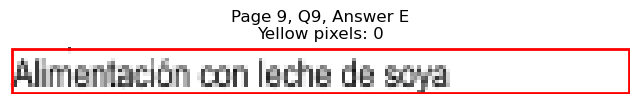


Page 9, Q9 - Selected Answer: C (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=155.8, y1=133.3
Page 10, Q1, A: Yellow pixels: 556
Page 10, Q1, A: Total non-white pixels: 909
Page 10, Q1, A: Yellow percentage: 61.2%


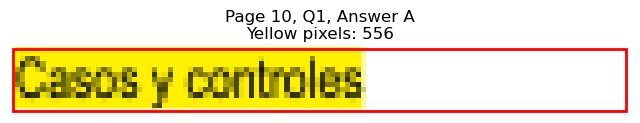

Page 10, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=124.7, y1=145.3
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 271
Page 10, Q1, B: Yellow percentage: 0.0%


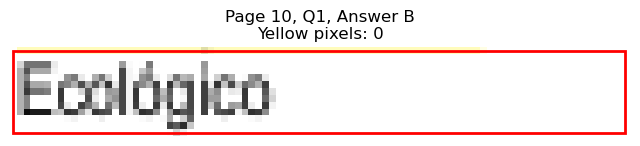

Page 10, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=170.2, y1=157.4
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 424
Page 10, Q1, C: Yellow percentage: 0.0%


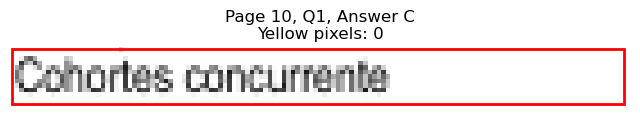

Page 10, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=396.1, y1=133.3
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 292
Page 10, Q1, D: Yellow percentage: 0.0%


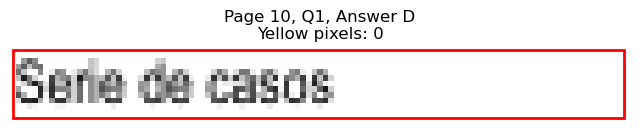

Page 10, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=413.2, y1=145.3
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 411
Page 10, Q1, E: Yellow percentage: 0.0%


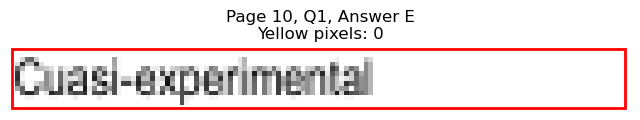


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=85.0, y0=205.5, x1=163.5, y1=217.7
Page 10, Q2, A: Yellow pixels: 120
Page 10, Q2, A: Total non-white pixels: 538
Page 10, Q2, A: Yellow percentage: 22.3%


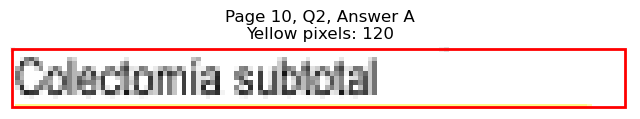

Page 10, Q2 - B: Detected box: x0=85.0, y0=217.5, x1=208.0, y1=229.7
Page 10, Q2, B: Yellow pixels: 1040
Page 10, Q2, B: Total non-white pixels: 1586
Page 10, Q2, B: Yellow percentage: 65.6%


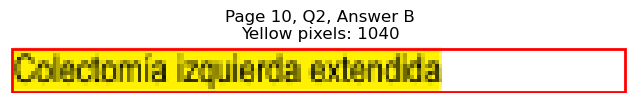

Page 10, Q2 - C: Detected box: x0=85.0, y0=229.7, x1=167.8, y1=241.8
Page 10, Q2, C: Yellow pixels: 121
Page 10, Q2, C: Total non-white pixels: 556
Page 10, Q2, C: Yellow percentage: 21.8%


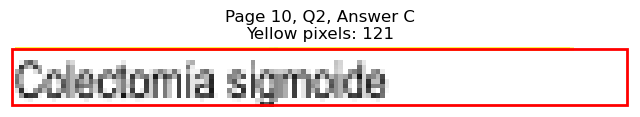

Page 10, Q2 - D: Detected box: x0=336.7, y0=205.5, x1=420.0, y1=217.7
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 427
Page 10, Q2, D: Yellow percentage: 0.0%


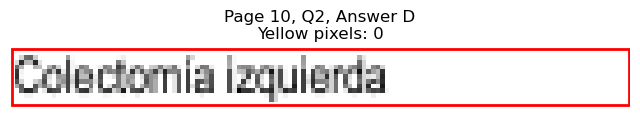

Page 10, Q2 - E: Detected box: x0=336.7, y0=217.5, x1=425.2, y1=229.7
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 452
Page 10, Q2, E: Yellow percentage: 0.0%


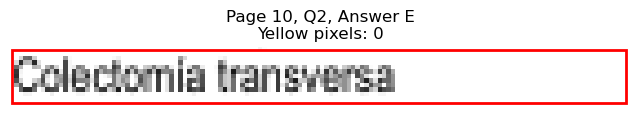


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=85.0, y0=277.8, x1=114.6, y1=289.9
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 135
Page 10, Q3, A: Yellow percentage: 0.0%


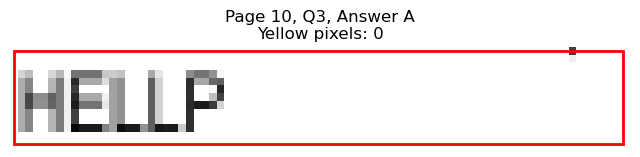

Page 10, Q3 - B: Detected box: x0=85.0, y0=289.9, x1=131.4, y1=302.0
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 251
Page 10, Q3, B: Yellow percentage: 0.0%


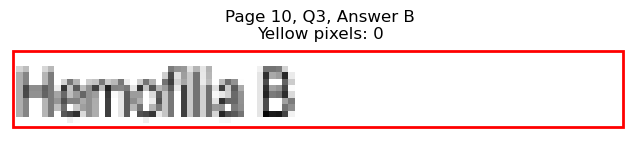

Page 10, Q3 - C: Detected box: x0=85.0, y0=301.9, x1=100.8, y1=314.0
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 63
Page 10, Q3, C: Yellow percentage: 0.0%


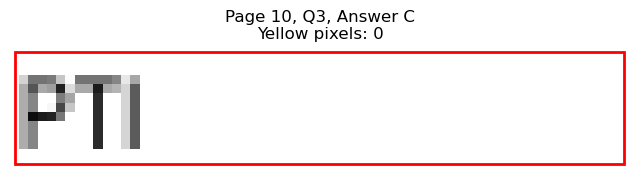

Page 10, Q3 - D: Detected box: x0=336.7, y0=277.8, x1=383.1, y1=289.9
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 241
Page 10, Q3, D: Yellow percentage: 0.0%


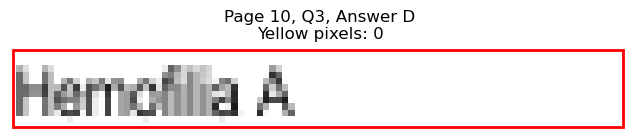

Page 10, Q3 - E: Detected box: x0=336.7, y0=289.9, x1=397.5, y1=302.0
Page 10, Q3, E: Yellow pixels: 452
Page 10, Q3, E: Total non-white pixels: 779
Page 10, Q3, E: Yellow percentage: 58.0%


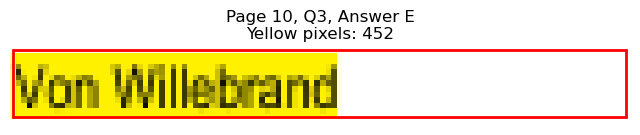


Page 10, Q3 - Selected Answer: E (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=70.8, y0=350.2, x1=79.0, y1=362.3
Page 10, Q4, A: Yellow pixels: 5
Page 10, Q4, A: Total non-white pixels: 70
Page 10, Q4, A: Yellow percentage: 7.1%


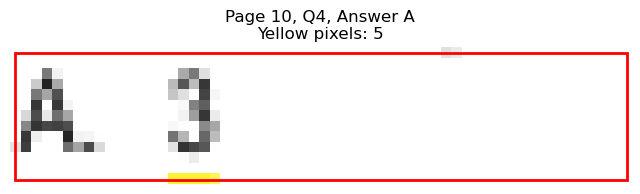

Page 10, Q4 - B: Detected box: x0=70.8, y0=362.2, x1=79.0, y1=374.3
Page 10, Q4, B: Yellow pixels: 38
Page 10, Q4, B: Total non-white pixels: 116
Page 10, Q4, B: Yellow percentage: 32.8%


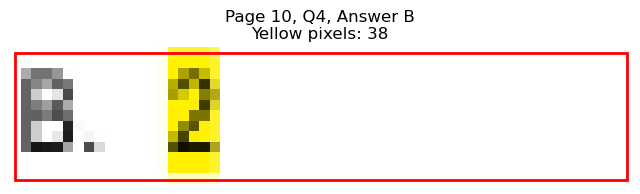

Page 10, Q4 - C: Detected box: x0=70.8, y0=374.2, x1=79.5, y1=386.3
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 66
Page 10, Q4, C: Yellow percentage: 0.0%


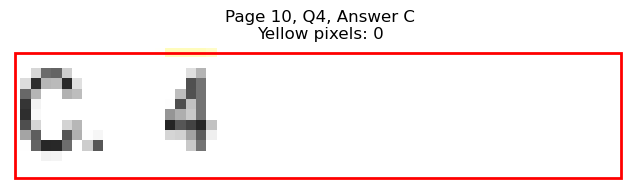

Page 10, Q4 - D: Detected box: x0=322.5, y0=350.2, x1=331.2, y1=362.3
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 45
Page 10, Q4, D: Yellow percentage: 0.0%


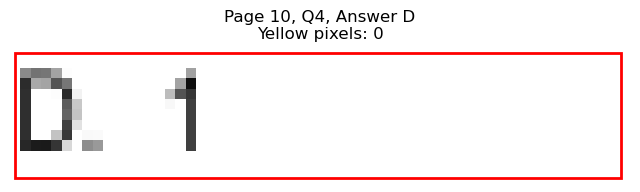

Page 10, Q4 - E: Detected box: x0=322.5, y0=362.2, x1=330.7, y1=374.3
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 61
Page 10, Q4, E: Yellow percentage: 0.0%


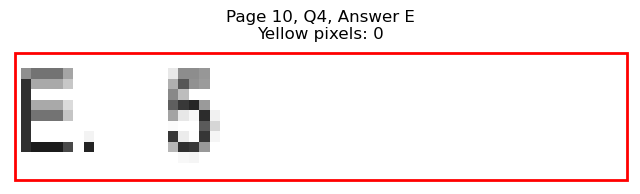


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=85.0, y0=434.4, x1=216.7, y1=446.5
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 671
Page 10, Q5, A: Yellow percentage: 0.0%


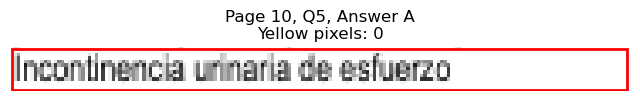

Page 10, Q5 - B: Detected box: x0=85.0, y0=446.6, x1=238.6, y1=458.7
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 768
Page 10, Q5, B: Yellow percentage: 0.0%


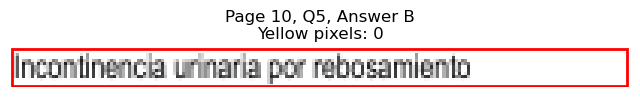

Page 10, Q5 - C: Detected box: x0=85.0, y0=458.6, x1=192.3, y1=470.7
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 537
Page 10, Q5, C: Yellow percentage: 0.0%


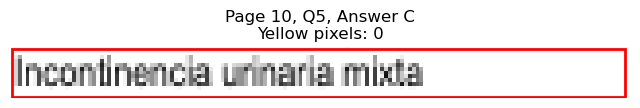

Page 10, Q5 - D: Detected box: x0=336.7, y0=434.4, x1=457.3, y1=446.5
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 633
Page 10, Q5, D: Yellow percentage: 0.0%


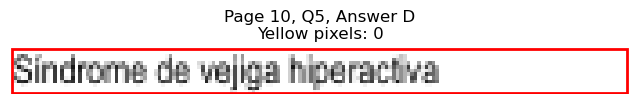

Page 10, Q5 - E: Detected box: x0=336.7, y0=446.6, x1=468.3, y1=458.7
Page 10, Q5, E: Yellow pixels: 1121
Page 10, Q5, E: Total non-white pixels: 1690
Page 10, Q5, E: Yellow percentage: 66.3%


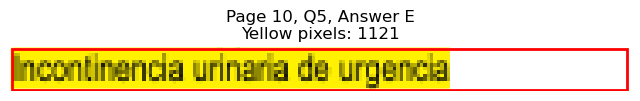


Page 10, Q5 - Selected Answer: E (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=85.0, y0=530.9, x1=179.3, y1=543.0
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 493
Page 10, Q6, A: Yellow percentage: 0.0%


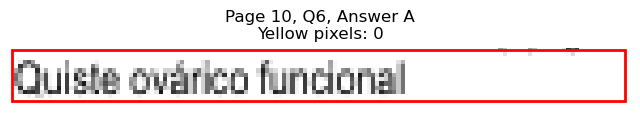

Page 10, Q6 - B: Detected box: x0=85.0, y0=542.9, x1=145.8, y1=555.0
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 315
Page 10, Q6, B: Yellow percentage: 0.0%


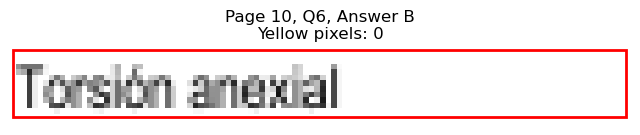

Page 10, Q6 - C: Detected box: x0=85.0, y0=554.9, x1=178.3, y1=567.0
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 470
Page 10, Q6, C: Yellow percentage: 0.0%


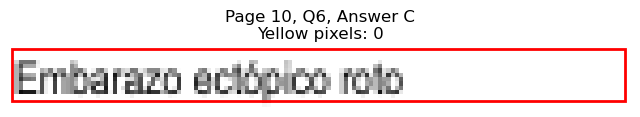

Page 10, Q6 - D: Detected box: x0=336.7, y0=530.9, x1=439.6, y1=543.0
Page 10, Q6, D: Yellow pixels: 55
Page 10, Q6, D: Total non-white pixels: 615
Page 10, Q6, D: Yellow percentage: 8.9%


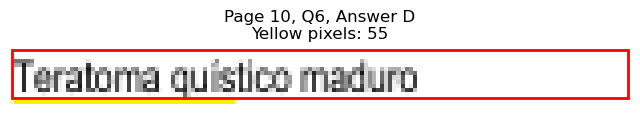

Page 10, Q6 - E: Detected box: x0=336.7, y0=542.9, x1=394.6, y1=555.0
Page 10, Q6, E: Yellow pixels: 413
Page 10, Q6, E: Total non-white pixels: 743
Page 10, Q6, E: Yellow percentage: 55.6%


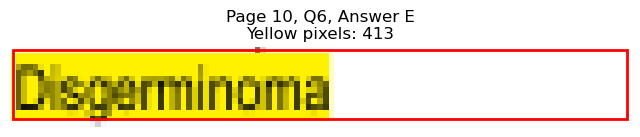


Page 10, Q6 - Selected Answer: E (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=85.0, y0=615.2, x1=132.9, y1=627.3
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 264
Page 10, Q7, A: Yellow percentage: 0.0%


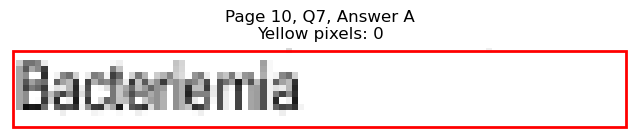

Page 10, Q7 - B: Detected box: x0=85.0, y0=627.3, x1=153.9, y1=639.4
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 365
Page 10, Q7, B: Yellow percentage: 0.0%


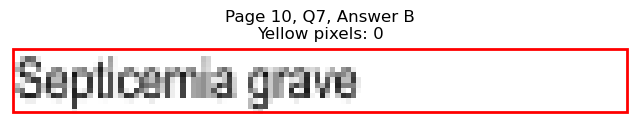

Page 10, Q7 - C: Detected box: x0=85.0, y0=639.3, x1=113.2, y1=651.4
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 152
Page 10, Q7, C: Yellow percentage: 0.0%


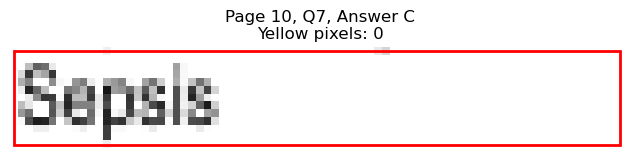

Page 10, Q7 - D: Detected box: x0=336.7, y0=615.2, x1=415.6, y1=627.3
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 396
Page 10, Q7, D: Yellow percentage: 0.0%


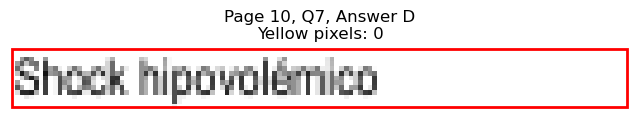

Page 10, Q7 - E: Detected box: x0=336.7, y0=627.3, x1=432.6, y1=639.4
Page 10, Q7, E: Yellow pixels: 736
Page 10, Q7, E: Total non-white pixels: 1261
Page 10, Q7, E: Yellow percentage: 58.4%


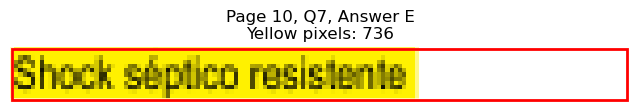


Page 10, Q7 - Selected Answer: E (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=85.0, y0=687.5, x1=115.6, y1=699.7
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 157
Page 10, Q8, A: Yellow percentage: 0.0%


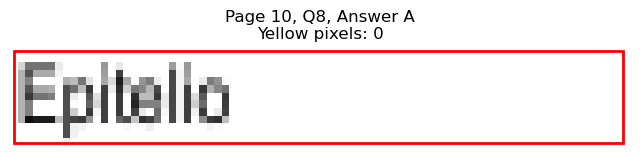

Page 10, Q8 - B: Detected box: x0=85.0, y0=699.5, x1=123.3, y1=711.7
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 182
Page 10, Q8, B: Yellow percentage: 0.0%


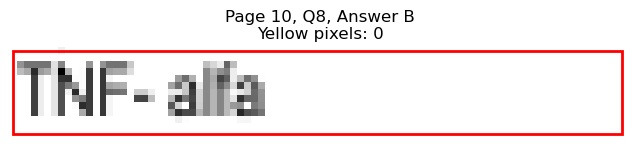

Page 10, Q8 - C: Detected box: x0=85.0, y0=711.7, x1=115.1, y1=723.8
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 150
Page 10, Q8, C: Yellow percentage: 0.0%


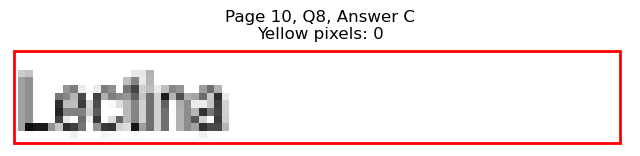

Page 10, Q8 - D: Detected box: x0=336.7, y0=687.5, x1=354.0, y1=699.7
Page 10, Q8, D: Yellow pixels: 40
Page 10, Q8, D: Total non-white pixels: 95
Page 10, Q8, D: Yellow percentage: 42.1%


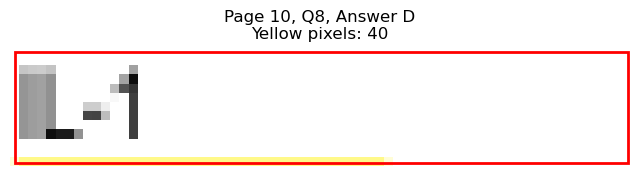

Page 10, Q8 - E: Detected box: x0=336.7, y0=699.5, x1=379.8, y1=711.7
Page 10, Q8, E: Yellow pixels: 332
Page 10, Q8, E: Total non-white pixels: 546
Page 10, Q8, E: Yellow percentage: 60.8%


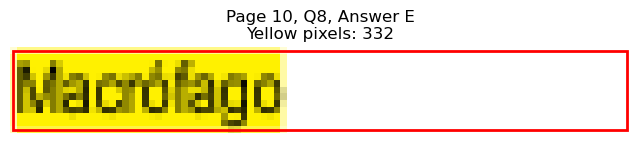


Page 10, Q8 - Selected Answer: E (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=85.0, y0=747.8, x1=205.6, y1=759.9
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 631
Page 10, Q9, A: Yellow percentage: 0.0%


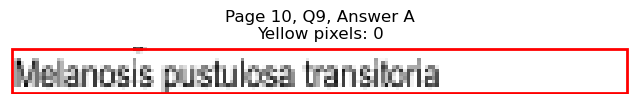

Page 10, Q9 - B: Detected box: x0=85.0, y0=759.8, x1=176.4, y1=771.9
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 458
Page 10, Q9, B: Yellow percentage: 0.0%


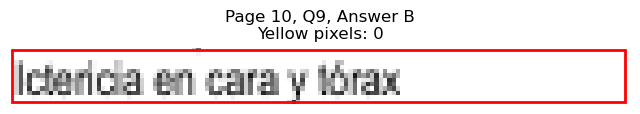

Page 10, Q9 - C: Detected box: x0=85.0, y0=771.9, x1=170.2, y1=784.0
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 450
Page 10, Q9, C: Yellow percentage: 0.0%


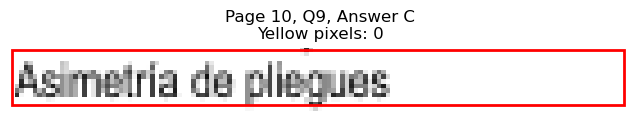

Page 10, Q9 - D: Detected box: x0=336.7, y0=747.8, x1=437.2, y1=759.9
Page 10, Q9, D: Yellow pixels: 754
Page 10, Q9, D: Total non-white pixels: 1287
Page 10, Q9, D: Yellow percentage: 58.6%


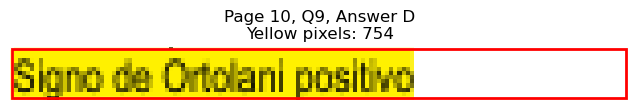

Page 10, Q9 - E: Detected box: x0=336.7, y0=759.8, x1=464.0, y1=771.9
Page 10, Q9, E: Yellow pixels: 94
Page 10, Q9, E: Total non-white pixels: 691
Page 10, Q9, E: Yellow percentage: 13.6%


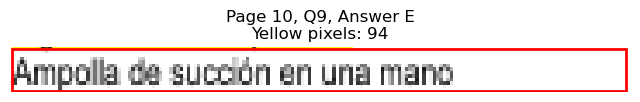


Page 10, Q9 - Selected Answer: D (based on yellow pixel count)





Page 11: Found 10 questions
Page 11, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=178.8, y1=109.2
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 450
Page 11, Q1, A: Yellow percentage: 0.0%


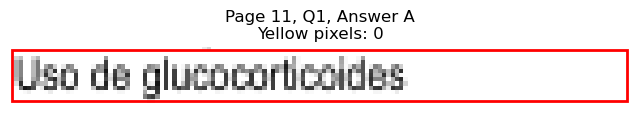

Page 11, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=205.6, y1=121.3
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 595
Page 11, Q1, B: Yellow percentage: 0.0%


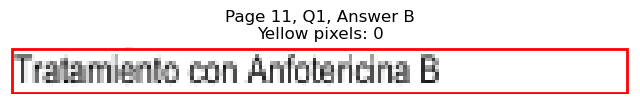

Page 11, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=169.7, y1=133.3
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 426
Page 11, Q1, C: Yellow percentage: 0.0%


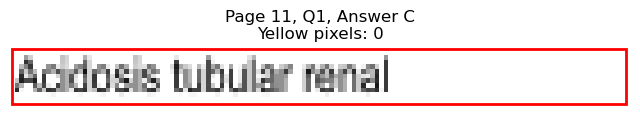

Page 11, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=398.0, y1=109.2
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 303
Page 11, Q1, D: Yellow percentage: 0.0%


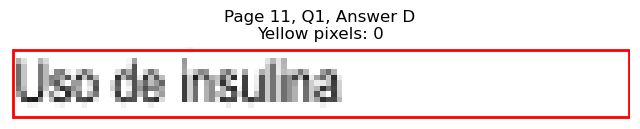

Page 11, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=432.0, y1=121.3
Page 11, Q1, E: Yellow pixels: 711
Page 11, Q1, E: Total non-white pixels: 1222
Page 11, Q1, E: Yellow percentage: 58.2%


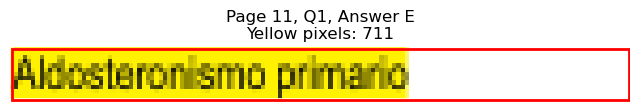


Page 11, Q1 - Selected Answer: E (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=140.1, y1=205.5
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 292
Page 11, Q2, A: Yellow percentage: 0.0%


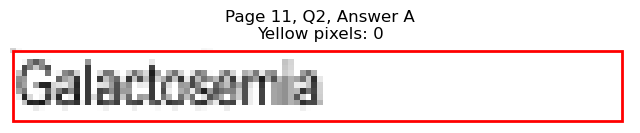

Page 11, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=174.0, y1=217.7
Page 11, Q2, B: Yellow pixels: 748
Page 11, Q2, B: Total non-white pixels: 1144
Page 11, Q2, B: Yellow percentage: 65.4%


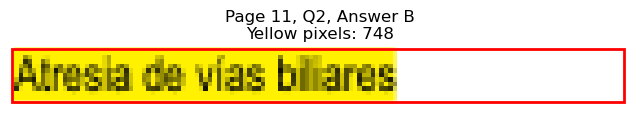

Page 11, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=157.2, y1=229.7
Page 11, Q2, C: Yellow pixels: 86
Page 11, Q2, C: Total non-white pixels: 484
Page 11, Q2, C: Yellow percentage: 17.8%


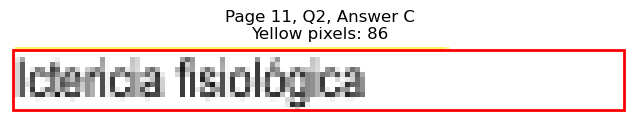

Page 11, Q2 - D: Detected box: x0=336.7, y0=193.4, x1=406.0, y1=205.5
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 374
Page 11, Q2, D: Yellow percentage: 0.0%


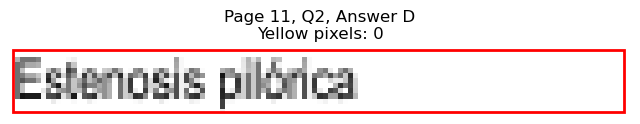

Page 11, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=440.6, y1=217.7
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 500
Page 11, Q2, E: Yellow percentage: 0.0%


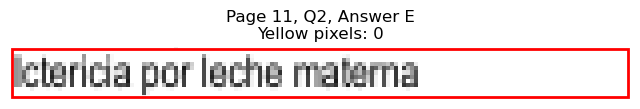


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=85.0, y0=265.8, x1=153.5, y1=277.9
Page 11, Q3, A: Yellow pixels: 515
Page 11, Q3, A: Total non-white pixels: 883
Page 11, Q3, A: Yellow percentage: 58.3%


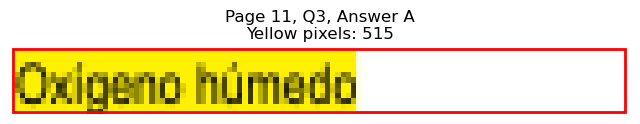

Page 11, Q3 - B: Detected box: x0=85.0, y0=277.8, x1=197.0, y1=289.9
Page 11, Q3, B: Yellow pixels: 62
Page 11, Q3, B: Total non-white pixels: 644
Page 11, Q3, B: Yellow percentage: 9.6%


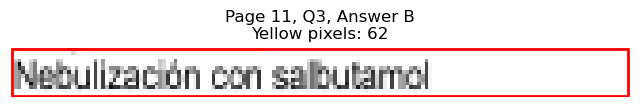

Page 11, Q3 - C: Detected box: x0=85.0, y0=289.9, x1=172.6, y1=302.0
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 452
Page 11, Q3, C: Yellow percentage: 0.0%


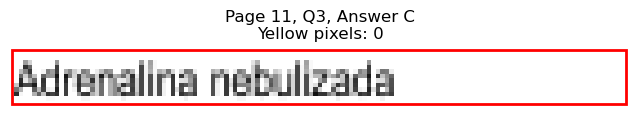

Page 11, Q3 - D: Detected box: x0=336.7, y0=265.8, x1=426.7, y1=277.9
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 459
Page 11, Q3, D: Yellow percentage: 0.0%


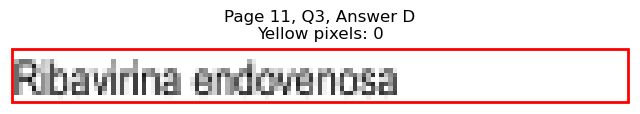

Page 11, Q3 - E: Detected box: x0=336.7, y0=277.8, x1=424.8, y1=289.9
Page 11, Q3, E: Yellow pixels: 0
Page 11, Q3, E: Total non-white pixels: 467
Page 11, Q3, E: Yellow percentage: 0.0%


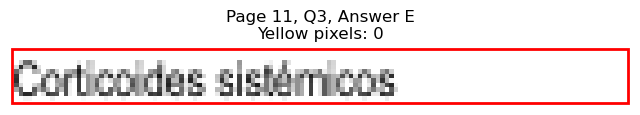


Page 11, Q3 - Selected Answer: A (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=85.0, y0=362.2, x1=194.2, y1=374.3
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 562
Page 11, Q4, A: Yellow percentage: 0.0%


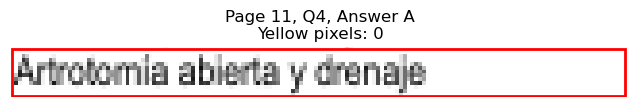

Page 11, Q4 - B: Detected box: x0=85.0, y0=374.2, x1=191.8, y1=386.3
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 571
Page 11, Q4, B: Yellow percentage: 0.0%


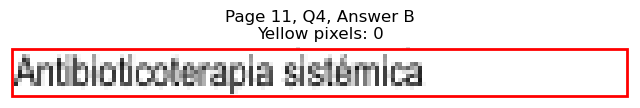

Page 11, Q4 - C: Detected box: x0=85.0, y0=386.3, x1=189.4, y1=398.4
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 506
Page 11, Q4, C: Yellow percentage: 0.0%


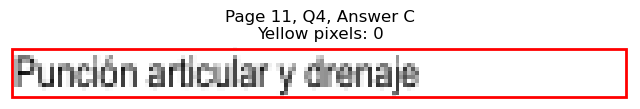

Page 11, Q4 - D: Detected box: x0=336.7, y0=362.2, x1=452.5, y1=374.3
Page 11, Q4, D: Yellow pixels: 160
Page 11, Q4, D: Total non-white pixels: 746
Page 11, Q4, D: Yellow percentage: 21.4%


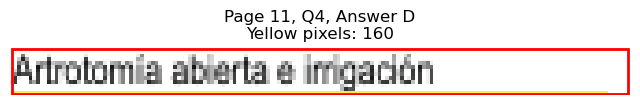

Page 11, Q4 - E: Detected box: x0=336.7, y0=374.2, x1=499.4, y1=386.3
Page 11, Q4, E: Yellow pixels: 1250
Page 11, Q4, E: Total non-white pixels: 2105
Page 11, Q4, E: Yellow percentage: 59.4%


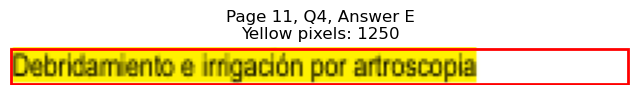


Page 11, Q4 - Selected Answer: E (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=85.0, y0=422.4, x1=204.7, y1=434.5
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 570
Page 11, Q5, A: Yellow percentage: 0.0%


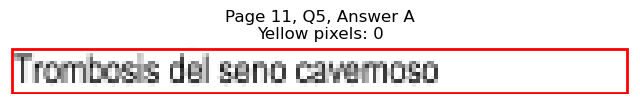

Page 11, Q5 - B: Detected box: x0=85.0, y0=434.4, x1=153.5, y1=446.5
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 350
Page 11, Q5, B: Yellow percentage: 0.0%


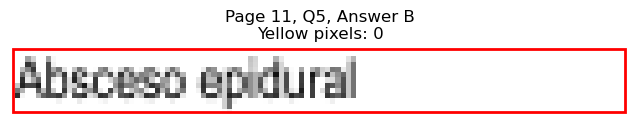

Page 11, Q5 - C: Detected box: x0=85.0, y0=446.6, x1=151.0, y1=458.7
Page 11, Q5, C: Yellow pixels: 536
Page 11, Q5, C: Total non-white pixels: 845
Page 11, Q5, C: Yellow percentage: 63.4%


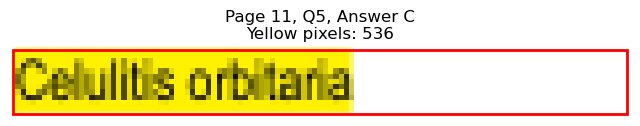

Page 11, Q5 - D: Detected box: x0=336.7, y0=422.4, x1=377.8, y1=434.5
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 232
Page 11, Q5, D: Yellow percentage: 0.0%


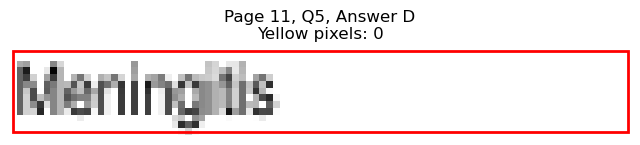

Page 11, Q5 - E: Detected box: x0=336.7, y0=434.4, x1=454.4, y1=446.5
Page 11, Q5, E: Yellow pixels: 0
Page 11, Q5, E: Total non-white pixels: 621
Page 11, Q5, E: Yellow percentage: 0.0%


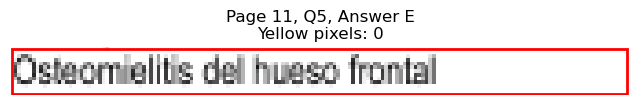


Page 11, Q5 - Selected Answer: C (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=85.0, y0=482.7, x1=124.7, y1=494.8
Page 11, Q6, A: Yellow pixels: 1
Page 11, Q6, A: Total non-white pixels: 246
Page 11, Q6, A: Yellow percentage: 0.4%


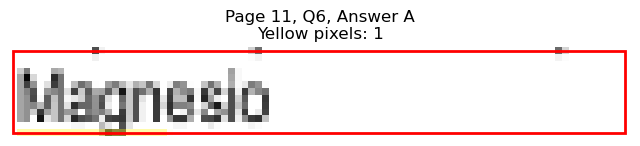

Page 11, Q6 - B: Detected box: x0=85.0, y0=494.7, x1=109.5, y1=506.8
Page 11, Q6, B: Yellow pixels: 167
Page 11, Q6, B: Total non-white pixels: 311
Page 11, Q6, B: Yellow percentage: 53.7%


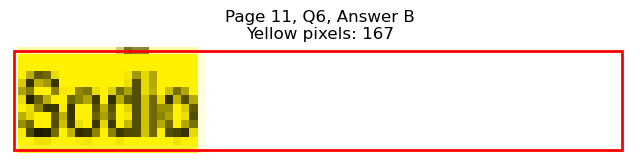

Page 11, Q6 - C: Detected box: x0=85.0, y0=506.8, x1=111.3, y1=518.9
Page 11, Q6, C: Yellow pixels: 22
Page 11, Q6, C: Total non-white pixels: 163
Page 11, Q6, C: Yellow percentage: 13.5%


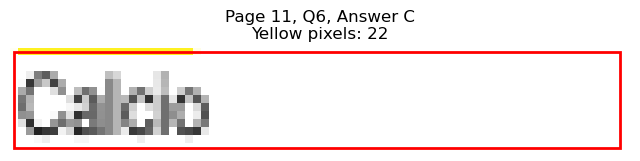

Page 11, Q6 - D: Detected box: x0=336.7, y0=482.7, x1=367.8, y1=494.8
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 160
Page 11, Q6, D: Yellow percentage: 0.0%


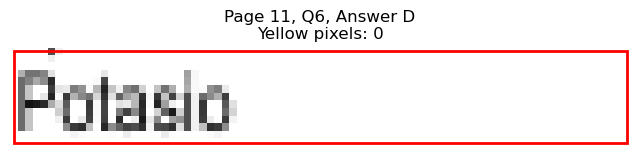

Page 11, Q6 - E: Detected box: x0=336.7, y0=494.7, x1=359.7, y1=506.8
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 102
Page 11, Q6, E: Yellow percentage: 0.0%


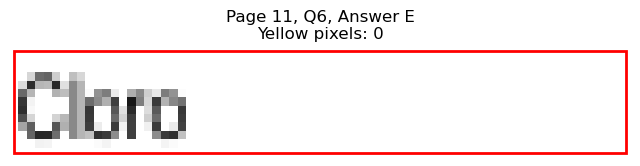


Page 11, Q6 - Selected Answer: B (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=85.0, y0=542.9, x1=129.0, y1=555.0
Page 11, Q7, A: Yellow pixels: 0
Page 11, Q7, A: Total non-white pixels: 247
Page 11, Q7, A: Yellow percentage: 0.0%


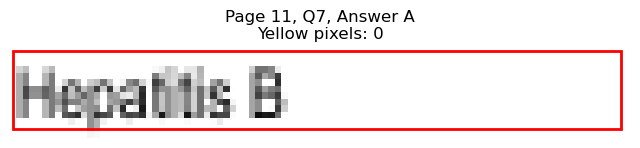

Page 11, Q7 - B: Detected box: x0=85.0, y0=554.9, x1=137.7, y1=567.0
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 277
Page 11, Q7, B: Yellow percentage: 0.0%


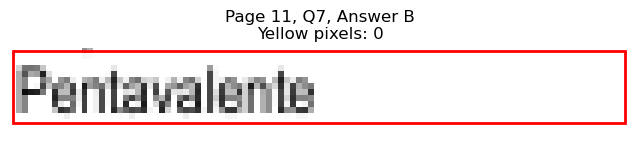

Page 11, Q7 - C: Detected box: x0=85.0, y0=567.1, x1=133.3, y1=579.2
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 241
Page 11, Q7, C: Yellow percentage: 0.0%


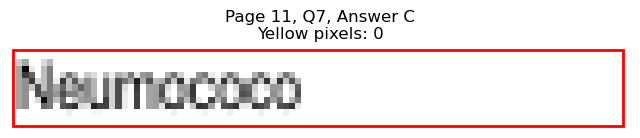

Page 11, Q7 - D: Detected box: x0=336.7, y0=542.9, x1=455.4, y1=555.0
Page 11, Q7, D: Yellow pixels: 35
Page 11, Q7, D: Total non-white pixels: 671
Page 11, Q7, D: Yellow percentage: 5.2%


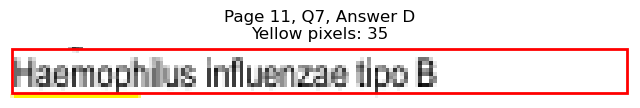

Page 11, Q7 - E: Detected box: x0=336.7, y0=554.9, x1=374.0, y1=567.0
Page 11, Q7, E: Yellow pixels: 246
Page 11, Q7, E: Total non-white pixels: 504
Page 11, Q7, E: Yellow percentage: 48.8%


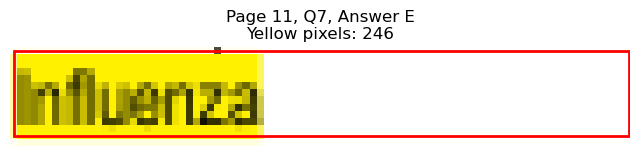


Page 11, Q7 - Selected Answer: E (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=85.0, y0=603.2, x1=133.3, y1=615.3
Page 11, Q8, A: Yellow pixels: 99
Page 11, Q8, A: Total non-white pixels: 348
Page 11, Q8, A: Yellow percentage: 28.4%


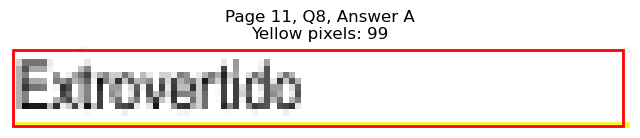

Page 11, Q8 - B: Detected box: x0=85.0, y0=615.2, x1=190.4, y1=627.3
Page 11, Q8, B: Yellow pixels: 800
Page 11, Q8, B: Total non-white pixels: 1352
Page 11, Q8, B: Yellow percentage: 59.2%


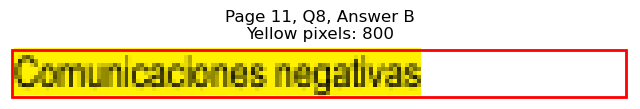

Page 11, Q8 - C: Detected box: x0=85.0, y0=627.3, x1=162.0, y1=639.4
Page 11, Q8, C: Yellow pixels: 2
Page 11, Q8, C: Total non-white pixels: 510
Page 11, Q8, C: Yellow percentage: 0.4%


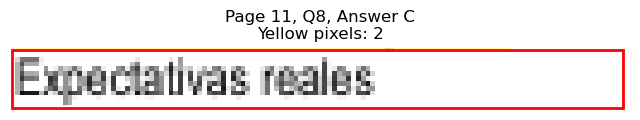

Page 11, Q8 - D: Detected box: x0=336.7, y0=603.2, x1=411.3, y1=615.3
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 396
Page 11, Q8, D: Yellow percentage: 0.0%


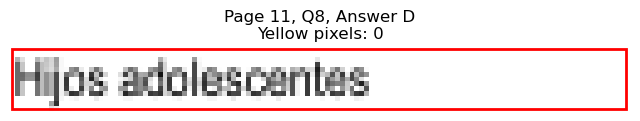

Page 11, Q8 - E: Detected box: x0=336.7, y0=615.2, x1=413.7, y1=627.3
Page 11, Q8, E: Yellow pixels: 0
Page 11, Q8, E: Total non-white pixels: 412
Page 11, Q8, E: Yellow percentage: 0.0%


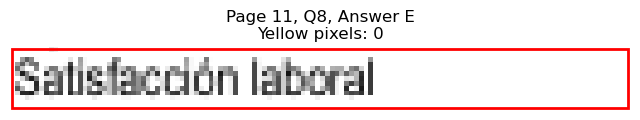


Page 11, Q8 - Selected Answer: B (based on yellow pixel count)




Page 11, Q9 - A: Detected box: x0=85.0, y0=675.4, x1=226.3, y1=687.5
Page 11, Q9, A: Yellow pixels: 0
Page 11, Q9, A: Total non-white pixels: 679
Page 11, Q9, A: Yellow percentage: 0.0%


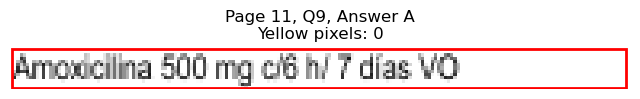

Page 11, Q9 - B: Detected box: x0=85.0, y0=687.5, x1=221.0, y1=699.7
Page 11, Q9, B: Yellow pixels: 0
Page 11, Q9, B: Total non-white pixels: 682
Page 11, Q9, B: Yellow percentage: 0.0%


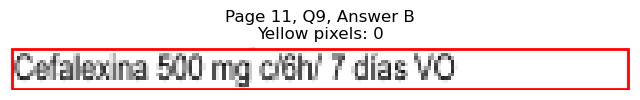

Page 11, Q9 - C: Detected box: x0=85.0, y0=699.5, x1=242.9, y1=711.7
Page 11, Q9, C: Yellow pixels: 0
Page 11, Q9, C: Total non-white pixels: 733
Page 11, Q9, C: Yellow percentage: 0.0%


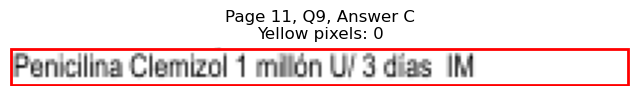

Page 11, Q9 - D: Detected box: x0=336.7, y0=675.4, x1=458.3, y1=687.5
Page 11, Q9, D: Yellow pixels: 1045
Page 11, Q9, D: Total non-white pixels: 1560
Page 11, Q9, D: Yellow percentage: 67.0%


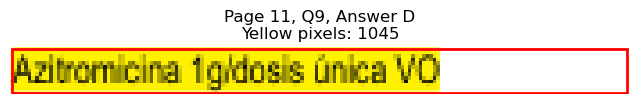

Page 11, Q9 - E: Detected box: x0=336.7, y0=687.5, x1=482.1, y1=699.7
Page 11, Q9, E: Yellow pixels: 119
Page 11, Q9, E: Total non-white pixels: 824
Page 11, Q9, E: Yellow percentage: 14.4%


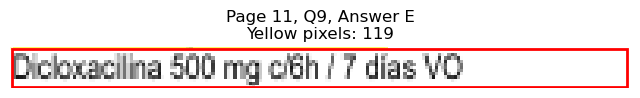


Page 11, Q9 - Selected Answer: D (based on yellow pixel count)




Page 11, Q10 - A: Detected box: x0=85.0, y0=735.8, x1=149.2, y1=747.9
Page 11, Q10, A: Yellow pixels: 0
Page 11, Q10, A: Total non-white pixels: 369
Page 11, Q10, A: Yellow percentage: 0.0%


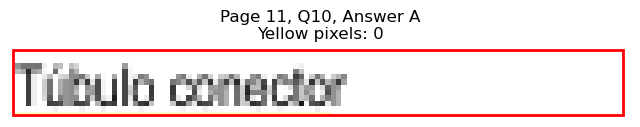

Page 11, Q10 - B: Detected box: x0=85.0, y0=747.8, x1=146.3, y1=759.9
Page 11, Q10, B: Yellow pixels: 470
Page 11, Q10, B: Total non-white pixels: 781
Page 11, Q10, B: Yellow percentage: 60.2%


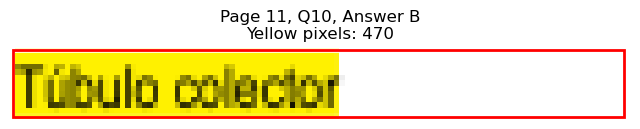

Page 11, Q10 - C: Detected box: x0=85.0, y0=759.8, x1=139.1, y1=771.9
Page 11, Q10, C: Yellow pixels: 59
Page 11, Q10, C: Total non-white pixels: 329
Page 11, Q10, C: Yellow percentage: 17.9%


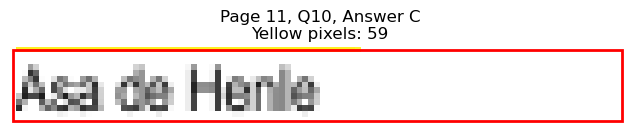

Page 11, Q10 - D: Detected box: x0=336.7, y0=735.8, x1=400.4, y1=747.9
Page 11, Q10, D: Yellow pixels: 0
Page 11, Q10, D: Total non-white pixels: 312
Page 11, Q10, D: Yellow percentage: 0.0%


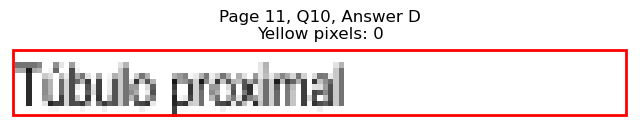

Page 11, Q10 - E: Detected box: x0=336.7, y0=747.8, x1=385.6, y1=759.9
Page 11, Q10, E: Yellow pixels: 0
Page 11, Q10, E: Total non-white pixels: 265
Page 11, Q10, E: Yellow percentage: 0.0%


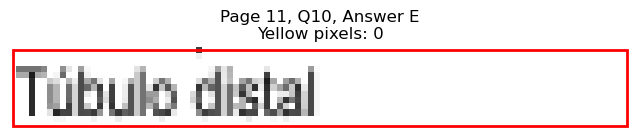


Page 11, Q10 - Selected Answer: B (based on yellow pixel count)





Page 12: Found 4 questions
Page 12, Q1 - A: Detected box: x0=85.0, y0=133.2, x1=149.2, y1=145.3
Page 12, Q1, A: Yellow pixels: 463
Page 12, Q1, A: Total non-white pixels: 819
Page 12, Q1, A: Yellow percentage: 56.5%


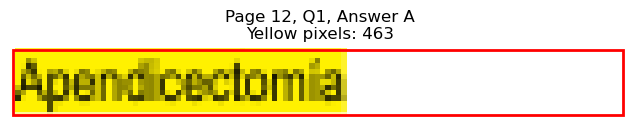

Page 12, Q1 - B: Detected box: x0=85.0, y0=145.3, x1=209.0, y1=157.4
Page 12, Q1, B: Yellow pixels: 1
Page 12, Q1, B: Total non-white pixels: 705
Page 12, Q1, B: Yellow percentage: 0.1%


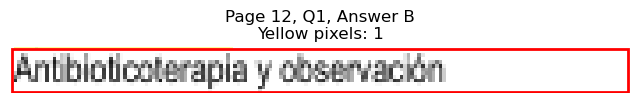

Page 12, Q1 - C: Detected box: x0=85.0, y0=157.3, x1=173.5, y1=169.4
Page 12, Q1, C: Yellow pixels: 0
Page 12, Q1, C: Total non-white pixels: 473
Page 12, Q1, C: Yellow percentage: 0.0%


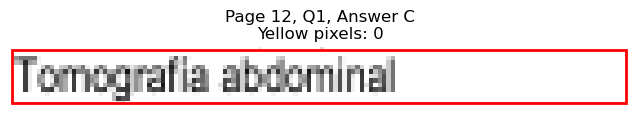

Page 12, Q1 - D: Detected box: x0=336.7, y0=133.2, x1=418.0, y1=145.3
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 432
Page 12, Q1, D: Yellow percentage: 0.0%


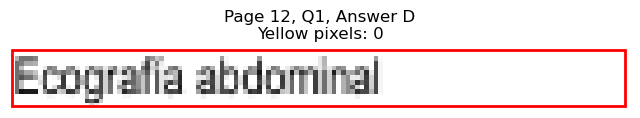

Page 12, Q1 - E: Detected box: x0=336.7, y0=145.3, x1=426.7, y1=157.4
Page 12, Q1, E: Yellow pixels: 0
Page 12, Q1, E: Total non-white pixels: 464
Page 12, Q1, E: Yellow percentage: 0.0%


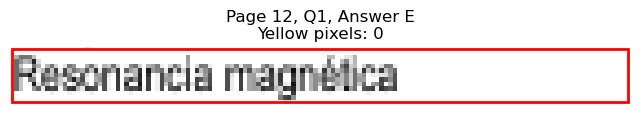


Page 12, Q1 - Selected Answer: A (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=116.5, y1=205.5
Page 12, Q2, A: Yellow pixels: 0
Page 12, Q2, A: Total non-white pixels: 176
Page 12, Q2, A: Yellow percentage: 0.0%


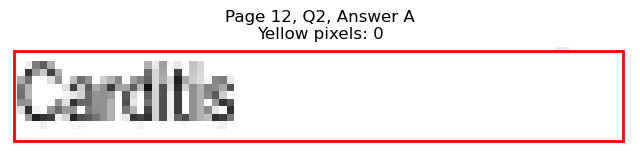

Page 12, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=160.1, y1=217.7
Page 12, Q2, B: Yellow pixels: 0
Page 12, Q2, B: Total non-white pixels: 397
Page 12, Q2, B: Yellow percentage: 0.0%


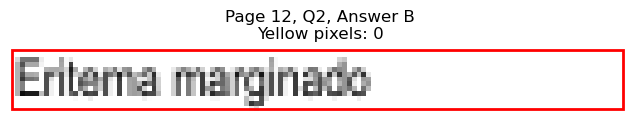

Page 12, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=110.8, y1=229.7
Page 12, Q2, C: Yellow pixels: 0
Page 12, Q2, C: Total non-white pixels: 127
Page 12, Q2, C: Yellow percentage: 0.0%


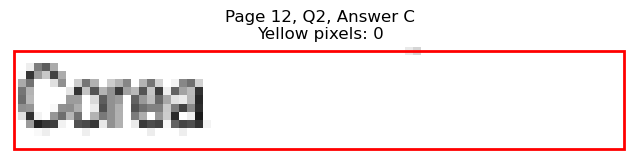

Page 12, Q2 - D: Detected box: x0=336.7, y0=193.4, x1=363.4, y1=205.5
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 134
Page 12, Q2, D: Yellow percentage: 0.0%


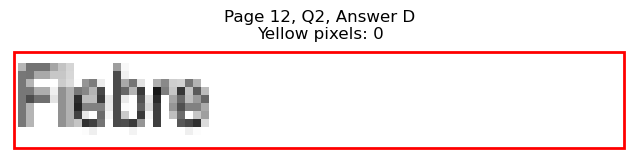

Page 12, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=363.4, y1=217.7
Page 12, Q2, E: Yellow pixels: 213
Page 12, Q2, E: Total non-white pixels: 338
Page 12, Q2, E: Yellow percentage: 63.0%


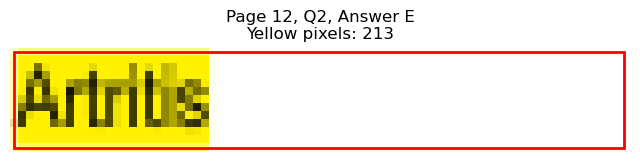


Page 12, Q2 - Selected Answer: E (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=85.0, y0=265.8, x1=286.5, y1=277.9
Page 12, Q3, A: Yellow pixels: 0
Page 12, Q3, A: Total non-white pixels: 1031
Page 12, Q3, A: Yellow percentage: 0.0%


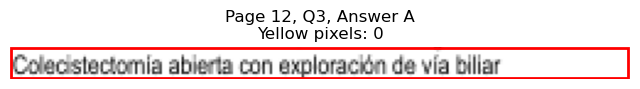

Page 12, Q3 - B: Detected box: x0=85.0, y0=277.8, x1=232.4, y1=289.9
Page 12, Q3, B: Yellow pixels: 0
Page 12, Q3, B: Total non-white pixels: 756
Page 12, Q3, B: Yellow percentage: 0.0%


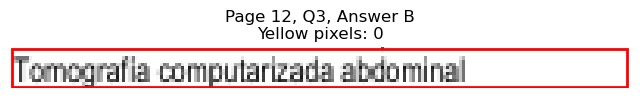

Page 12, Q3 - C: Detected box: x0=85.0, y0=289.9, x1=166.3, y1=302.0
Page 12, Q3, C: Yellow pixels: 132
Page 12, Q3, C: Total non-white pixels: 691
Page 12, Q3, C: Yellow percentage: 19.1%


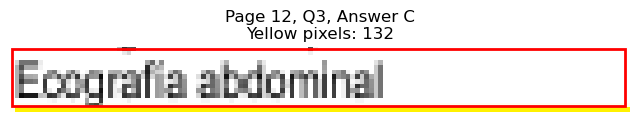

Page 12, Q3 - D: Detected box: x0=85.0, y0=301.9, x1=310.0, y1=314.0
Page 12, Q3, D: Yellow pixels: 1759
Page 12, Q3, D: Total non-white pixels: 2912
Page 12, Q3, D: Yellow percentage: 60.4%


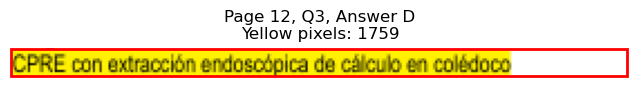

Page 12, Q3 - E: Detected box: x0=85.0, y0=313.9, x1=303.8, y1=326.0
Page 12, Q3, E: Yellow pixels: 222
Page 12, Q3, E: Total non-white pixels: 1357
Page 12, Q3, E: Yellow percentage: 16.4%


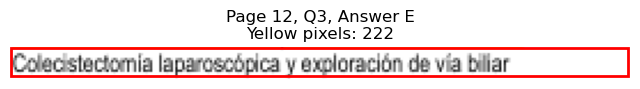


Page 12, Q3 - Selected Answer: D (based on yellow pixel count)




Page 12, Q4 - A: Detected box: x0=85.0, y0=350.2, x1=224.8, y1=362.3
Page 12, Q4, A: Yellow pixels: 190
Page 12, Q4, A: Total non-white pixels: 899
Page 12, Q4, A: Yellow percentage: 21.1%


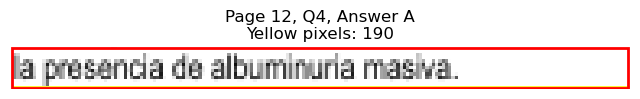

Page 12, Q4 - B: Detected box: x0=85.0, y0=362.2, x1=368.4, y1=374.3
Page 12, Q4, B: Yellow pixels: 2219
Page 12, Q4, B: Total non-white pixels: 3665
Page 12, Q4, B: Yellow percentage: 60.5%


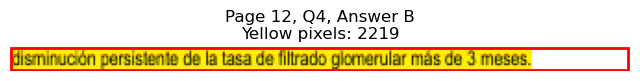

Page 12, Q4 - C: Detected box: x0=85.0, y0=374.2, x1=284.7, y1=386.3
Page 12, Q4, C: Yellow pixels: 0
Page 12, Q4, C: Total non-white pixels: 1245
Page 12, Q4, C: Yellow percentage: 0.0%


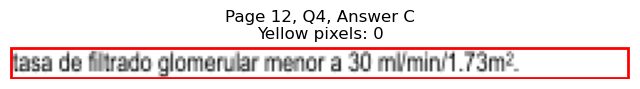

Page 12, Q4 - D: Detected box: x0=85.0, y0=386.3, x1=206.6, y1=398.4
Page 12, Q4, D: Yellow pixels: 0
Page 12, Q4, D: Total non-white pixels: 648
Page 12, Q4, D: Yellow percentage: 0.0%


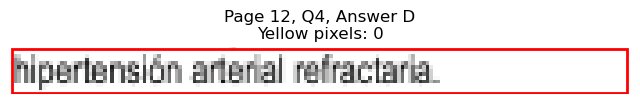

Page 12, Q4 - E: Detected box: x0=85.0, y0=398.3, x1=345.9, y1=410.4
Page 12, Q4, E: Yellow pixels: 0
Page 12, Q4, E: Total non-white pixels: 1319
Page 12, Q4, E: Yellow percentage: 0.0%


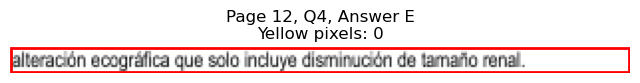


Page 12, Q4 - Selected Answer: B (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Lactante de 1 mes 15 días presenta cuadro febr...
1   ¿Cuál de las siguientes vacunas debe recibir l...
2   El carcinoma que se extiende fuera del cuello ...
3   Varón de 20 años que luego de sufrir accidente...
4   Los bronquiolos terminales de pulmones sanos c...
..                                                ...
95  ¿En dónde se ubican las células intercaladas o...
96  Varón de 86 años que hace 96 horas presenta do...
97  ¿Cuál es el criterio mayor más frecuente para ...
98  Mujer de 30 años con diagnóstico de colecistit...
99  El diagnóstico de enfermedad renal crónica se ...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                            25 mg/Kg   
1                                                dTpa   
2                                                II b   
3                      Supina y tracción en abducción   
4                                           ciliadas.   
..                                                ...   
95                                    Túbulo conector   
96                                     Apendicectomía   
97                                           Carditis   
98  Colecistectomía abierta con exploración de vía...   
99                la presencia de albuminuria masiva.   

                                             option_B  \
0                                            75 mg/Kg   
1                                             Tétanos   
2                                               III a   
3                       Prona y tracción en abducción   
4                                epiteliales simples.   
..                                                ...   
95                                    Túbulo colector   
96                   Antibioticoterapia y observación   
97                                  Eritema marginado   
98                 Tomografía computarizada abdominal   
99  disminución persistente de la tasa de filtrado...   

                                             option_C  \
0                                           200 mg/Kg   
1                                       Triple vírica   
2                                               III b   
3                        Prona y tracción en aducción   
4                                   musculares lisas.   
..                                                ...   
95                                       Asa de Henle   
96                               Tomografía abdominal   
97                                              Corea   
98                                Ecografía abdominal   
99  tasa de filtrado glomerular menor a 30 ml/min/...   

                                             option_D  \
0                                            50 mg/Kg   
1                                            Varicela   
2                                                 I b   
3                       Supina y tracción en aducción   
4                                           de Clara.   
..                                                ...   
95                                    Túbulo proximal   
96                                Ecografía abdominal   
97                                             Fiebre   
98  CPRE con extracción endoscópica de cálculo en ...   
99                 hipertensión arterial refractaria.   

                                             option_E  
0                                           150 mg/Kg  
1                                         Hepatitis B  
2                                                II a  
3             Decúbito dorsal y tracción en abducción  
4                                       caliciformes.  
..                                                ...  
95                                      Túbulo distal  
96                               Resonancia magnética  
97                                           Artritis  
98  Colecistectomía laparoscópica y exploración de...  
99  alteración ecográfica que solo incluye disminu...  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               A
2               E
3               A
4               E
..            ...
95              B
96              A
97              E
98              D
99              B

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Lactante de 1 mes 15 días presenta cuadro febr...   
1   ¿Cuál de las siguientes vacunas debe recibir l...   
2   El carcinoma que se extiende fuera del cuello ...   
3   Varón de 20 años que luego de sufrir accidente...   
4   Los bronquiolos terminales de pulmones sanos c...   
..                                                ...   
95  ¿En dónde se ubican las células intercaladas o...   
96  Varón de 86 años que hace 96 horas presenta do...   
97  ¿Cuál es el criterio mayor más frecuente para ...   
98  Mujer de 30 años con diagnóstico de colecistit...   
99  El diagnóstico de enfermedad renal crónica se ...   

                                             option_A  \
0                                            25 mg/Kg   
1                                                dTpa   
2                                                II b   
3                      Supina y tracción en abducción   
4                                           ciliadas.   
..                                                ...   
95                                    Túbulo conector   
96                                     Apendicectomía   
97                                           Carditis   
98  Colecistectomía abierta con exploración de vía...   
99                la presencia de albuminuria masiva.   

                                             option_B  \
0                                            75 mg/Kg   
1                                             Tétanos   
2                                               III a   
3                       Prona y tracción en abducción   
4                                epiteliales simples.   
..                                                ...   
95                                    Túbulo colector   
96                   Antibioticoterapia y observación   
97                                  Eritema marginado   
98                 Tomografía computarizada abdominal   
99  disminución persistente de la tasa de filtrado...   

                                             option_C  \
0                                           200 mg/Kg   
1                                       Triple vírica   
2                                               III b   
3                        Prona y tracción en aducción   
4                                   musculares lisas.   
..                                                ...   
95                                       Asa de Henle   
96                               Tomografía abdominal   
97                                              Corea   
98                                Ecografía abdominal   
99  tasa de filtrado glomerular menor a 30 ml/min/...   

                                             option_D  \
0                                            50 mg/Kg   
1                                            Varicela   
2                                                 I b   
3                       Supina y tracción en aducción   
4                                           de Clara.   
..                                                ...   
95                                    Túbulo proximal   
96                                Ecografía abdominal   
97                                             Fiebre   
98  CPRE con extracción endoscópica de cálculo en ...   
99                 hipertensión arterial refractaria.   

                                             option_E correct_answer  
0                                           150 mg/Kg              B  
1                                         Hepatitis B              A  
2                                                II a              E  
3             Decúbito dorsal y tracción en abducción              A  
4                                       caliciformes.              E  
..                                                ...            ...  
95                                      Túbulo distal              B  
96                               Resonancia magnéti

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/PRUEBA A.csv
